In [1]:
import wandb
from tqdm import tqdm
import numpy as np

api = wandb.Api()

def load_lcbench_varying_cost_runs(data, acq):
    runs = api.runs(path="ziv-scully-group/StoppingBayesOptEmpirical", filters={
        "sweep": "e2hd88fe",
        "config.dataset_name": data,
        "config.acquisition_function": acq},
        )
    
    configs_and_metrics = []
    for run in tqdm(runs):
        metric_keys = ["config id", "cumulative cost", "estimated cumulative cost", "current best id", "current best observed", "StablePBGI(1e-3) acq", "StablePBGI(1e-4) acq", "StablePBGI(1e-5) acq", "LogEIC acq", "regret upper bound", "exp min regret gap", "PRB"]
        history = list(run.scan_history(keys = metric_keys, page_size=1_000_000_000))
        metrics = {k: [d[k] for d in history] for k in metric_keys}
        configs_and_metrics.append((run.config, metrics))

    return configs_and_metrics

In [2]:
dataset_names = ['Fashion-MNIST', 'adult', 'higgs', 'volkert']
acquisition_functions = {
        "LogEIC": "LogEIC",
        "StablePBGI(1e-3)": "PBGI(1e-3)",
        "StablePBGI(1e-4)": "PBGI(1e-4)", 
        "StablePBGI(1e-5)": "PBGI(1e-5)", 
        "LCB": "LCB",
        "TS": "TS"
    }

In [3]:
grouped_runs = {(d, a): load_lcbench_varying_cost_runs(d, a) for d in dataset_names for a in acquisition_functions}

100%|██████████| 50/50 [00:27<00:00,  1.83it/s]


In [4]:
from collections import defaultdict
import numpy as np

# Create a single nested defaultdict for all metrics
metrics_per_acq = defaultdict(lambda: defaultdict(dict))

for d in dataset_names:
    for a in acquisition_functions.keys():
        config_and_metrics_per_seed = grouped_runs[(d, a)]

        # Extract metrics along with the seeds for sorting
        seeds_and_metrics = [
            (
                config['seed'],
                m['cumulative cost'],
                m['estimated cumulative cost'],
                m['config id'],
                m['current best id'],
                m['current best observed'],
                m['StablePBGI(1e-3) acq'],
                m['StablePBGI(1e-4) acq'],
                m['StablePBGI(1e-5) acq'],
                m['LogEIC acq'],
                m['exp min regret gap'],
                m['regret upper bound'],
                m['PRB']
            )
            for config, m in config_and_metrics_per_seed
            if len(m['current best observed']) > 0
        ]

        # Sort by seed
        seeds_and_metrics.sort(key=lambda x: x[0])

        # Extract sorted metrics
        metric_keys = [
            "cumulative cost",
            'estimated cumulative cost',
            "config id",
            "current best id",
            "current best observed",
            "PBGI(1e-3) acq",
            "PBGI(1e-4) acq",
            "PBGI(1e-5) acq",
            "LogEIC acq",
            "exp min regret gap",
            "regret upper bound",
            "PRB"
        ]

        arrays = [
            np.array([item[i + 1] for item in seeds_and_metrics], dtype=int if "id" in key else float)
            for i, key in enumerate(metric_keys)
        ]

        print(d, a, arrays[1].shape)  # config_id is arrays[1]

        for key, array in zip(metric_keys, arrays):
            metrics_per_acq[d][acquisition_functions[a]][key] = array

Fashion-MNIST LogEIC (50, 201)
Fashion-MNIST StablePBGI(1e-3) (50, 201)
Fashion-MNIST StablePBGI(1e-4) (50, 201)
Fashion-MNIST StablePBGI(1e-5) (50, 201)
Fashion-MNIST LCB (50, 201)
Fashion-MNIST TS (50, 201)
adult LogEIC (50, 201)
adult StablePBGI(1e-3) (50, 201)
adult StablePBGI(1e-4) (50, 201)
adult StablePBGI(1e-5) (50, 201)
adult LCB (50, 201)
adult TS (50, 201)
higgs LogEIC (50, 201)
higgs StablePBGI(1e-3) (50, 201)
higgs StablePBGI(1e-4) (50, 201)
higgs StablePBGI(1e-5) (50, 201)
higgs LCB (50, 201)
higgs TS (50, 201)
volkert LogEIC (50, 201)
volkert StablePBGI(1e-3) (50, 201)
volkert StablePBGI(1e-4) (50, 201)
volkert StablePBGI(1e-5) (50, 201)
volkert LCB (50, 201)
volkert TS (50, 201)


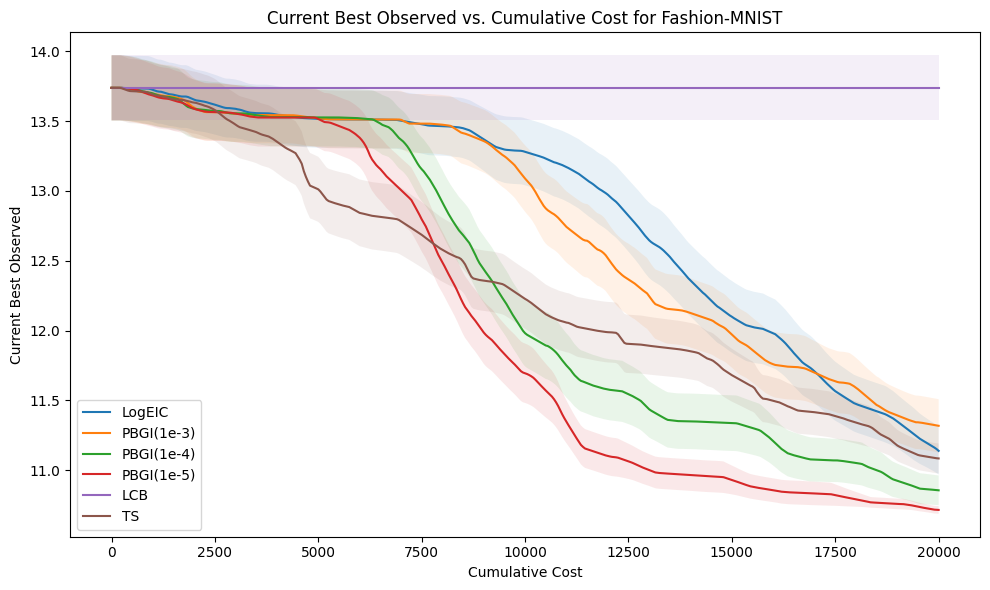

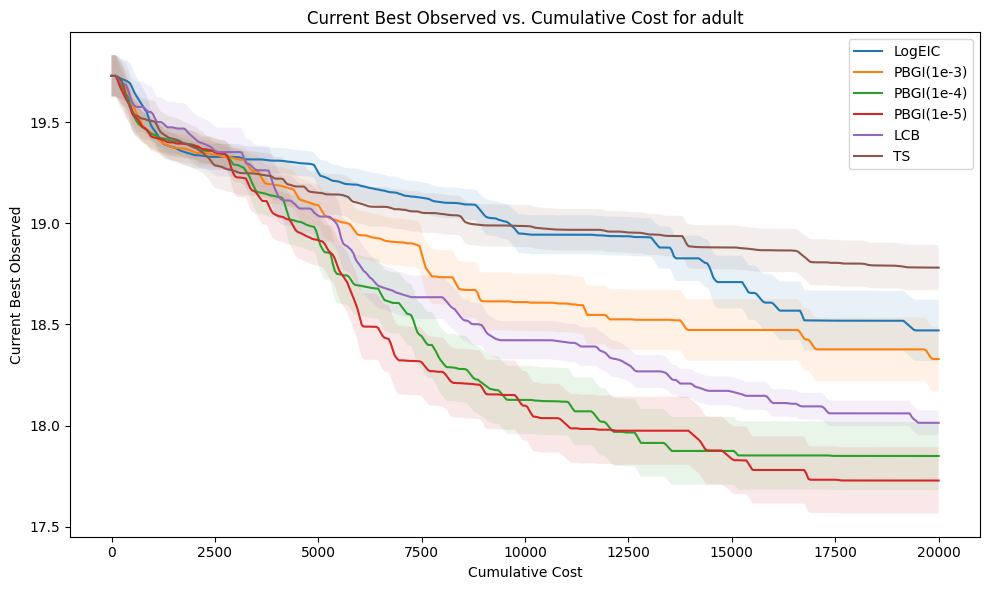

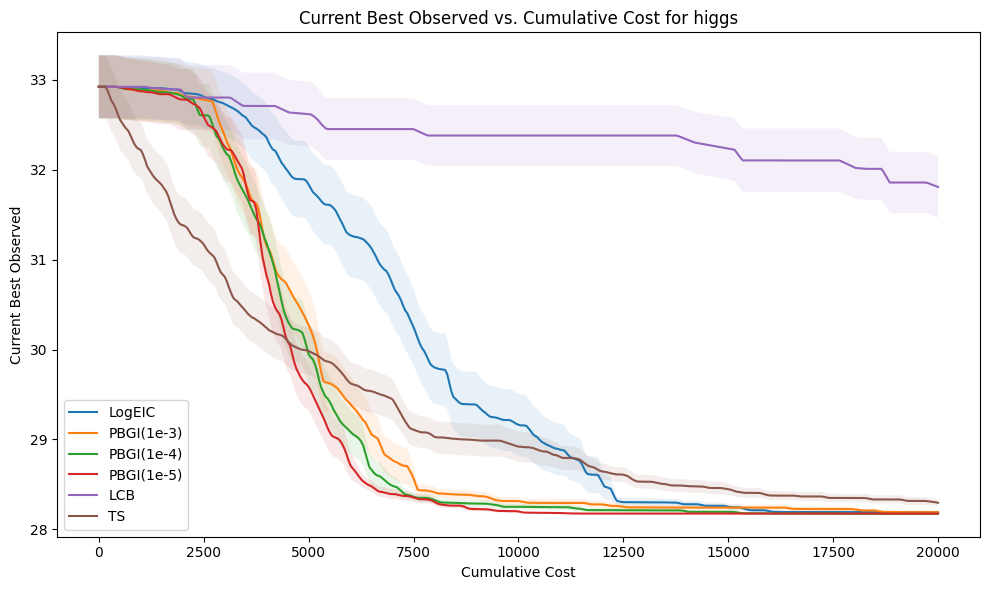

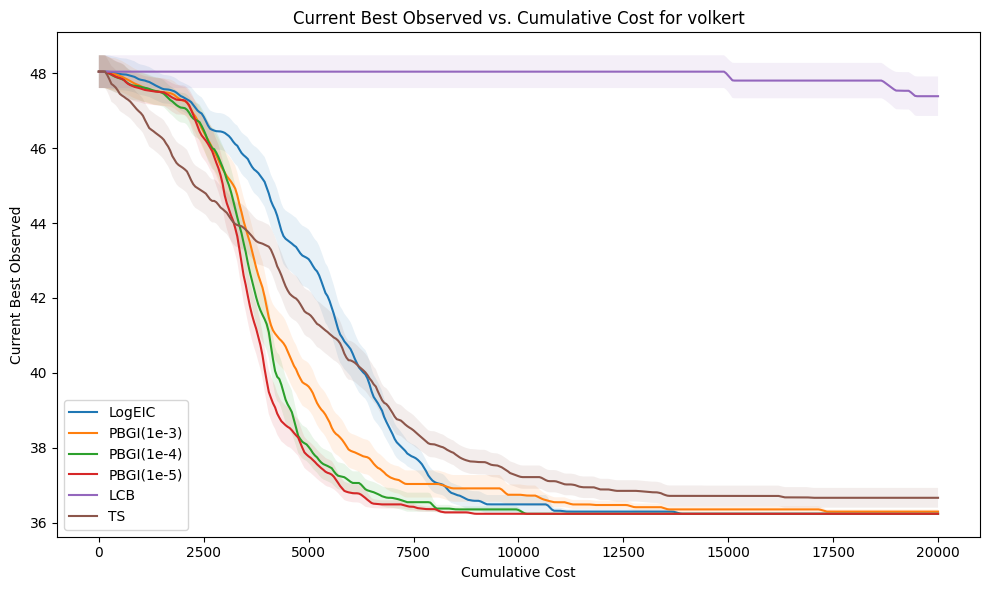

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Define the common cumulative cost grid from 0 to 20000.
cost_grid = np.linspace(0, 20000, 401)

# Loop over each dataset to create one plot per dataset.
for d in dataset_names:
    plt.figure(figsize=(10, 6))
    
    # For each acquisition function within the dataset:
    for a in acquisition_functions.values():
        # List to hold interpolated curves for each seed
        interpolated_curves = []
        
        # Access arrays from the unified structure
        cum_cost_array = metrics_per_acq[d][a]["cumulative cost"]
        best_obs_array = metrics_per_acq[d][a]["current best observed"]
        
        # Loop over each seed (assume the first dimension indexes seeds)
        for seed_id in range(len(cum_cost_array)):
            cum_cost = np.array(cum_cost_array[seed_id])
            best_obs = np.array(best_obs_array[seed_id])
            
            # Ensure the arrays are sorted by cumulative cost.
            sort_id = np.argsort(cum_cost)
            cum_cost_sorted = cum_cost[sort_id]
            best_obs_sorted = best_obs[sort_id]
            
            # Interpolate to common cost grid
            interp_best_obs = np.interp(cost_grid, cum_cost_sorted, best_obs_sorted)
            interpolated_curves.append(interp_best_obs)
        
        # Convert to a NumPy array with shape (n_seeds, len(cost_grid))
        interpolated_curves = np.array(interpolated_curves)
        
        # Compute mean and standard error across seeds
        mean_curve = np.mean(interpolated_curves, axis=0)
        std_curve = np.std(interpolated_curves, axis=0)
        sem_curve = std_curve / np.sqrt(interpolated_curves.shape[0])
        
        # Plot
        plt.plot(cost_grid, mean_curve, label=a)
        plt.fill_between(cost_grid, mean_curve - sem_curve, mean_curve + sem_curve, alpha=0.1)
    
    # Customize plot
    plt.title(f"Current Best Observed vs. Cumulative Cost for {d}")
    plt.xlabel("Cumulative Cost")
    plt.ylabel("Current Best Observed")
    plt.legend()
    plt.tight_layout()
    plt.show()

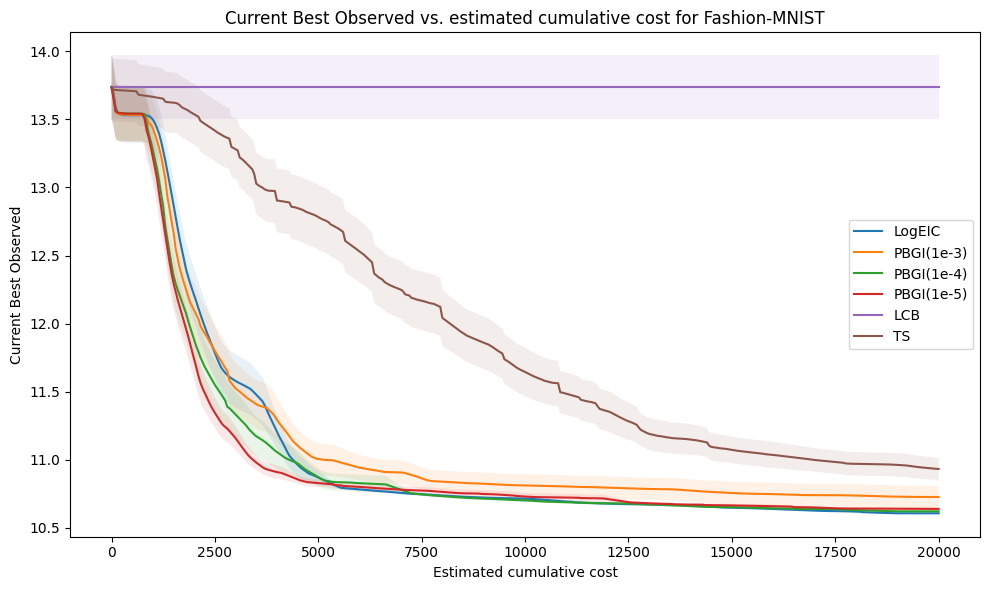

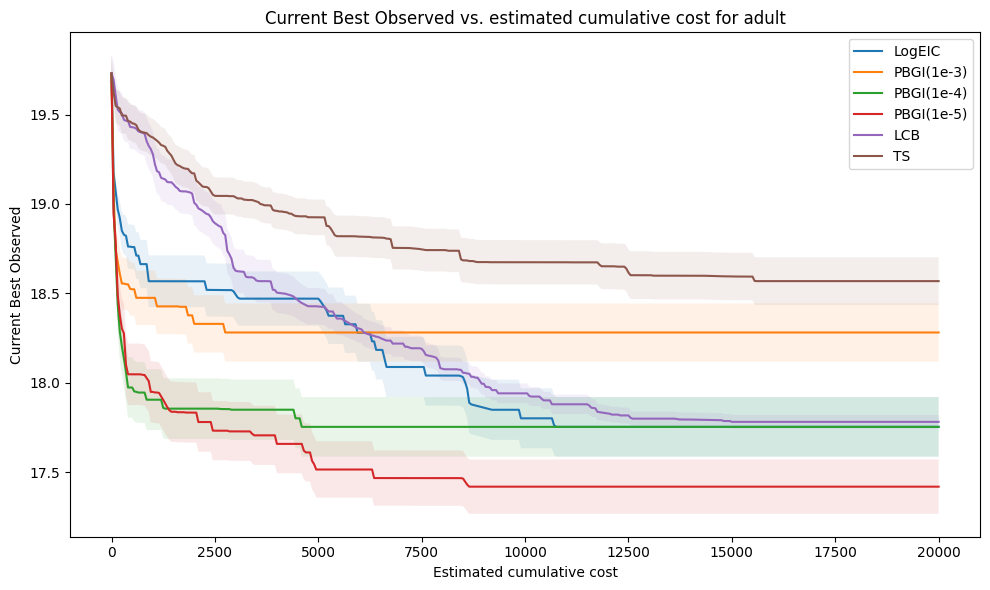

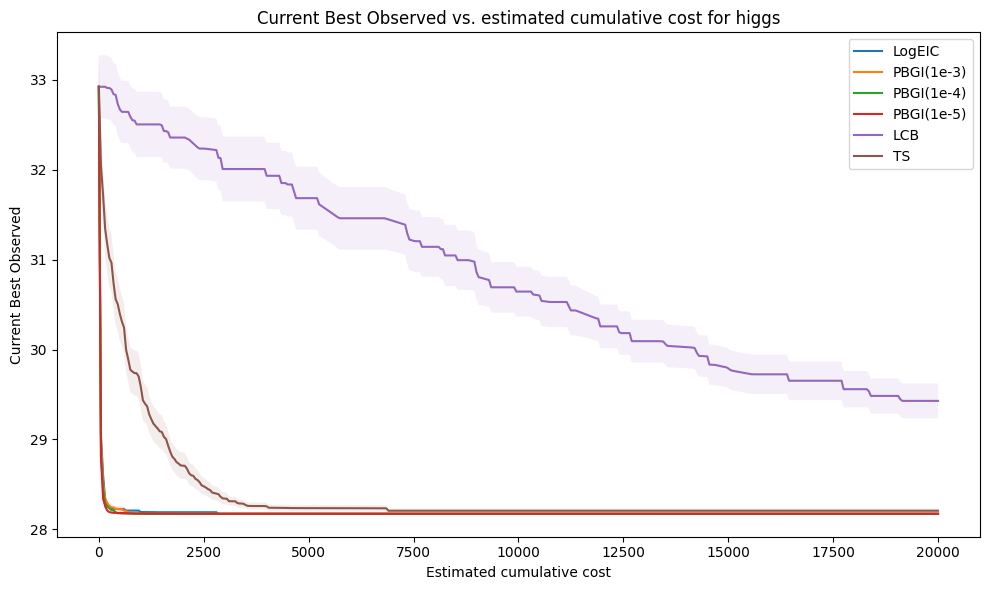

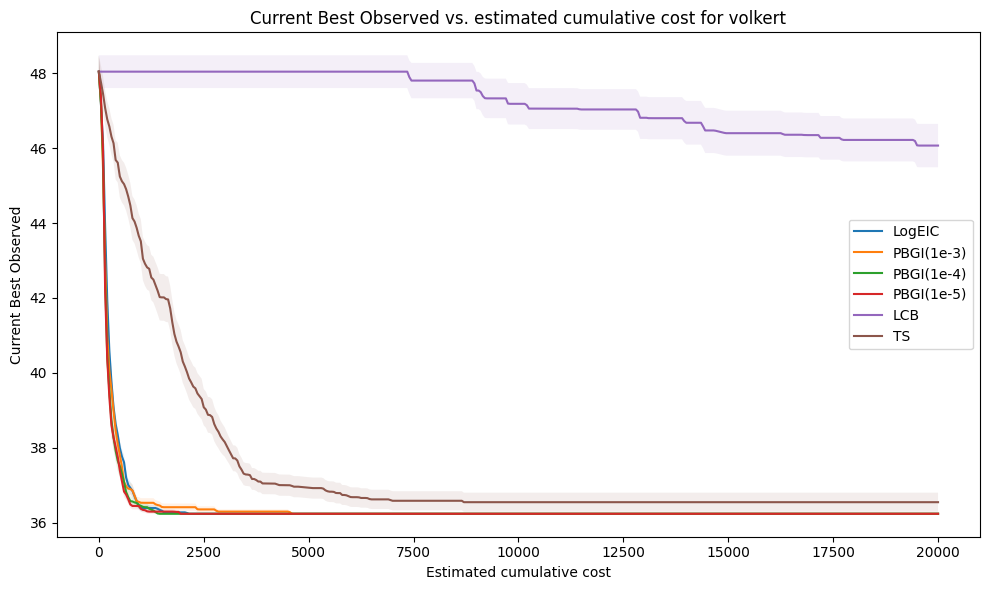

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Define the common estimated cumulative cost grid from 0 to 20000.
cost_grid = np.linspace(0, 20000, 401)

# Loop over each dataset to create one plot per dataset.
for d in dataset_names:
    plt.figure(figsize=(10, 6))
    
    # For each acquisition function within the dataset:
    for a in acquisition_functions.values():
        # List to hold interpolated curves for each seed
        interpolated_curves = []
        
        # Access arrays from the unified structure
        est_cum_cost_array = metrics_per_acq[d][a]["estimated cumulative cost"]
        best_obs_array = metrics_per_acq[d][a]["current best observed"]
        
        # Loop over each seed (assume the first dimension indexes seeds)
        for seed_id in range(len(est_cum_cost_array)):
            est_cum_cost = np.array(est_cum_cost_array[seed_id])
            best_obs = np.array(best_obs_array[seed_id])
            
            # Ensure the arrays are sorted by estimated cumulative cost.
            sort_id = np.argsort(est_cum_cost)
            est_cum_cost_sorted = est_cum_cost[sort_id]
            best_obs_sorted = best_obs[sort_id]
            
            # Interpolate to common cost grid
            interp_best_obs = np.interp(cost_grid, est_cum_cost_sorted, best_obs_sorted)
            interpolated_curves.append(interp_best_obs)
        
        # Convert to a NumPy array with shape (n_seeds, len(cost_grid))
        interpolated_curves = np.array(interpolated_curves)
        
        # Compute mean and standard error across seeds
        mean_curve = np.mean(interpolated_curves, axis=0)
        std_curve = np.std(interpolated_curves, axis=0)
        sem_curve = std_curve / np.sqrt(interpolated_curves.shape[0])
        
        # Plot
        plt.plot(cost_grid, mean_curve, label=a)
        plt.fill_between(cost_grid, mean_curve - sem_curve, mean_curve + sem_curve, alpha=0.1)
    
    # Customize plot
    plt.title(f"Current Best Observed vs. estimated cumulative cost for {d}")
    plt.xlabel("Estimated cumulative cost")
    plt.ylabel("Current Best Observed")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [7]:
import os
print("Current working dir:", os.getcwd())

import sys
import os

root_dir = os.path.abspath("..")
print("Adding to sys.path:", root_dir)
sys.path.insert(0, root_dir)  # Insert ensures priority

Current working dir: /Users/qianxie/Desktop/Curriculum/Graduate/Research/CostAwareStoppingBayesOpt/notebooks
Adding to sys.path: /Users/qianxie/Desktop/Curriculum/Graduate/Research/CostAwareStoppingBayesOpt


In [8]:
import importlib.util

api_path = os.path.join(root_dir, "LCBench", "api.py")
spec = importlib.util.spec_from_file_location("LCBench.api", api_path)
api = importlib.util.module_from_spec(spec)
spec.loader.exec_module(api)

Benchmark = api.Benchmark

In [9]:
os.makedirs("../LCBench/cached", exist_ok=True)
bench_dir = "../LCBench/cached/six_datasets_lw.json"
bench = Benchmark(bench_dir, cache=False)

==> Loading data...
==> No cached data found or cache set to False.
==> Reading json data...
==> Done.


In [10]:
from collections import defaultdict
import numpy as np

# Initialize unified storage for test metrics
test_metrics_per_acq = defaultdict(lambda: defaultdict(dict))

# Loop over each dataset and acquisition function.
for d in dataset_names:
    for a in acquisition_functions.values():
        # Access current best IDs from the unified structure
        best_ids = metrics_per_acq[d][a]["current best id"]
        n_seeds, n_iterations = best_ids.shape
        
        # Prepare arrays to store the test metrics
        test_error_mat = np.empty((n_seeds, n_iterations))
        
        # Use the best configuration IDs to query test metrics
        for s in range(n_seeds):
            for i in range(n_iterations):
                config_id = best_ids[s, i]
                test_error_mat[s, i] = 100-bench.query(d, "final_test_accuracy", config_id)
        
        # Store in unified structure
        test_metrics_per_acq[d][a]["final test error"] = test_error_mat

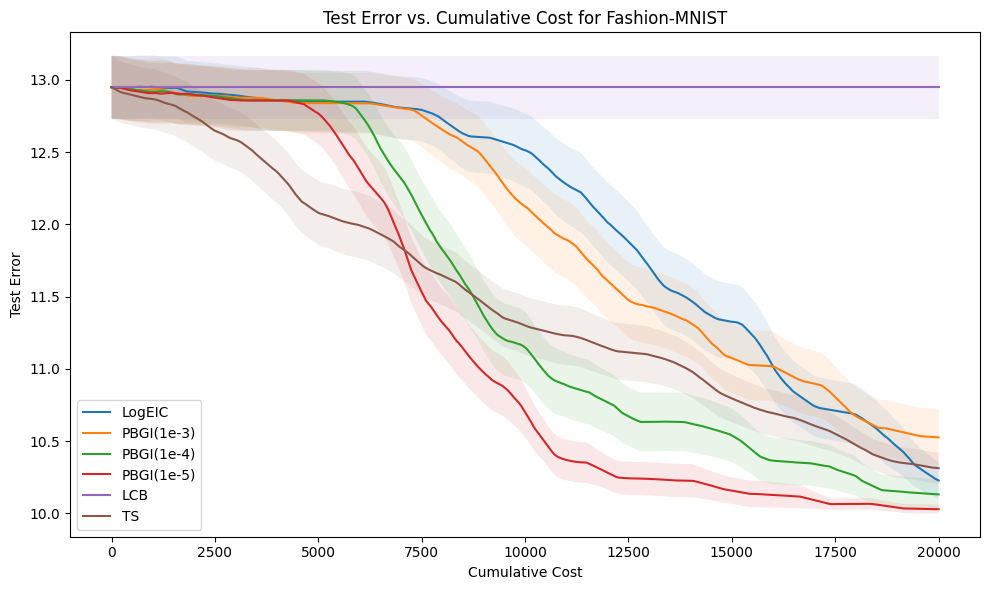

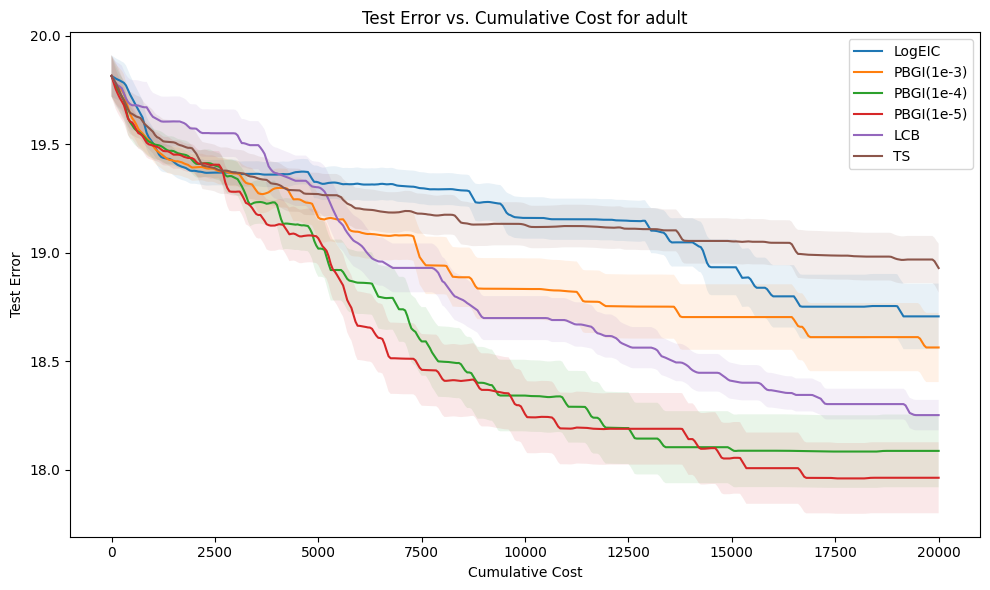

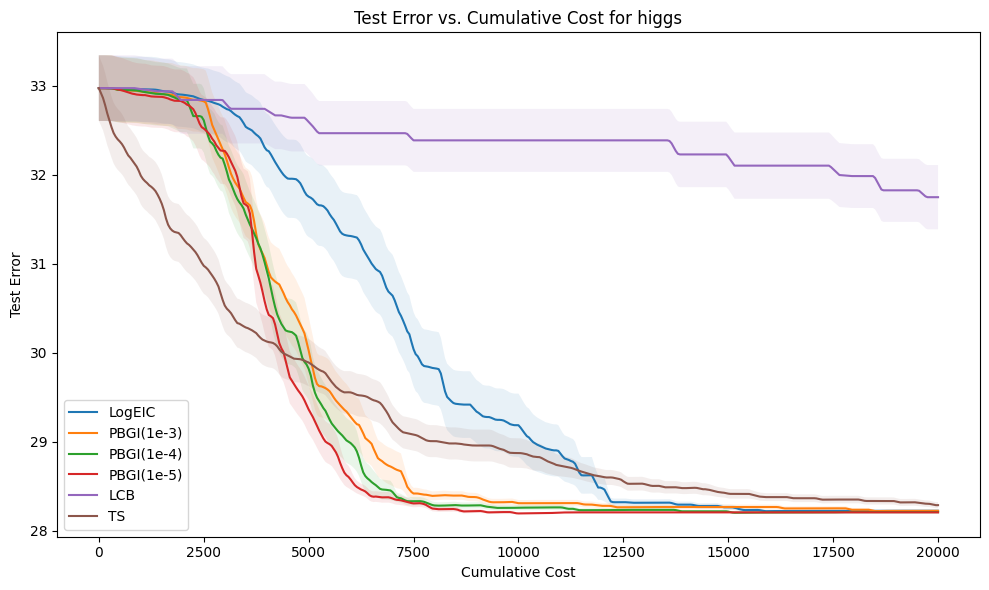

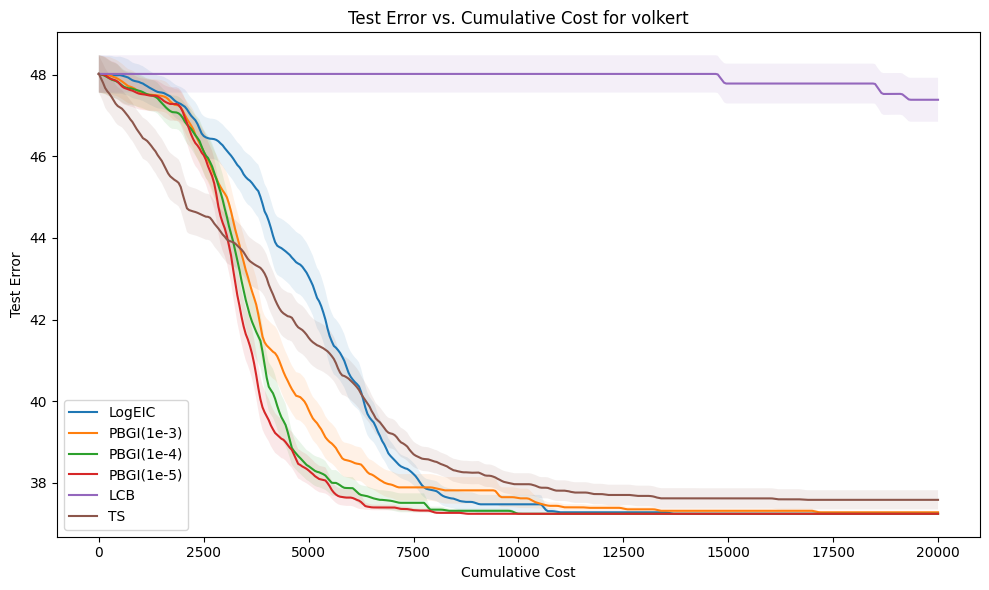

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Define the common cumulative cost grid from 0 to 20000.
cost_grid = np.linspace(0, 20000, 401)

# Loop over each dataset to create one plot per dataset.
for d in dataset_names:
    plt.figure(figsize=(10, 6))
    
    # For each acquisition function within the dataset:
    for a in acquisition_functions.values():
        # List to hold interpolated curves for each seed.
        interpolated_curves = []
        
        # Access arrays from unified structures
        cum_cost_array = metrics_per_acq[d][a]["cumulative cost"]
        test_error_array = test_metrics_per_acq[d][a]["final test error"]
        
        # Loop over each seed (assuming the first dimension indexes seeds).
        for seed_id in range(len(cum_cost_array)):
            cum_cost = np.array(cum_cost_array[seed_id])
            test_error = np.array(test_error_array[seed_id])
            
            # Ensure the arrays are sorted by cumulative cost.
            sort_id = np.argsort(cum_cost)
            cum_cost_sorted = cum_cost[sort_id]
            test_error_sorted = test_error[sort_id]
            
            # Interpolate test error to the common cost grid
            interp_test_error = np.interp(cost_grid, cum_cost_sorted, test_error_sorted)
            interpolated_curves.append(interp_test_error)
        
        # Stack curves and compute statistics
        interpolated_curves = np.array(interpolated_curves)
        mean_curve = np.mean(interpolated_curves, axis=0)
        std_curve = np.std(interpolated_curves, axis=0)
        sem_curve = std_curve / np.sqrt(interpolated_curves.shape[0])
        
        # Plot
        plt.plot(cost_grid, mean_curve, label=a)
        plt.fill_between(cost_grid, mean_curve - sem_curve, mean_curve + sem_curve, alpha=0.1)
    
    # Final touches
    plt.title(f"Test Error vs. Cumulative Cost for {d}")
    plt.xlabel("Cumulative Cost")
    plt.ylabel("Test Error")
    plt.legend()
    plt.tight_layout()
    plt.show()

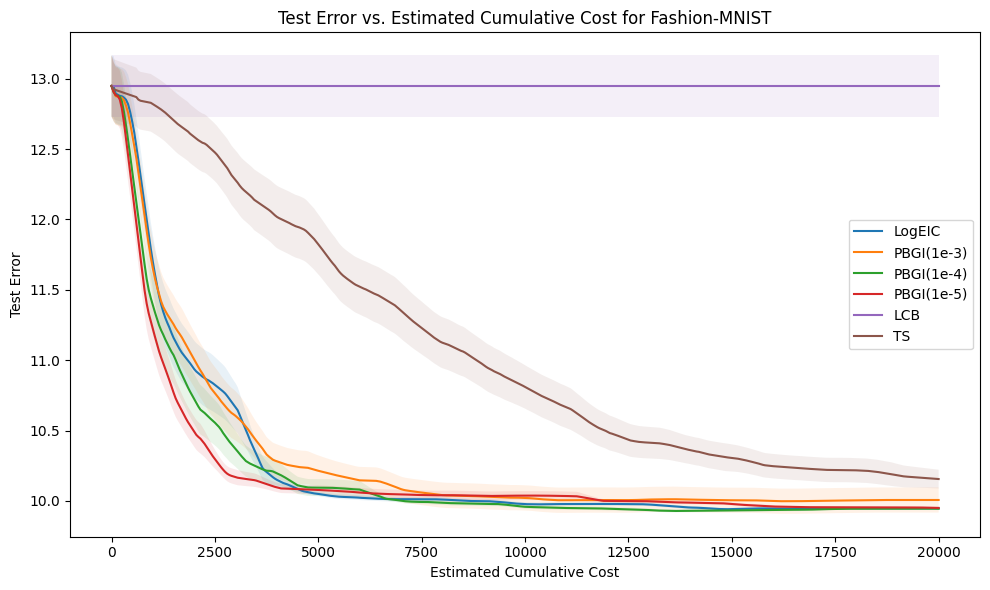

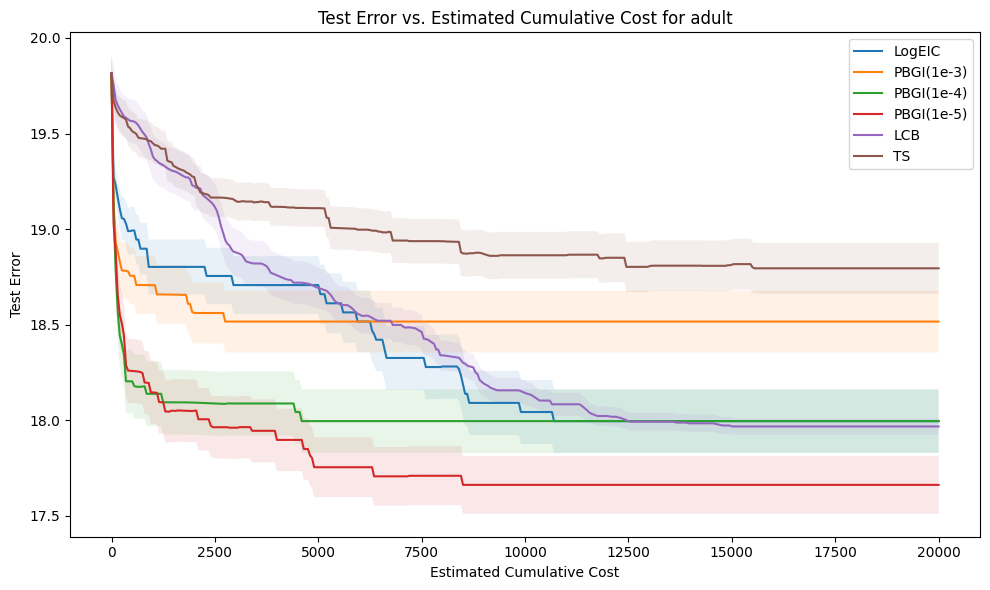

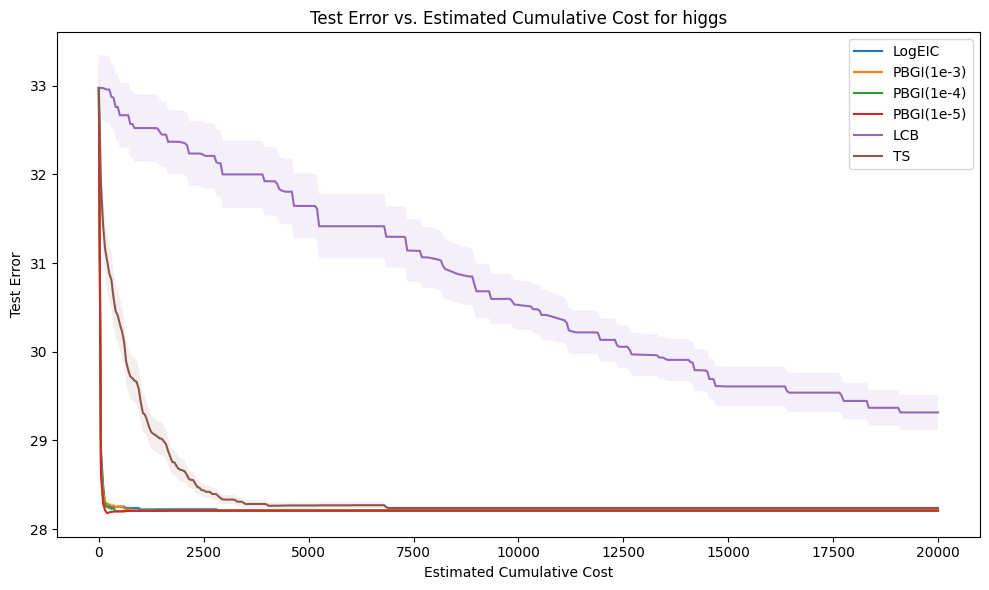

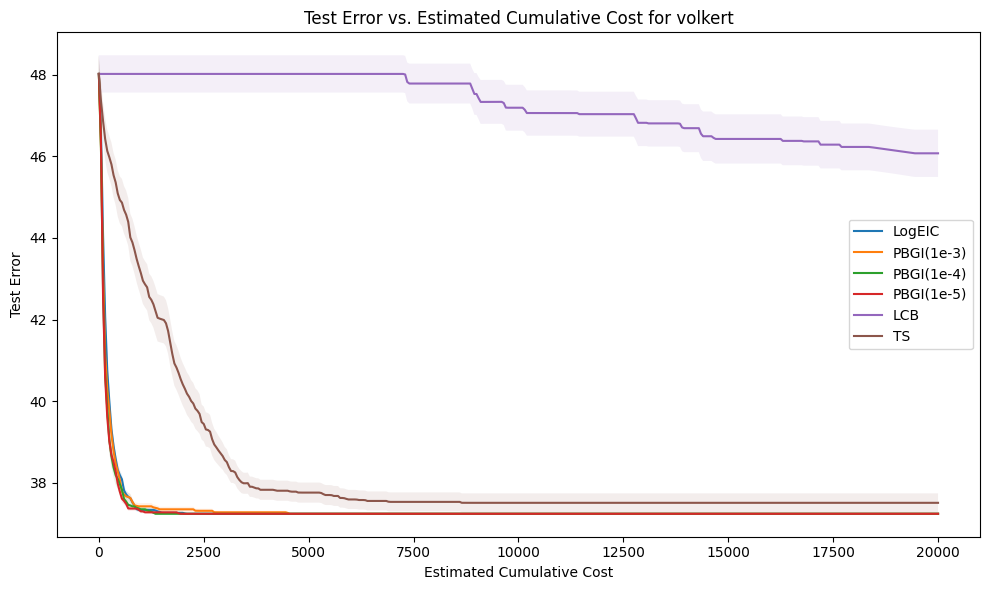

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Define the common estimated cumulative cost grid from 0 to 20000.
cost_grid = np.linspace(0, 20000, 401)

# Loop over each dataset to create one plot per dataset.
for d in dataset_names:
    plt.figure(figsize=(10, 6))
    
    # For each acquisition function within the dataset:
    for a in acquisition_functions.values():
        # List to hold interpolated curves for each seed.
        interpolated_curves = []
        
        # Access arrays from unified structures
        est_cum_cost_array = metrics_per_acq[d][a]["estimated cumulative cost"]
        test_error_array = test_metrics_per_acq[d][a]["final test error"]
        
        # Loop over each seed (assuming the first dimension indexes seeds).
        for seed_id in range(len(est_cum_cost_array)):
            est_cum_cost = np.array(est_cum_cost_array[seed_id])
            test_error = np.array(test_error_array[seed_id])
            
            # Ensure the arrays are sorted by estimated cumulative cost.
            sort_id = np.argsort(est_cum_cost)
            est_cum_cost_sorted = est_cum_cost[sort_id]
            test_error_sorted = test_error[sort_id]
            
            # Interpolate test error to the common cost grid
            interp_test_error = np.interp(cost_grid, est_cum_cost_sorted, test_error_sorted)
            interpolated_curves.append(interp_test_error)
        
        # Stack curves and compute statistics
        interpolated_curves = np.array(interpolated_curves)
        mean_curve = np.mean(interpolated_curves, axis=0)
        std_curve = np.std(interpolated_curves, axis=0)
        sem_curve = std_curve / np.sqrt(interpolated_curves.shape[0])
        
        # Plot
        plt.plot(cost_grid, mean_curve, label=a)
        plt.fill_between(cost_grid, mean_curve - sem_curve, mean_curve + sem_curve, alpha=0.1)
    
    # Final touches
    plt.title(f"Test Error vs. Estimated Cumulative Cost for {d}")
    plt.xlabel("Estimated Cumulative Cost")
    plt.ylabel("Test Error")
    plt.legend()
    plt.tight_layout()
    plt.show()

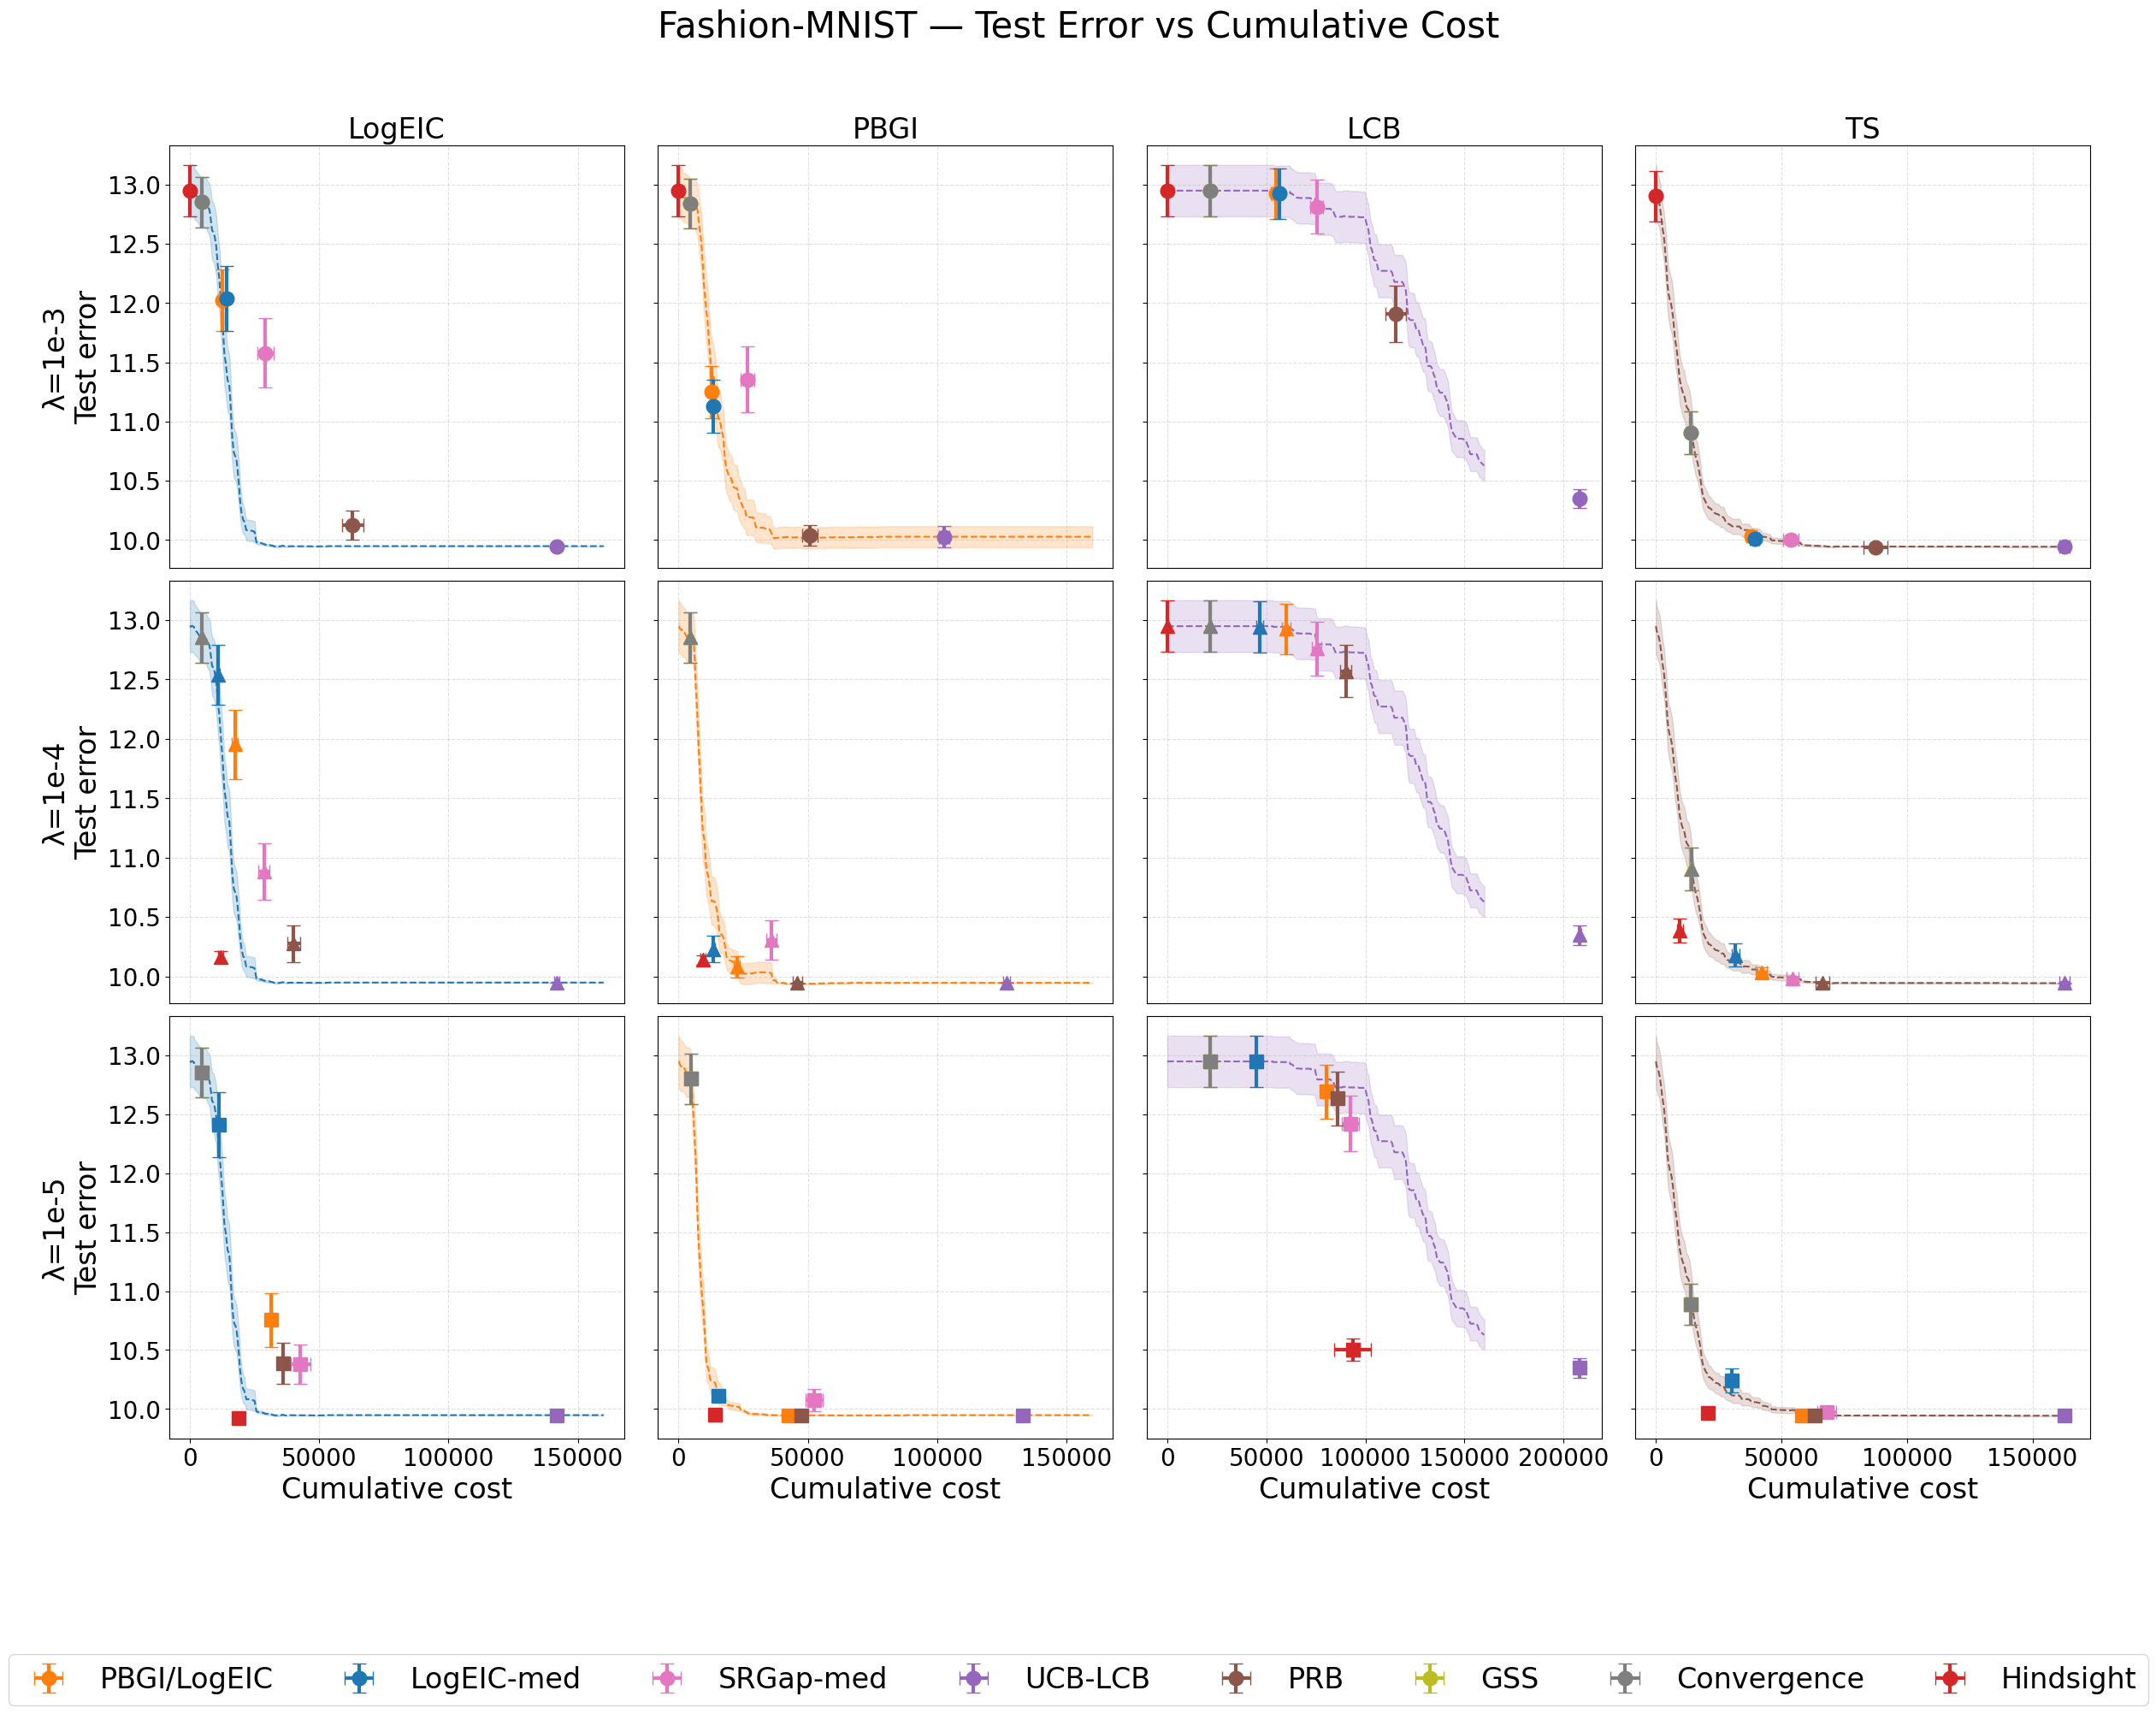

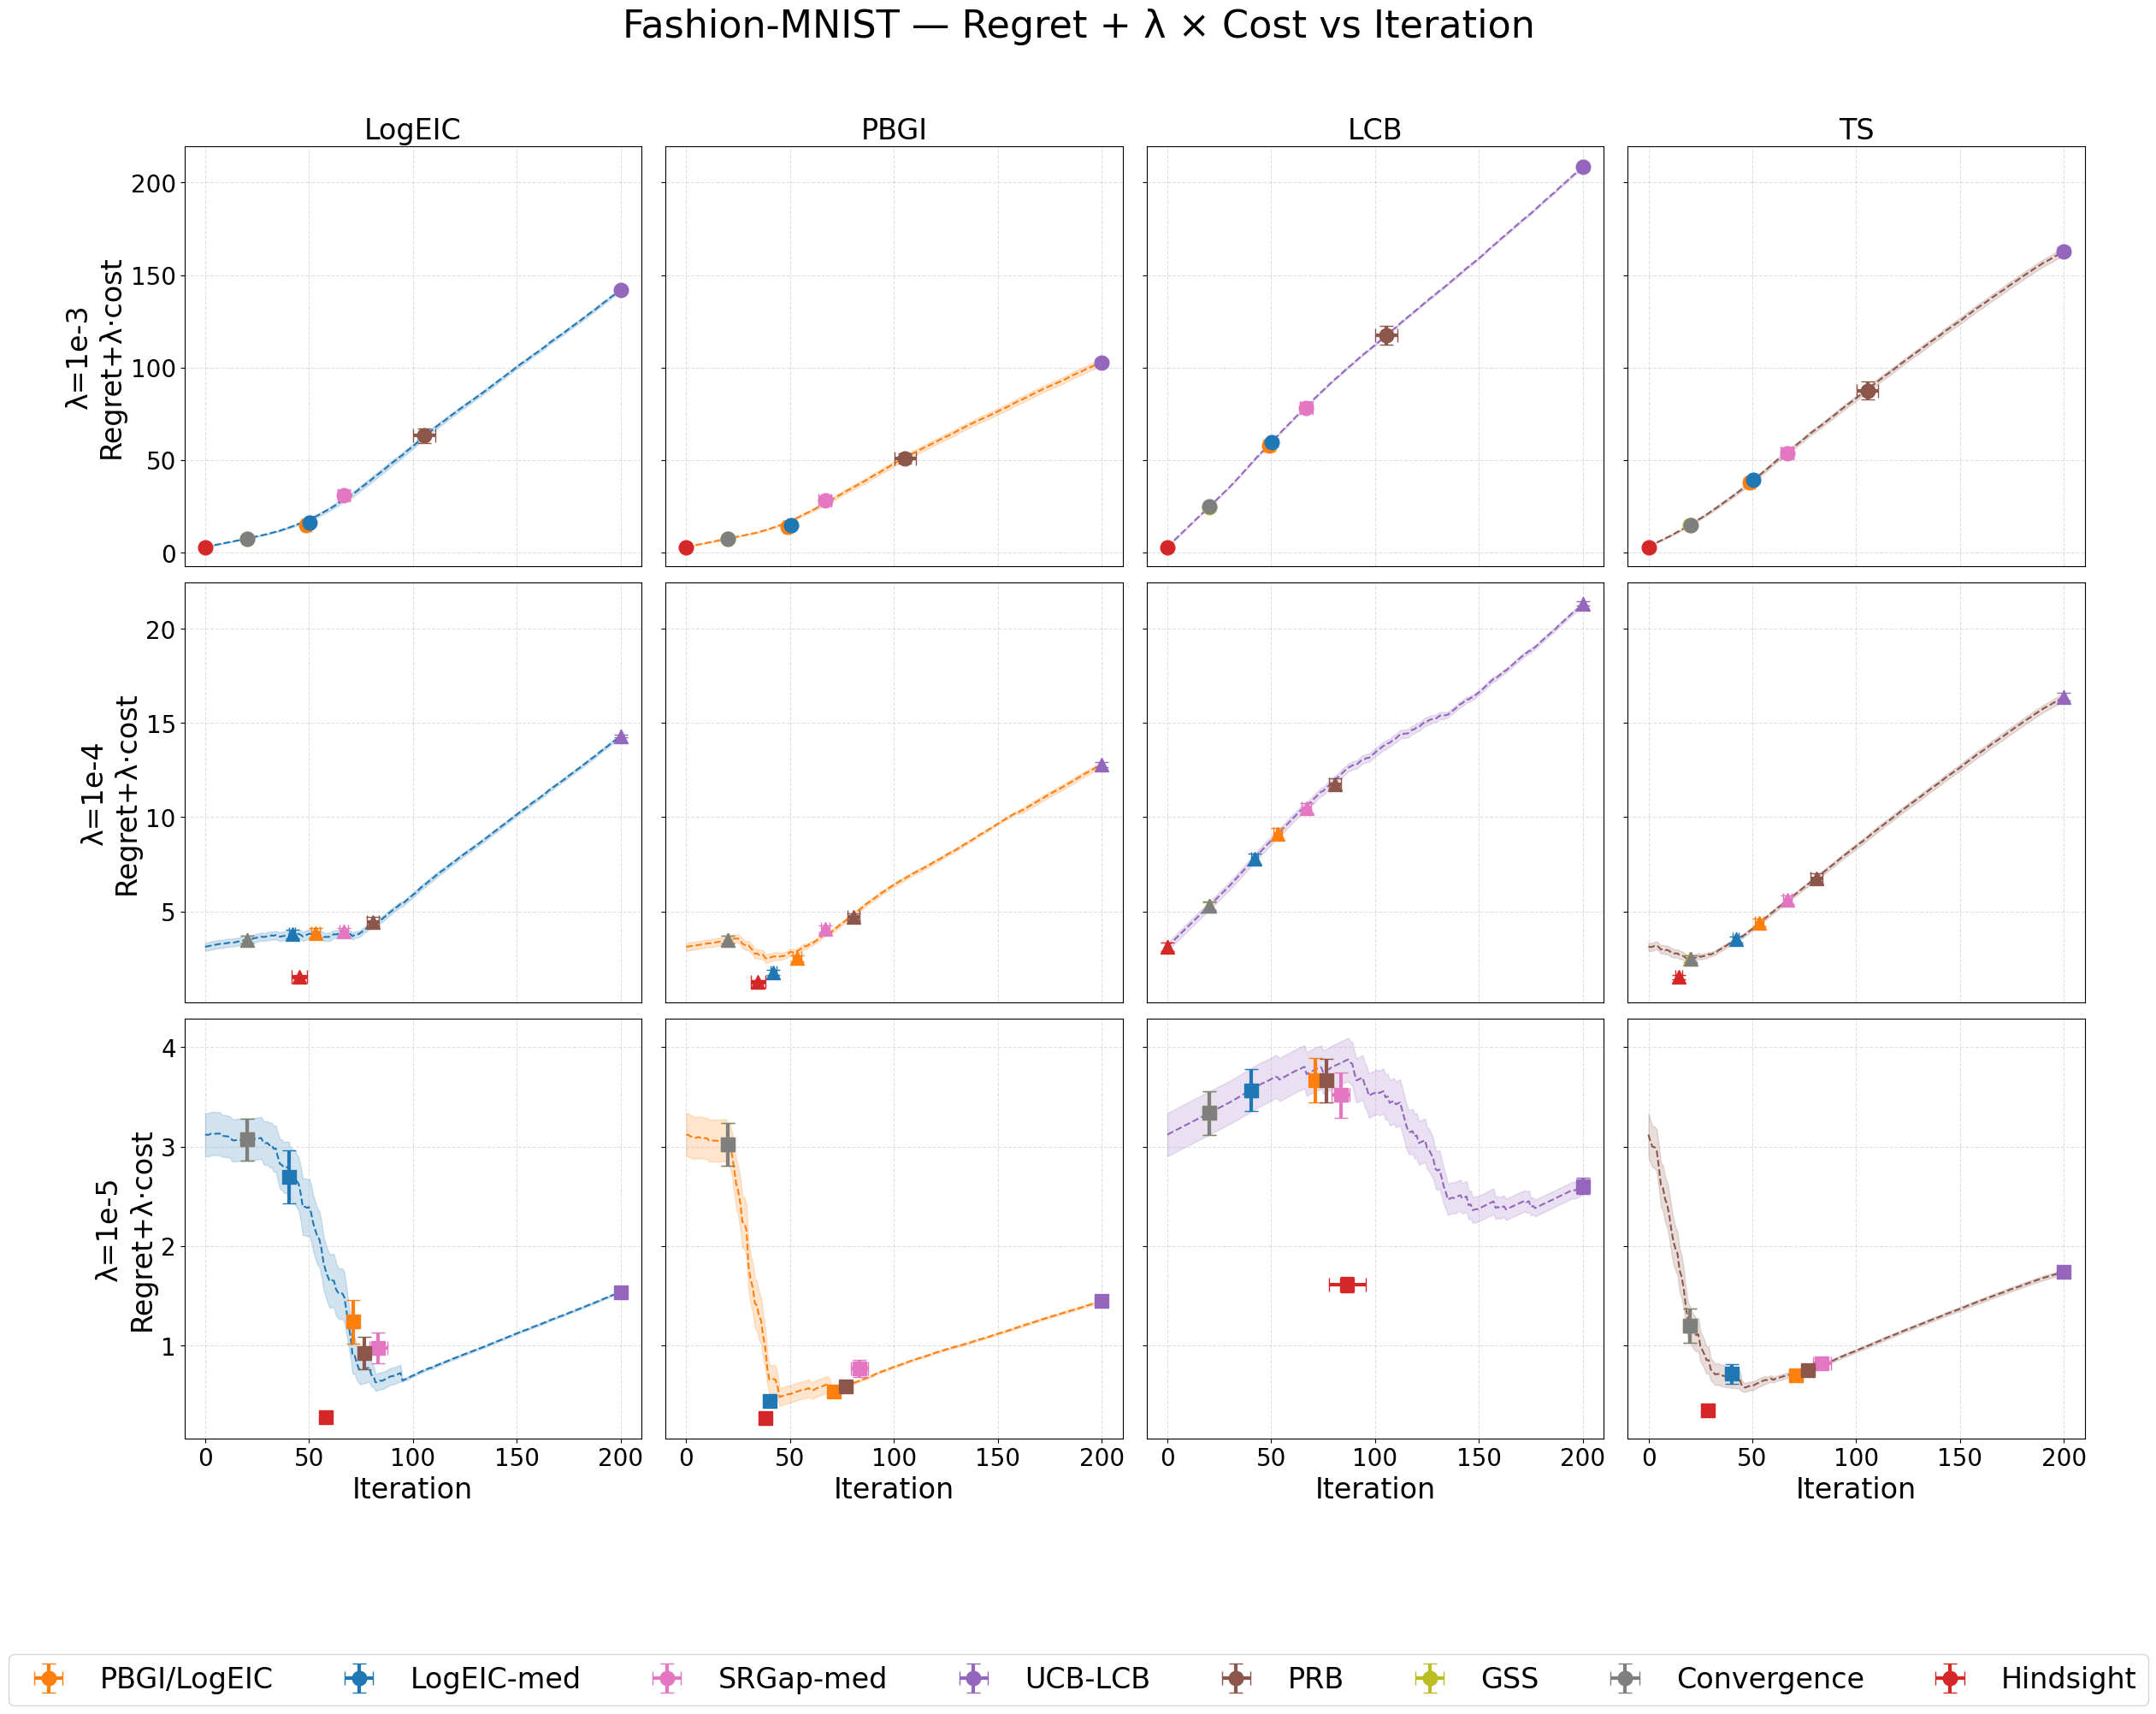

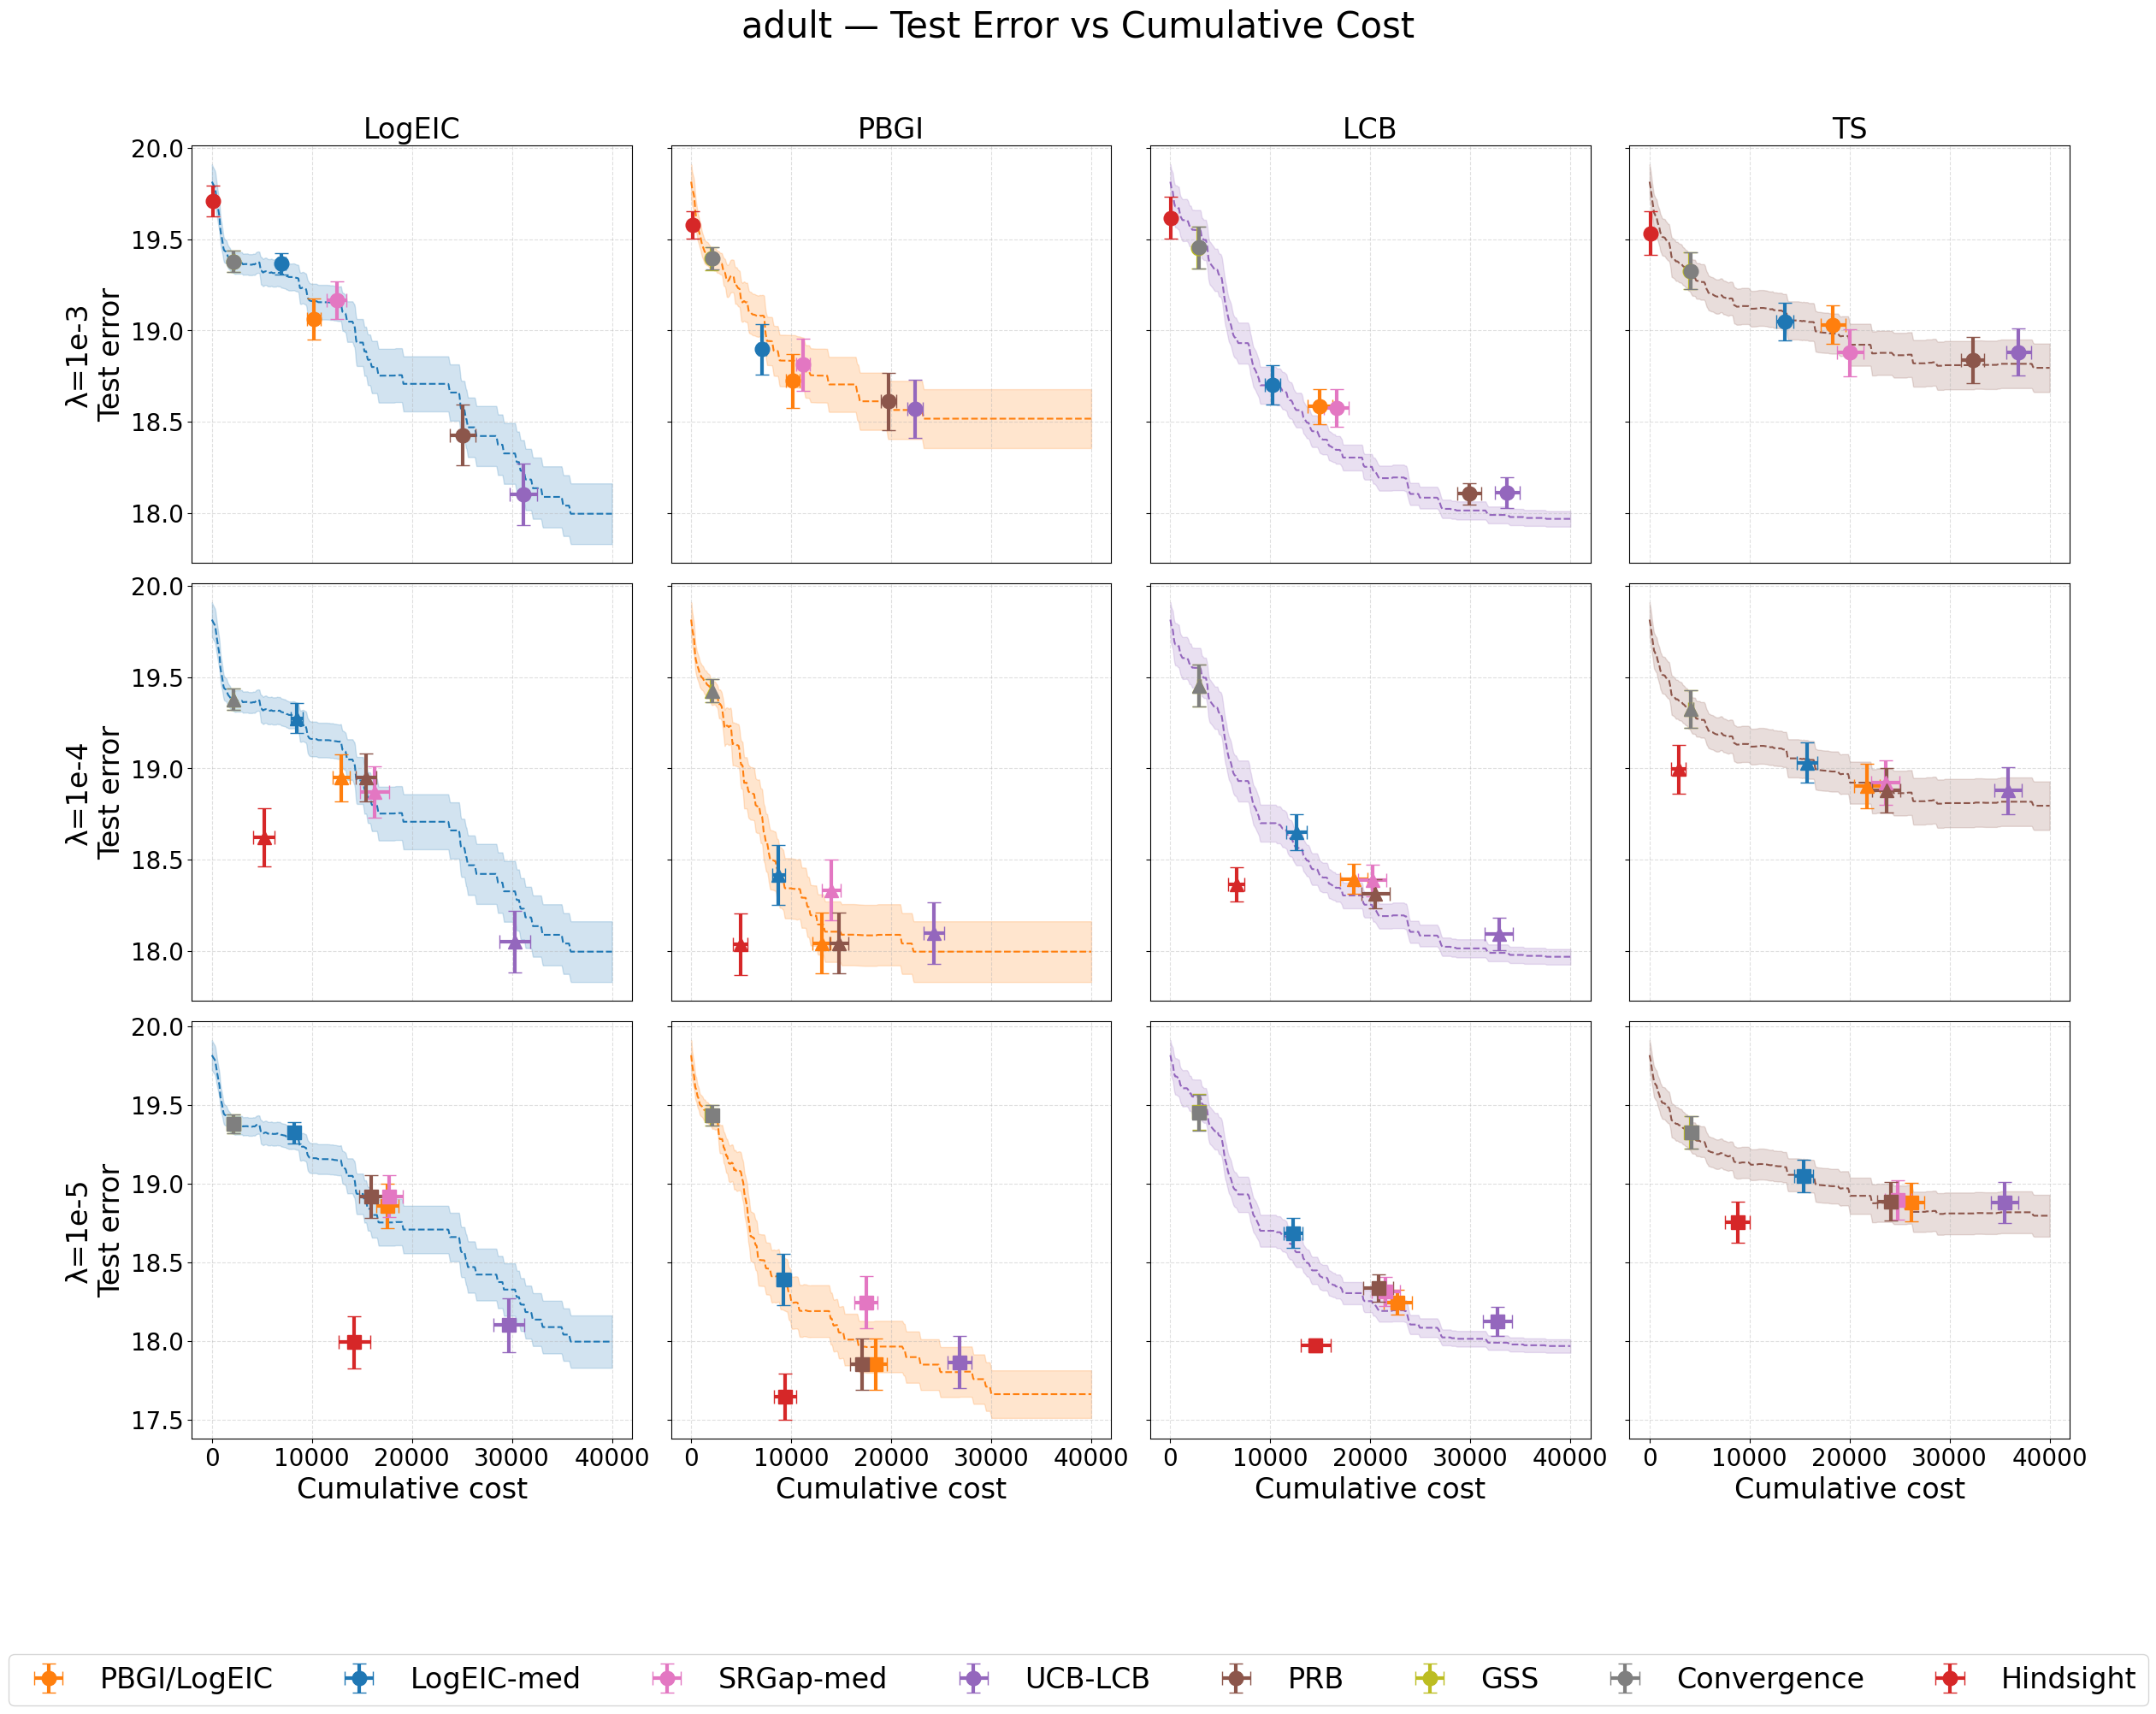

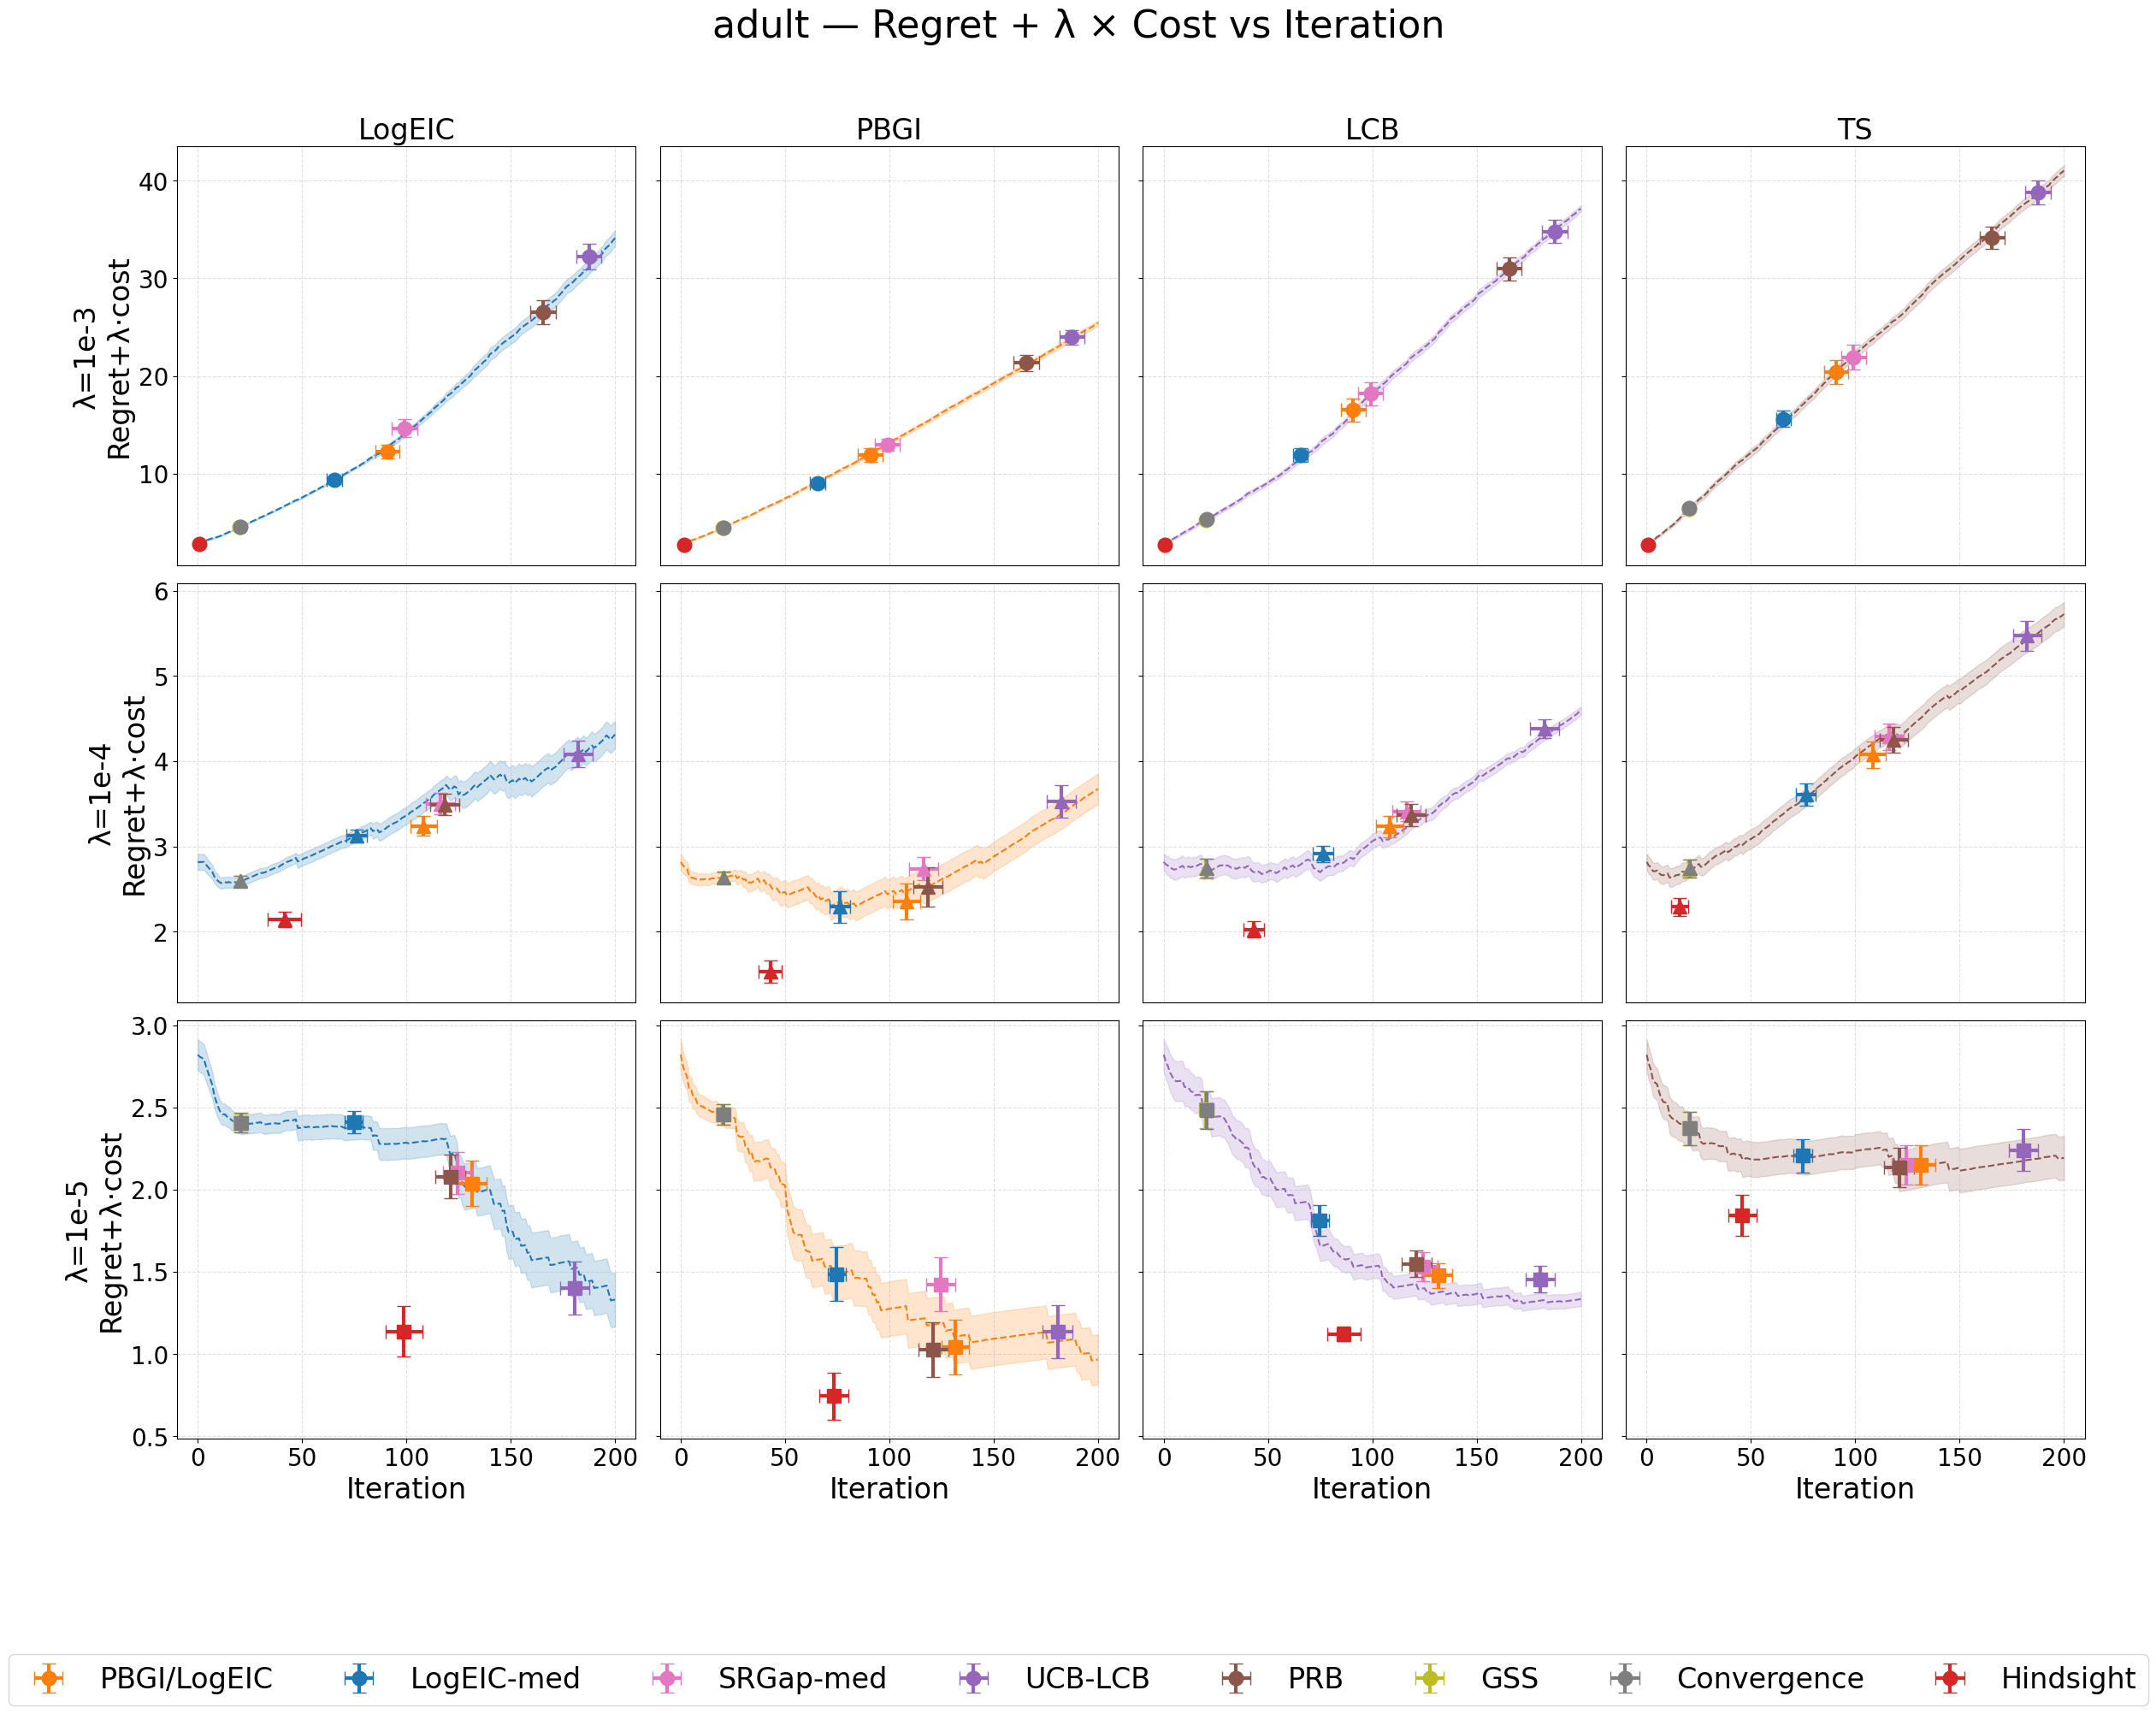

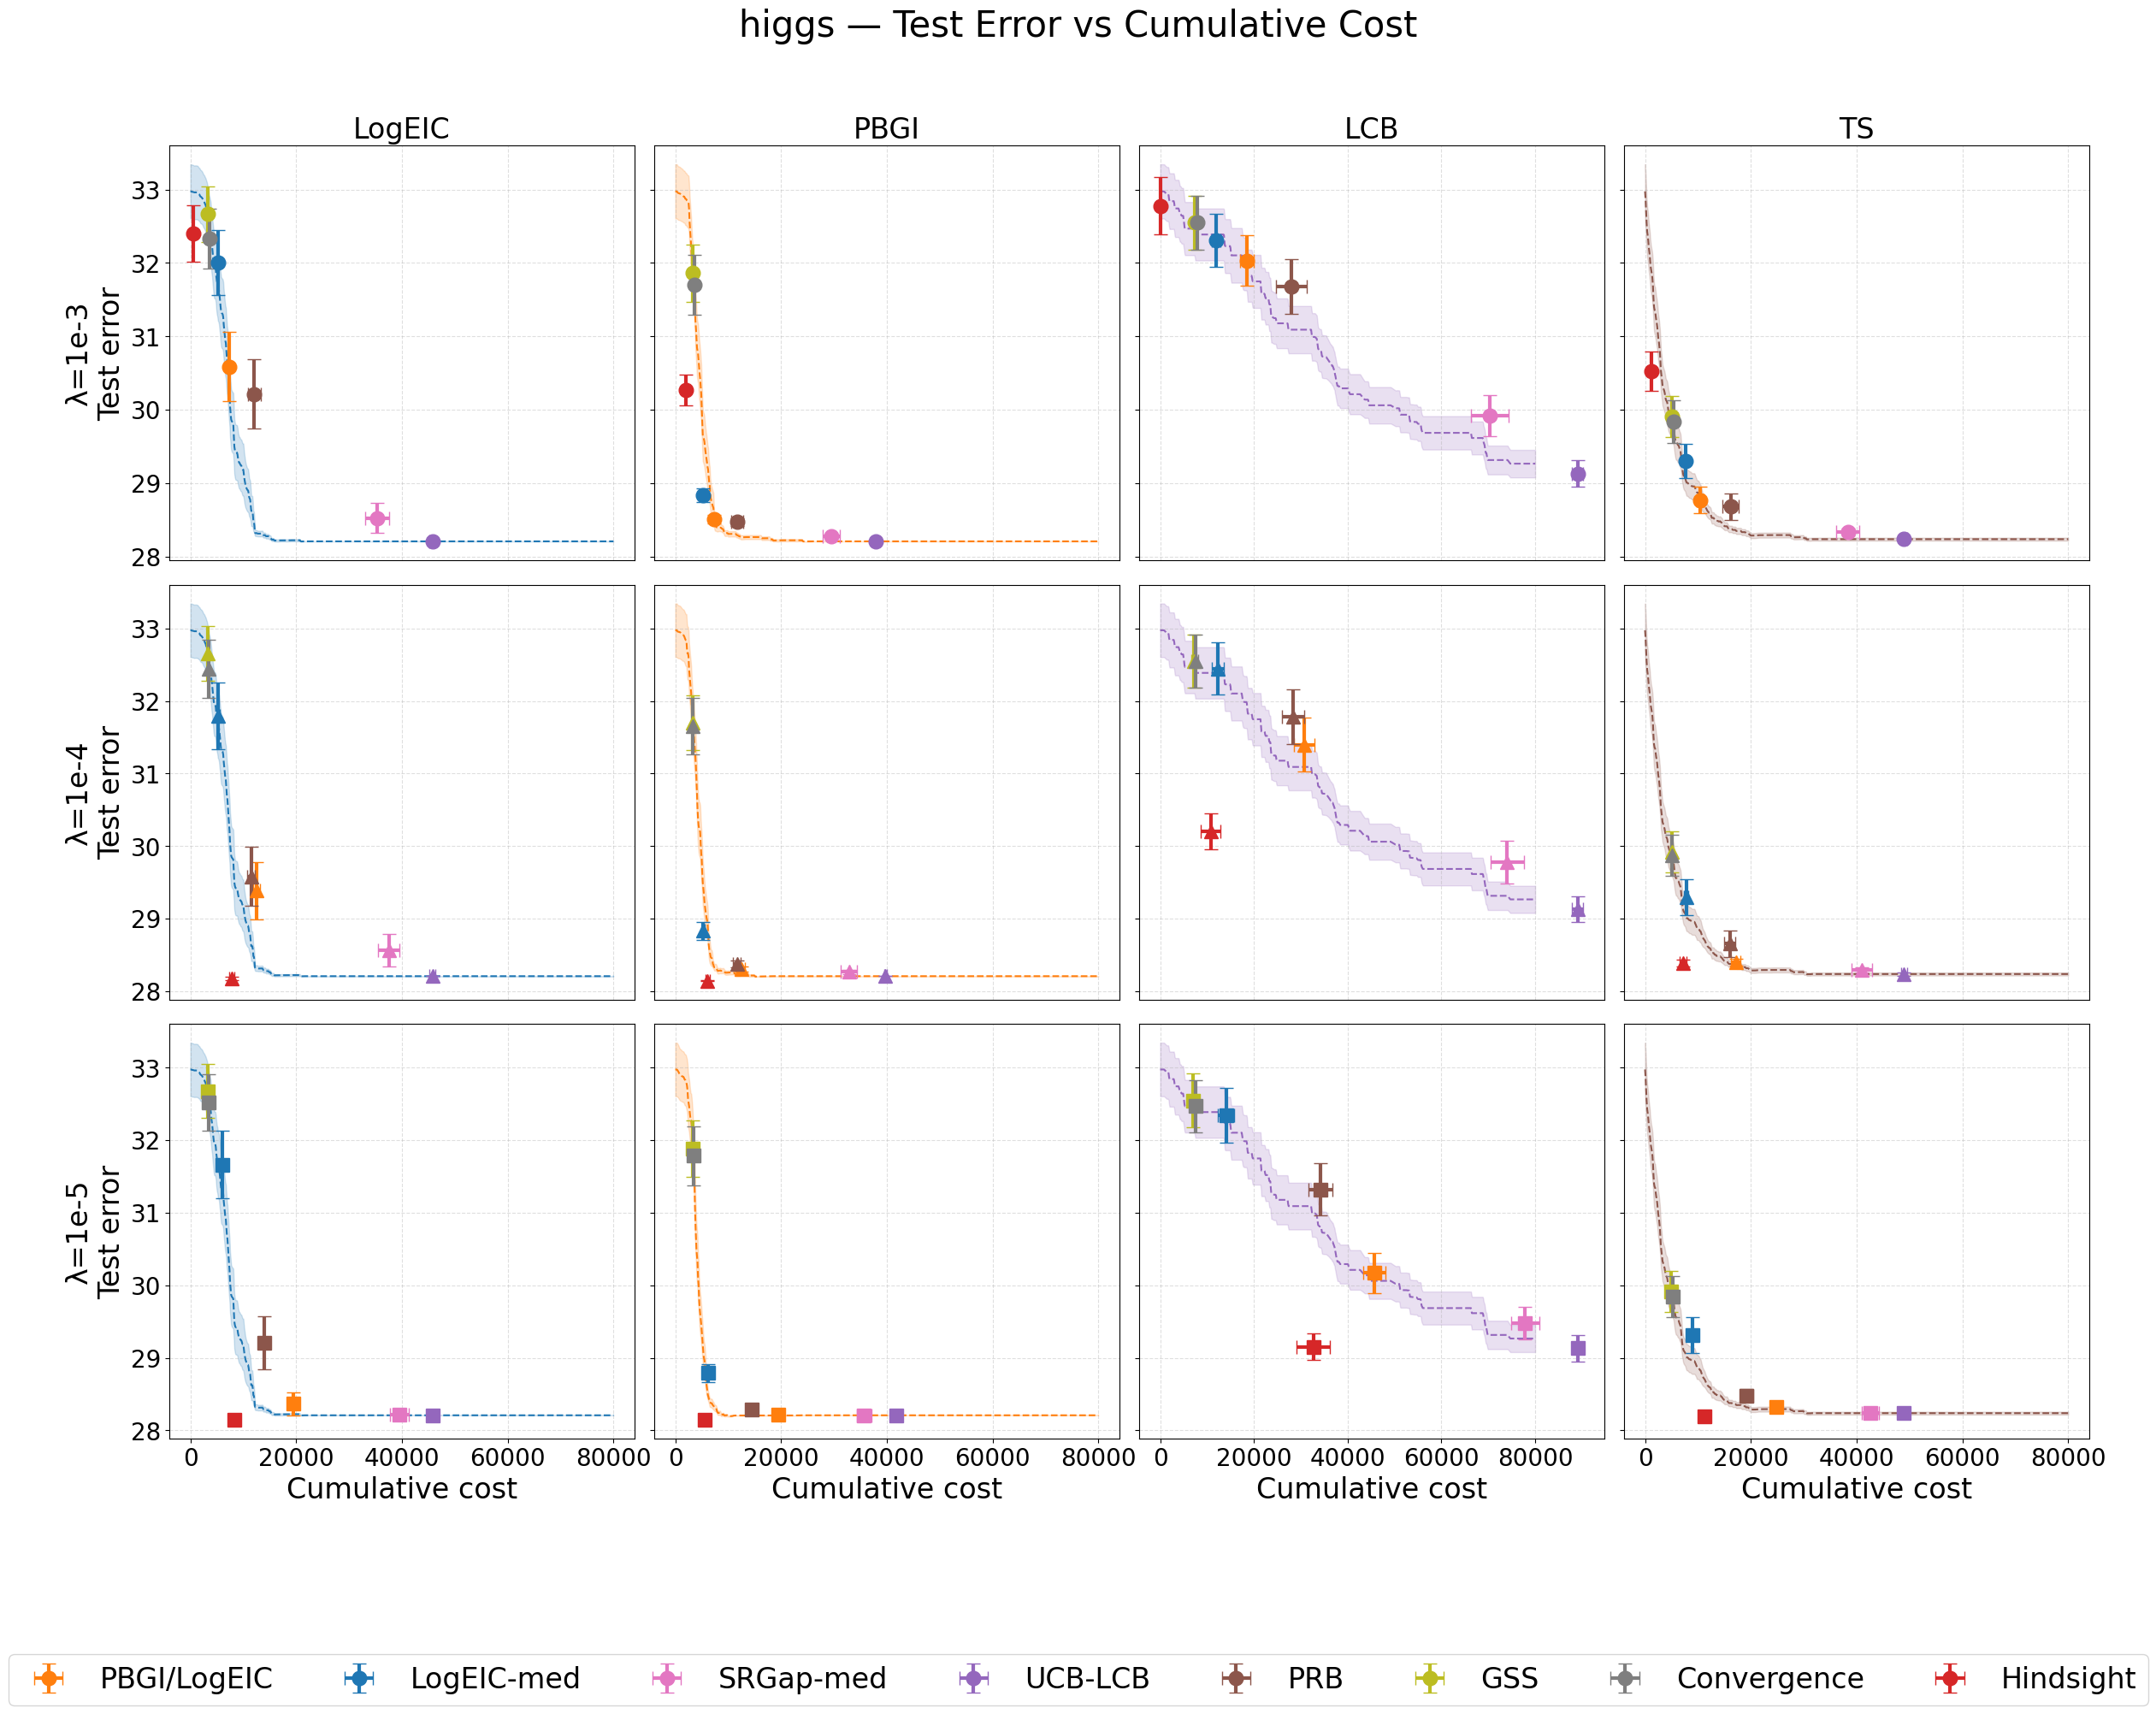

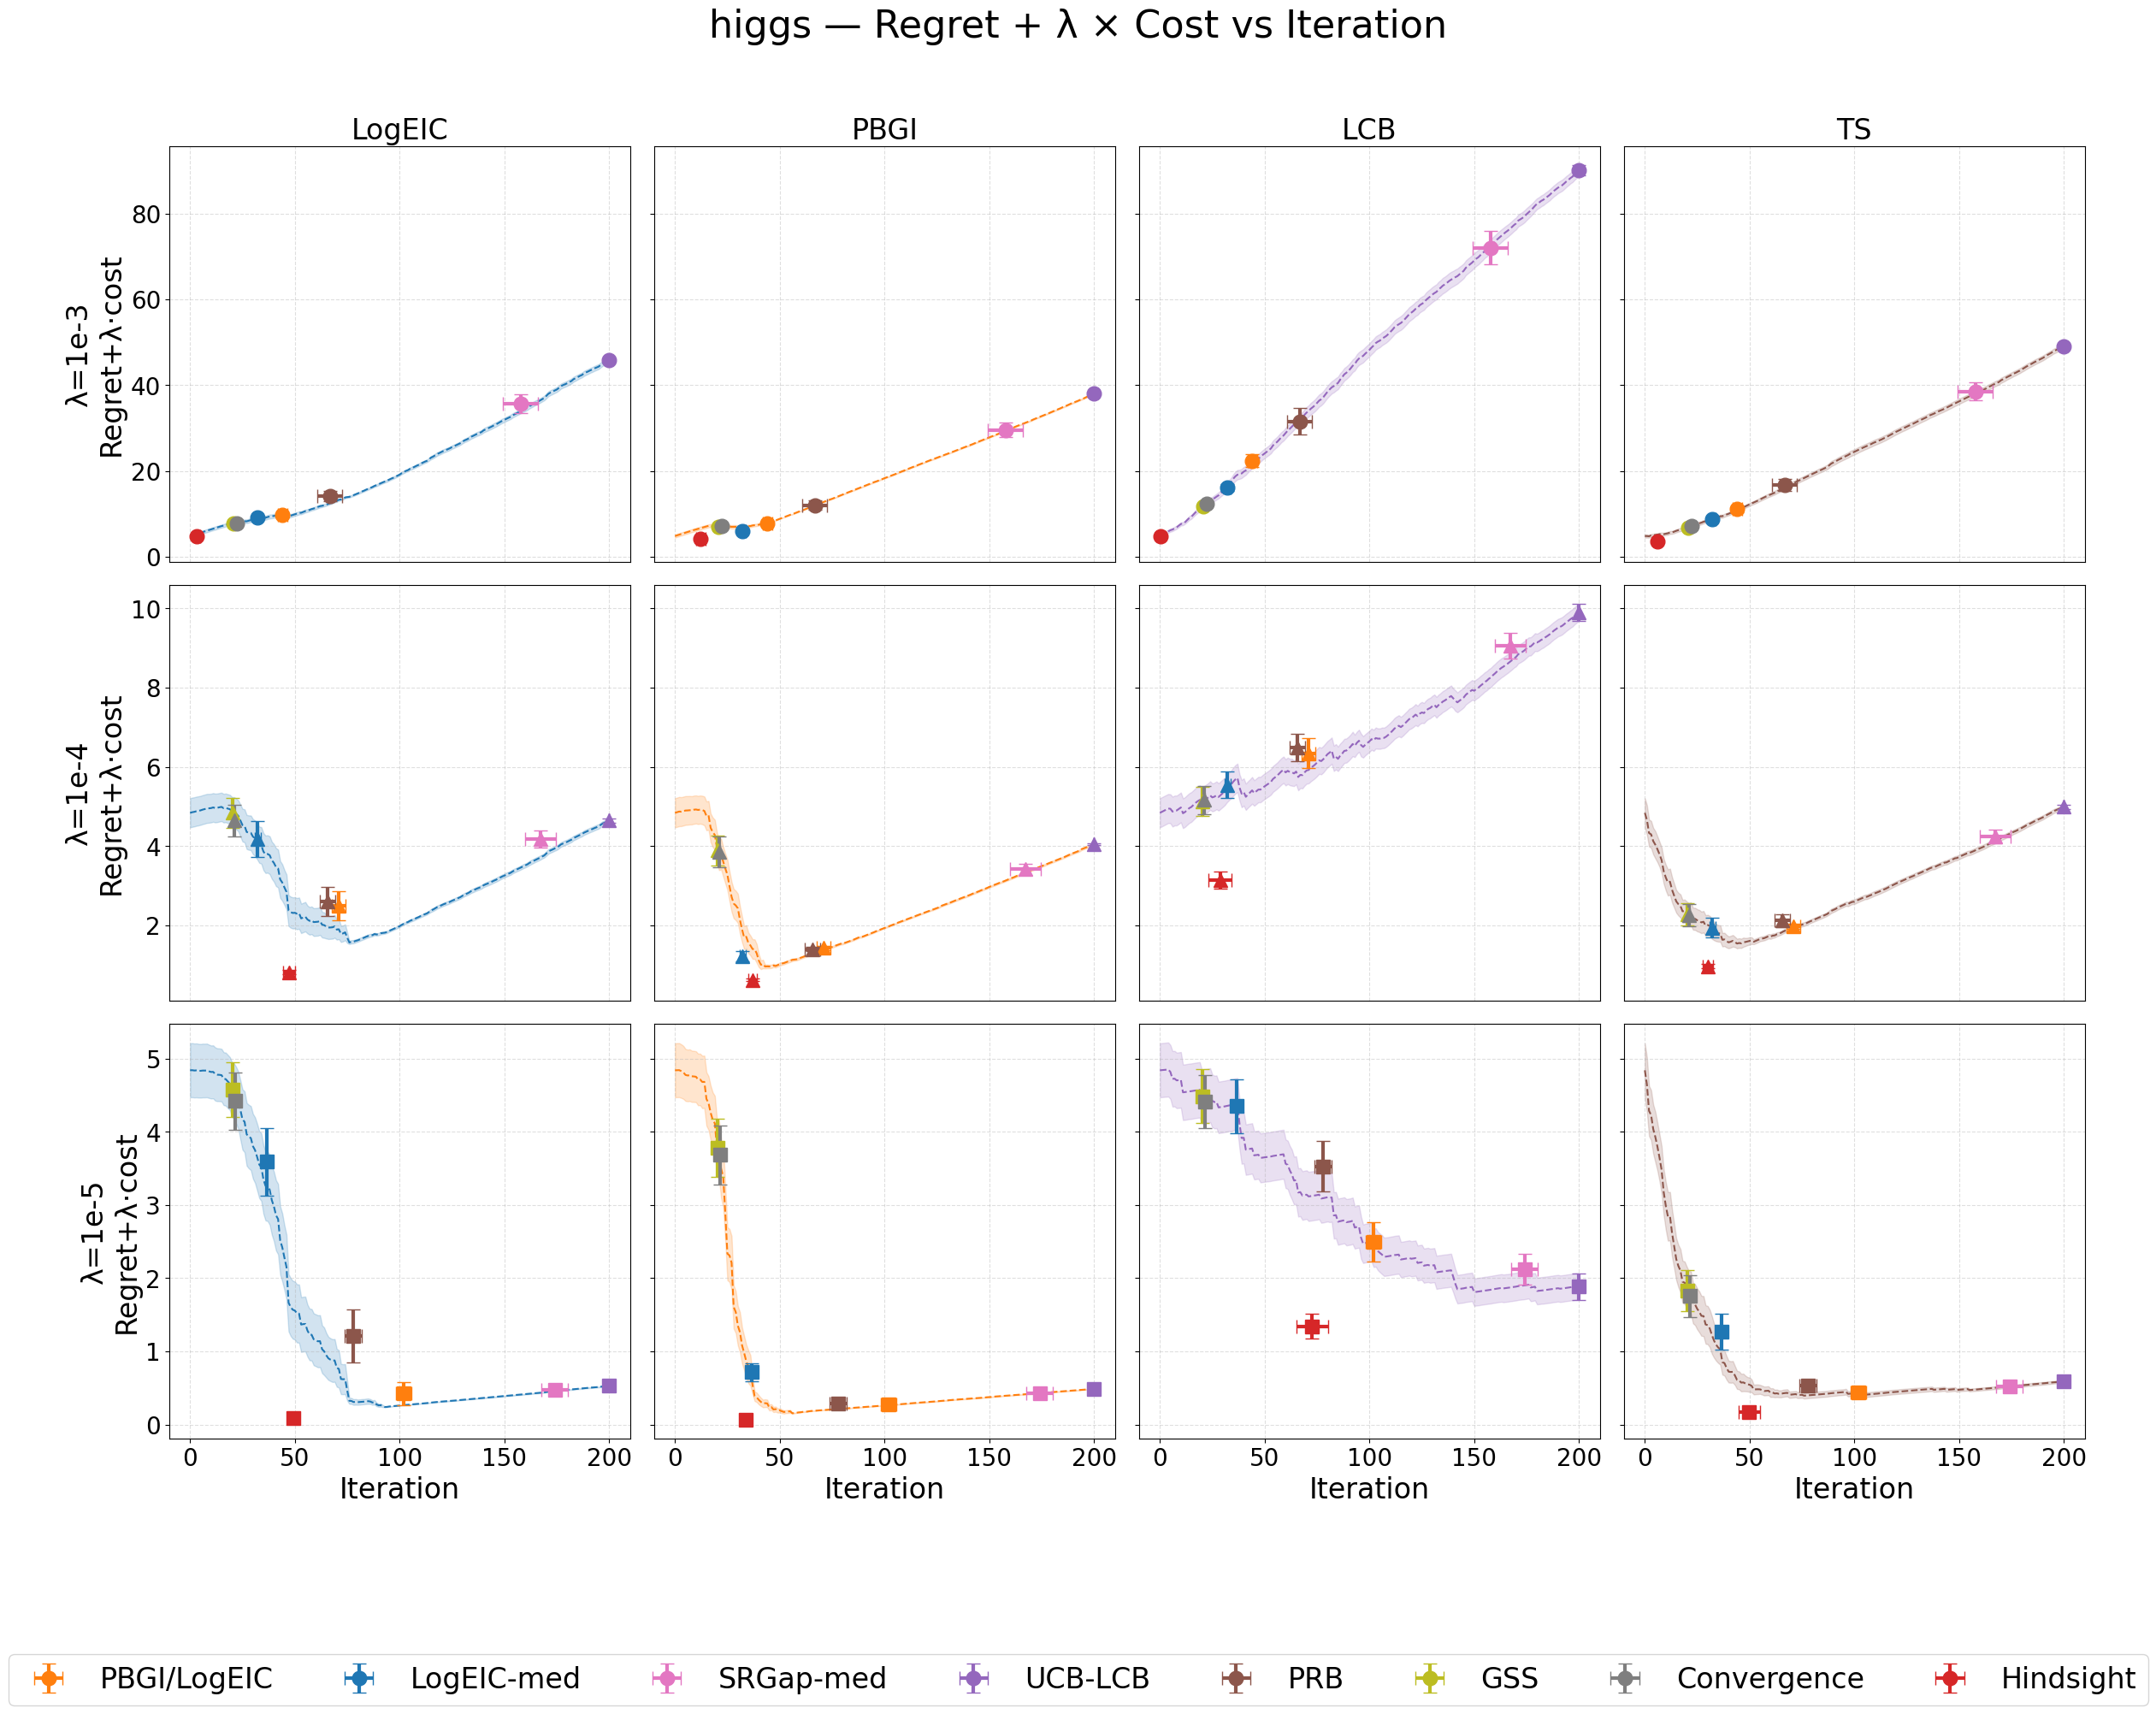

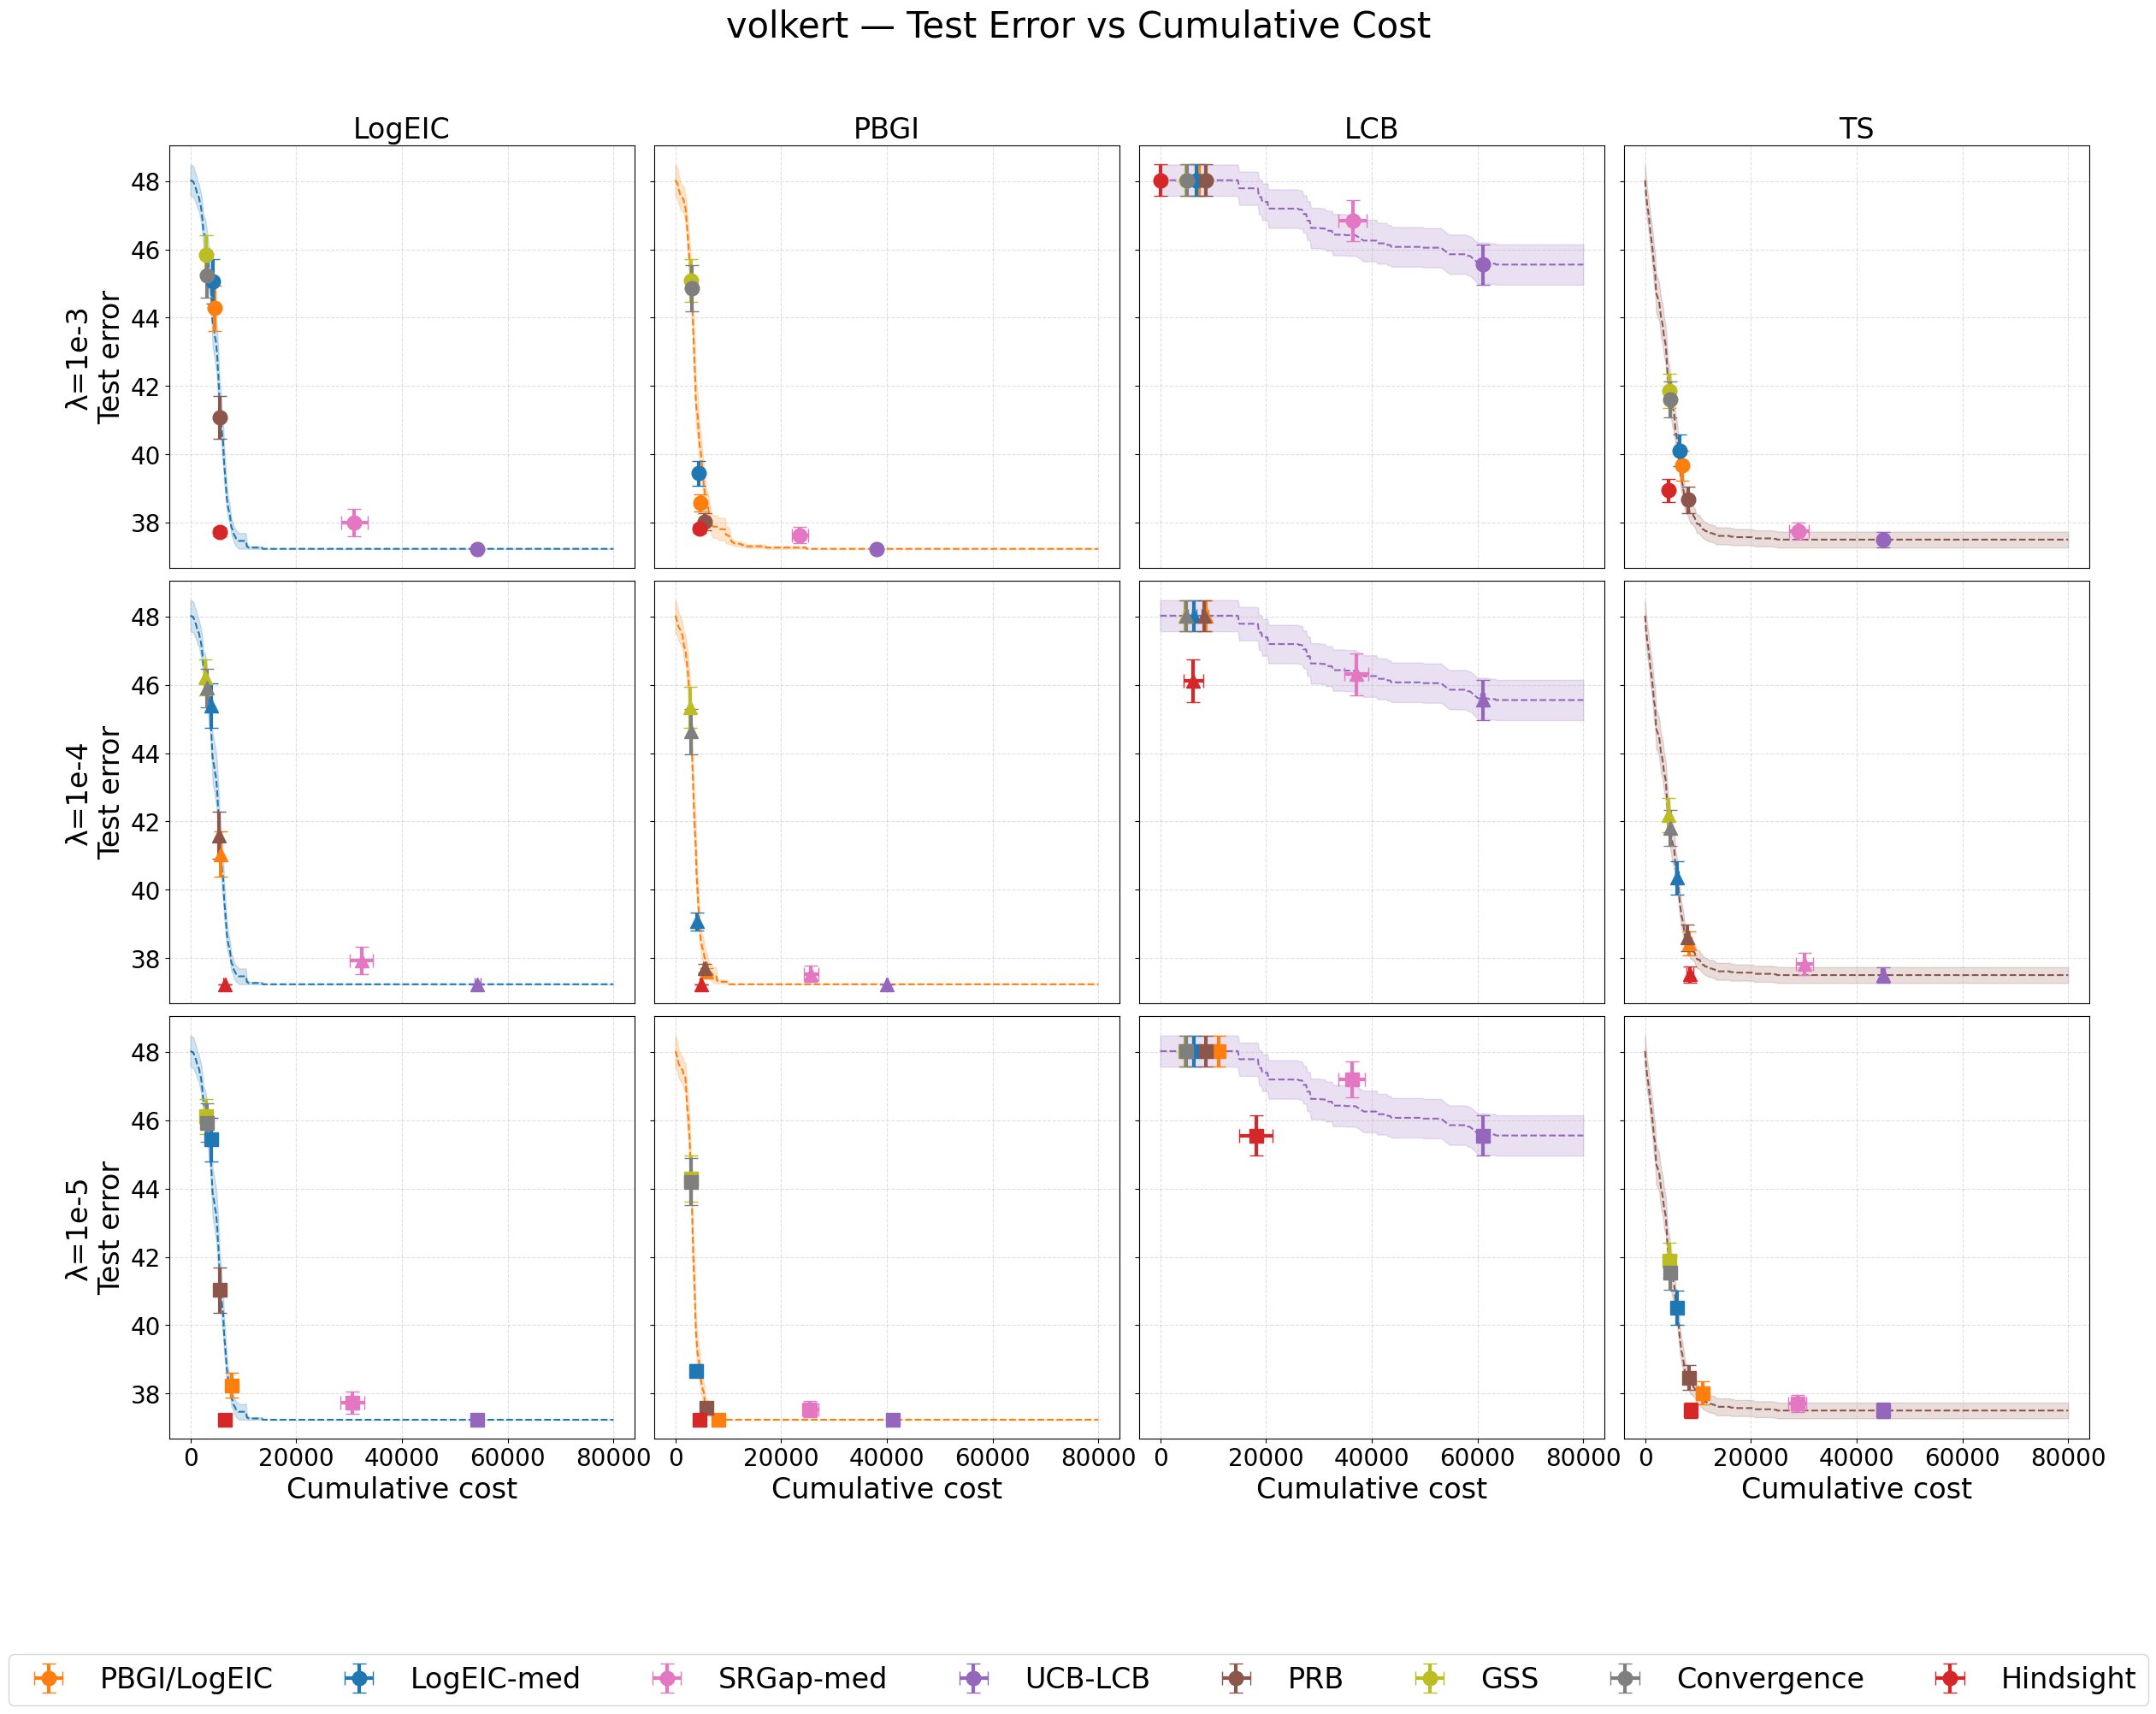

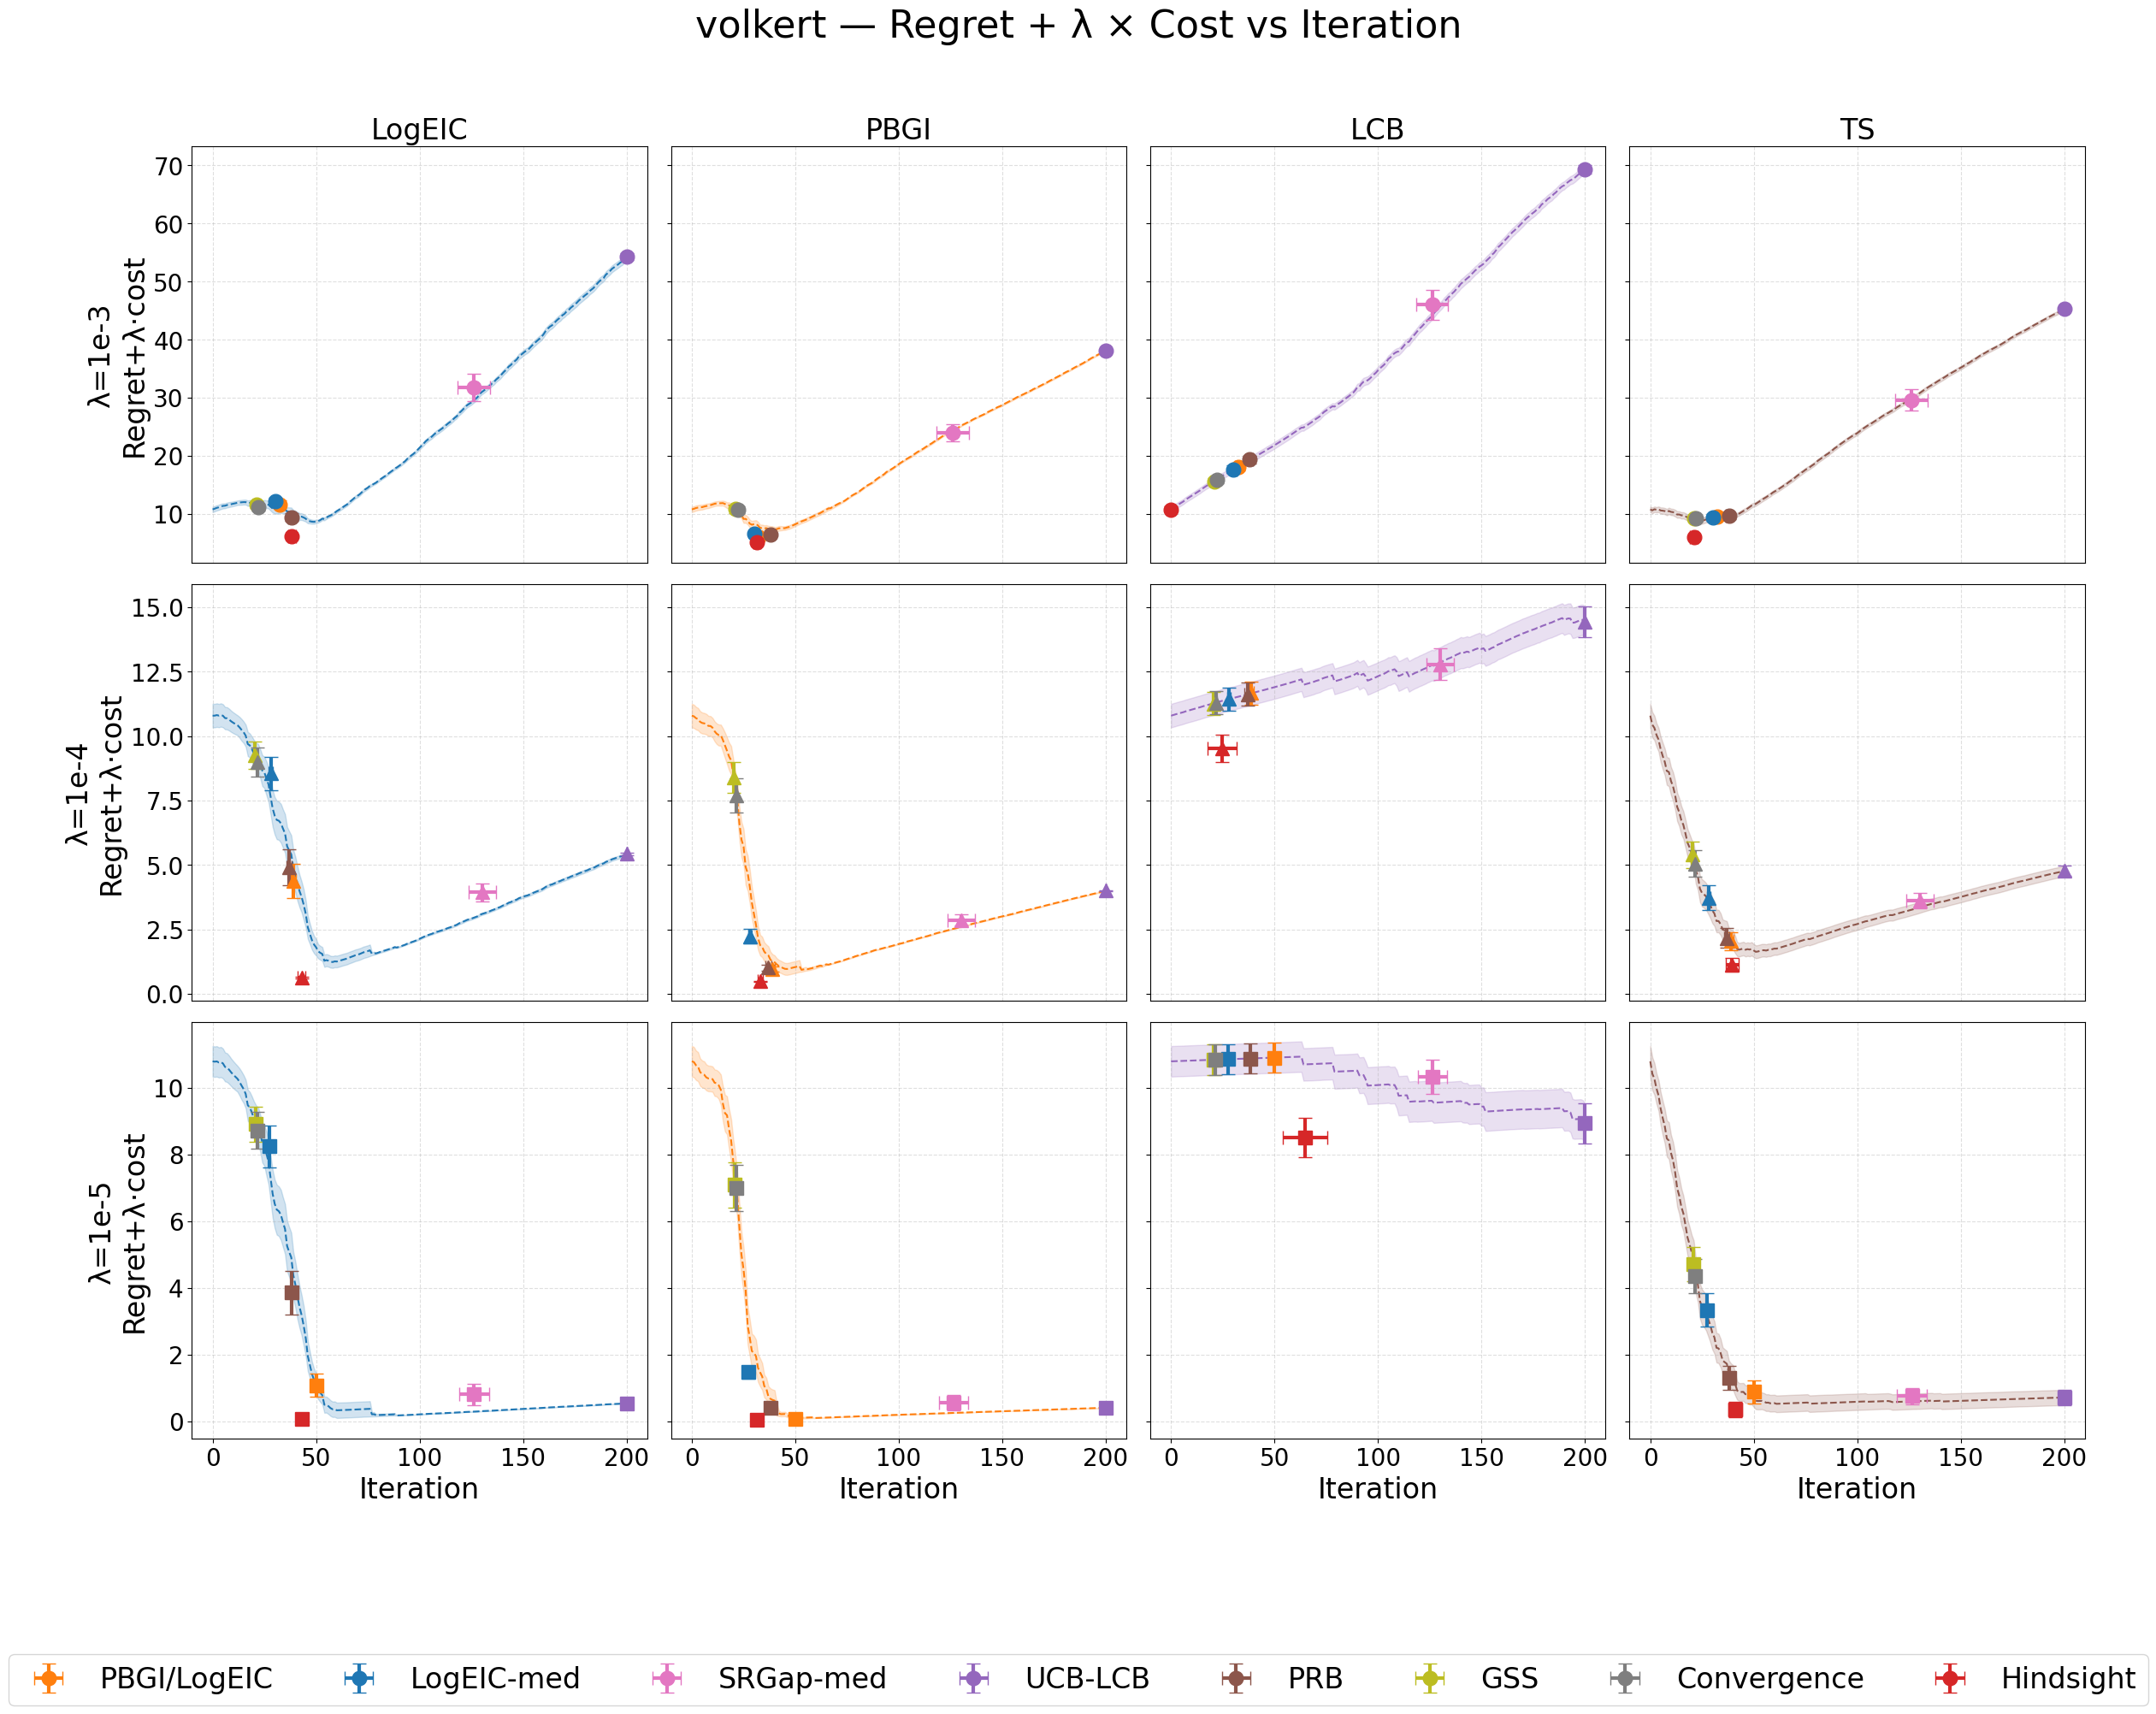

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# === User‐provided data and helper functions (assumed to exist) ===
# metrics_per_acq[d][acq_key]["cumulative cost"]
# test_metrics_per_acq[d][acq_key]["final test error"]
# bench.query_best_final(dataset, "final_test_accuracy", "final_test_accuracy", 0)

# === Config ===
dataset_names = ['Fashion-MNIST', 'adult', 'higgs', 'volkert']
lambdas       = [1e-3, 1e-4, 1e-5]
acq_order     = ['LogEIC', 'PBGI', 'LCB', 'TS']
init          = 20

x_limit_per_dataset = {
    "Fashion-MNIST": 80000,
    "adult":         40000,
    "higgs":         40000,
    "volkert":       40000
}
cost_limit_per_dataset = {
    "Fashion-MNIST": 160000,
    "adult":         40000,
    "higgs":         80000,
    "volkert":       80000
}

# === Color and marker settings ===
color_dict = {
    'LogEIC':      'tab:blue',
    'LogEIC-med':  'tab:blue',
    'PBGI(1e-3)':  'tab:orange',
    'PBGI(1e-4)':  'tab:orange',
    'PBGI(1e-5)':  'tab:orange',
    'LCB':         'tab:purple',
    'UCB-LCB':     'tab:purple',
    'SRGap-med':   'tab:pink',
    'TS':          'tab:brown',
    'PRB':         'tab:brown',
    'GSS':         'tab:olive',
    'Convergence': 'tab:gray',
    'Hindsight':   'tab:red'
}
marker_dict = {
    '1e-3': 'o',
    '1e-4': '^',
    '1e-5': 's'
}

# === Build stopping_rules for each λ ===
stopping_rules = []
for lam in lambdas:
    lam_str   = f"1e-{int(round(-np.log10(lam)))}"  # “1e-3”, “1e-4”, “1e-5”
    fixed_acq = f"PBGI({lam_str})"
    marker    = marker_dict[lam_str]

    templates = [
        {
            'stp_key':      'PBGI',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, lam=lam, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa][f"{fa} acq"][seed][i] >=
                metrics_per_acq[d][fa]["current best observed"][seed][i - 1]
            ))
        },
        # {
        #     'stp_key':      'LogEIC',
        #     'is_hindsight': False,
        #     'condition_fn': (lambda i, seed, d, lam=lam, fa=fixed_acq: (
        #         i >= init and
        #         metrics_per_acq[d][fa]["LogEIC acq"][seed][i] <= np.log(lam)
        #     ))
        # },
        {
            'stp_key':      'LogEIC-med',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa]["LogEIC acq"][seed][i] <= (
                    np.log(0.01) +
                    np.nanmedian(metrics_per_acq[d][fa]["LogEIC acq"][seed][1:21])
                )
            ))
        },
        {
            'stp_key':      'SRGap-med',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa]["exp min regret gap"][seed][i] <=
                0.1 * np.nanmedian(
                    metrics_per_acq[d][fa]["exp min regret gap"][seed][1:21]
                )
            ))
        },
        {
            'stp_key':      'UCB-LCB',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa]["regret upper bound"][seed][i] <= 0.01
            ))
        },
        {
            'stp_key':      'PRB',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa]["PRB"][seed][i] >= 0.95
            ))
        },
        {
            'stp_key':      'GSS',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and (
                    (np.nanpercentile(
                        metrics_per_acq[d][fa]["current best observed"][seed][:i+1], 75
                     ) -
                     np.nanpercentile(
                        metrics_per_acq[d][fa]["current best observed"][seed][:i+1], 25
                     )) == 0
                ) or (
                    ((metrics_per_acq[d][fa]["current best observed"][seed][i - 5] -
                      metrics_per_acq[d][fa]["current best observed"][seed][i]) /
                     (np.nanpercentile(
                        metrics_per_acq[d][fa]["current best observed"][seed][:i+1], 75
                     ) -
                      np.nanpercentile(
                        metrics_per_acq[d][fa]["current best observed"][seed][:i+1], 25
                     ))
                    ) <= 0.01
                )
            ))
        },
        {
            'stp_key':      'Convergence',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa]["current best observed"][seed][i] ==
                metrics_per_acq[d][fa]["current best observed"][seed][i - 5]
            ))
        },
        {
            'stp_key':      'Hindsight',
            'is_hindsight': True,
            'condition_fn': None
        }
    ]

    for temp in templates:
        rule = {
            'acq_key':      fixed_acq,
            'stp_key':      temp['stp_key'],
            'is_hindsight': temp['is_hindsight'],
            'marker':       marker,
            'color':        color_dict.get(temp['stp_key'], color_dict[fixed_acq]),
            'label':        'PBGI/LogEIC' if temp['stp_key'] == 'PBGI' else temp['stp_key']
        }
        if temp['condition_fn'] is not None:
            rule['condition_fn'] = temp['condition_fn']
        stopping_rules.append(rule)

# === Plotting ===
for d in dataset_names:
    best_acc   = bench.query_best_final(d, "final_test_accuracy", "final_test_accuracy", 0)
    best_error = 100. - best_acc

    # === 1) Test error vs cumulative cost ===
    fig, axes = plt.subplots(3, 4, figsize=(24, 18), sharey="row")
    fig.suptitle(f"{d} — Test Error vs Cumulative Cost", fontsize=30)
    for i, lam in enumerate(lambdas):
        lam_str = f"1e-{int(round(-np.log10(lam)))}"

        for j in range(4):
            acq = acq_order[j]
            fixed_acq = f"PBGI({lam_str})" if acq == 'PBGI' else acq
            ax = axes[i, j]

            # === Mean test error curve ===
            cost_grid = np.linspace(0, cost_limit_per_dataset[d], 801)
            curves = []
            for seed in range(len(metrics_per_acq[d][fixed_acq]["cumulative cost"])):
                c = np.array(metrics_per_acq[d][fixed_acq]["cumulative cost"][seed])
                e = np.array(test_metrics_per_acq[d][fixed_acq]["final test error"][seed])
                idx = np.argsort(c)
                curves.append(np.interp(cost_grid, c[idx], e[idx]))
            curves = np.vstack(curves)
            mean_c = curves.mean(axis=0)
            sem_c  = curves.std(axis=0) / np.sqrt(curves.shape[0])

            ax.plot(cost_grid, mean_c, linestyle='--', color=color_dict[fixed_acq])
            ax.fill_between(cost_grid, mean_c - sem_c, mean_c + sem_c, color=color_dict[fixed_acq], alpha=0.2)

            # === Stopping rule overlays ===
            for rule in stopping_rules:
                # Only use rules from the correct lambda
                if rule['acq_key'] != f"PBGI({lam_str})":
                    continue

                stop_vals = []
                stop_costs = []
                for seed in range(curves.shape[0]):
                    errs = test_metrics_per_acq[d][fixed_acq]["final test error"][seed]
                    costs = metrics_per_acq[d][fixed_acq]["cumulative cost"][seed]
                    if rule['is_hindsight']:
                        regs = np.array(errs) - best_error + lam * np.array(costs)
                        idx = np.argmin(regs)
                    else:
                        idx = next((k for k in range(init, len(errs)) if rule['condition_fn'](k, seed, d)), len(errs) - 1)
                    stop_vals.append(errs[idx])
                    stop_costs.append(costs[idx])

                mx = np.mean(stop_costs)
                my = np.mean(stop_vals)
                sx = np.std(stop_costs) / np.sqrt(len(stop_costs))
                sy = np.std(stop_vals) / np.sqrt(len(stop_vals))

                ax.errorbar(mx, my, xerr=sx, yerr=sy,
                            fmt=rule['marker'],
                            markersize=12,
                            linewidth=3,
                            color=rule['color'],
                            capsize=6,
                            label=rule['label'])

            if i == 0:
                ax.set_title(acq, fontsize=24)  # only first row

            if j == 0:
                ax.set_ylabel(f"λ={lam_str}\nTest error", fontsize=24)
            if i == 2:
                ax.set_xlabel("Cumulative cost", fontsize=24)
            ax.tick_params(axis='both', which='major', labelsize=20)
            if i != 2:
                ax.set_xticklabels([])
                ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
            ax.grid(True, linestyle='--', alpha=0.4)

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels,
               loc='upper center',
               bbox_to_anchor=(0.5, -0.08),
               ncol=len(stopping_rules) // 3,
               fontsize=24)
    fig.tight_layout(rect=[0, 0.0, 1, 0.95])
    plt.show()

    # === 2) Regret + λ·cost vs iteration ===
    fig, axes = plt.subplots(3, 4, figsize=(24, 18), sharey='row')
    fig.suptitle(f"{d} — Regret + λ × Cost vs Iteration", fontsize=32)
    for i, lam in enumerate(lambdas):
        lam_str = f"1e-{int(round(-np.log10(lam)))}"

        for j in range(4):
            acq = acq_order[j]
            fixed_acq = f"PBGI({lam_str})" if acq == 'PBGI' else acq
            ax = axes[i, j]

            regs_all = []
            for seed in range(len(metrics_per_acq[d][fixed_acq]["cumulative cost"])):
                errs = np.array(test_metrics_per_acq[d][fixed_acq]["final test error"][seed])
                costs = np.array(metrics_per_acq[d][fixed_acq]["cumulative cost"][seed])
                regs_all.append((errs - best_error) + lam * costs)
            regs_all = np.vstack(regs_all)
            mean_r = regs_all.mean(axis=0)
            sem_r  = regs_all.std(axis=0) / np.sqrt(regs_all.shape[0])
            iters  = np.arange(mean_r.shape[0])

            ax.plot(iters, mean_r, linestyle='--', color=color_dict[fixed_acq])
            ax.fill_between(iters, mean_r - sem_r, mean_r + sem_r, color=color_dict[fixed_acq], alpha=0.2)

            # === Stopping rule overlays ===
            for rule in stopping_rules:
                # Only use rules from the correct lambda
                if rule['acq_key'] != f"PBGI({lam_str})":
                    continue

                stop_vals = []
                stop_iters = []
                for seed in range(regs_all.shape[0]):
                    seq = regs_all[seed]
                    if rule['is_hindsight']:
                        idx = np.argmin(seq)
                    else:
                        idx = next((k for k in range(init, len(seq)) if rule['condition_fn'](k, seed, d)), len(seq) - 1)
                    stop_vals.append(seq[idx])
                    stop_iters.append(idx)

                mx = np.mean(stop_iters)
                my = np.mean(stop_vals)
                sx = np.std(stop_iters) / np.sqrt(len(stop_iters))
                sy = np.std(stop_vals) / np.sqrt(len(stop_vals))

                ax.errorbar(mx, my, xerr=sx, yerr=sy,
                            fmt=rule['marker'],
                            markersize=12,
                            linewidth=3,
                            color=rule['color'],
                            capsize=6,
                            label=rule['label'])

            if i == 0:
                ax.set_title(acq, fontsize=24)
            if j == 0:
                ax.set_ylabel(f"λ={lam_str}\nRegret+λ·cost", fontsize=24)
            if i == 2:
                ax.set_xlabel("Iteration", fontsize=24)
            ax.tick_params(axis='both', which='major', labelsize=20)
            if i != 2:
                ax.set_xticklabels([])
                ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
            ax.grid(True, linestyle='--', alpha=0.4)

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels,
               loc='upper center',
               bbox_to_anchor=(0.5, -0.08),
               ncol=len(stopping_rules) // 3,
               fontsize=24)
    fig.tight_layout(rect=[0, 0.0, 1, 0.95])
    plt.show()

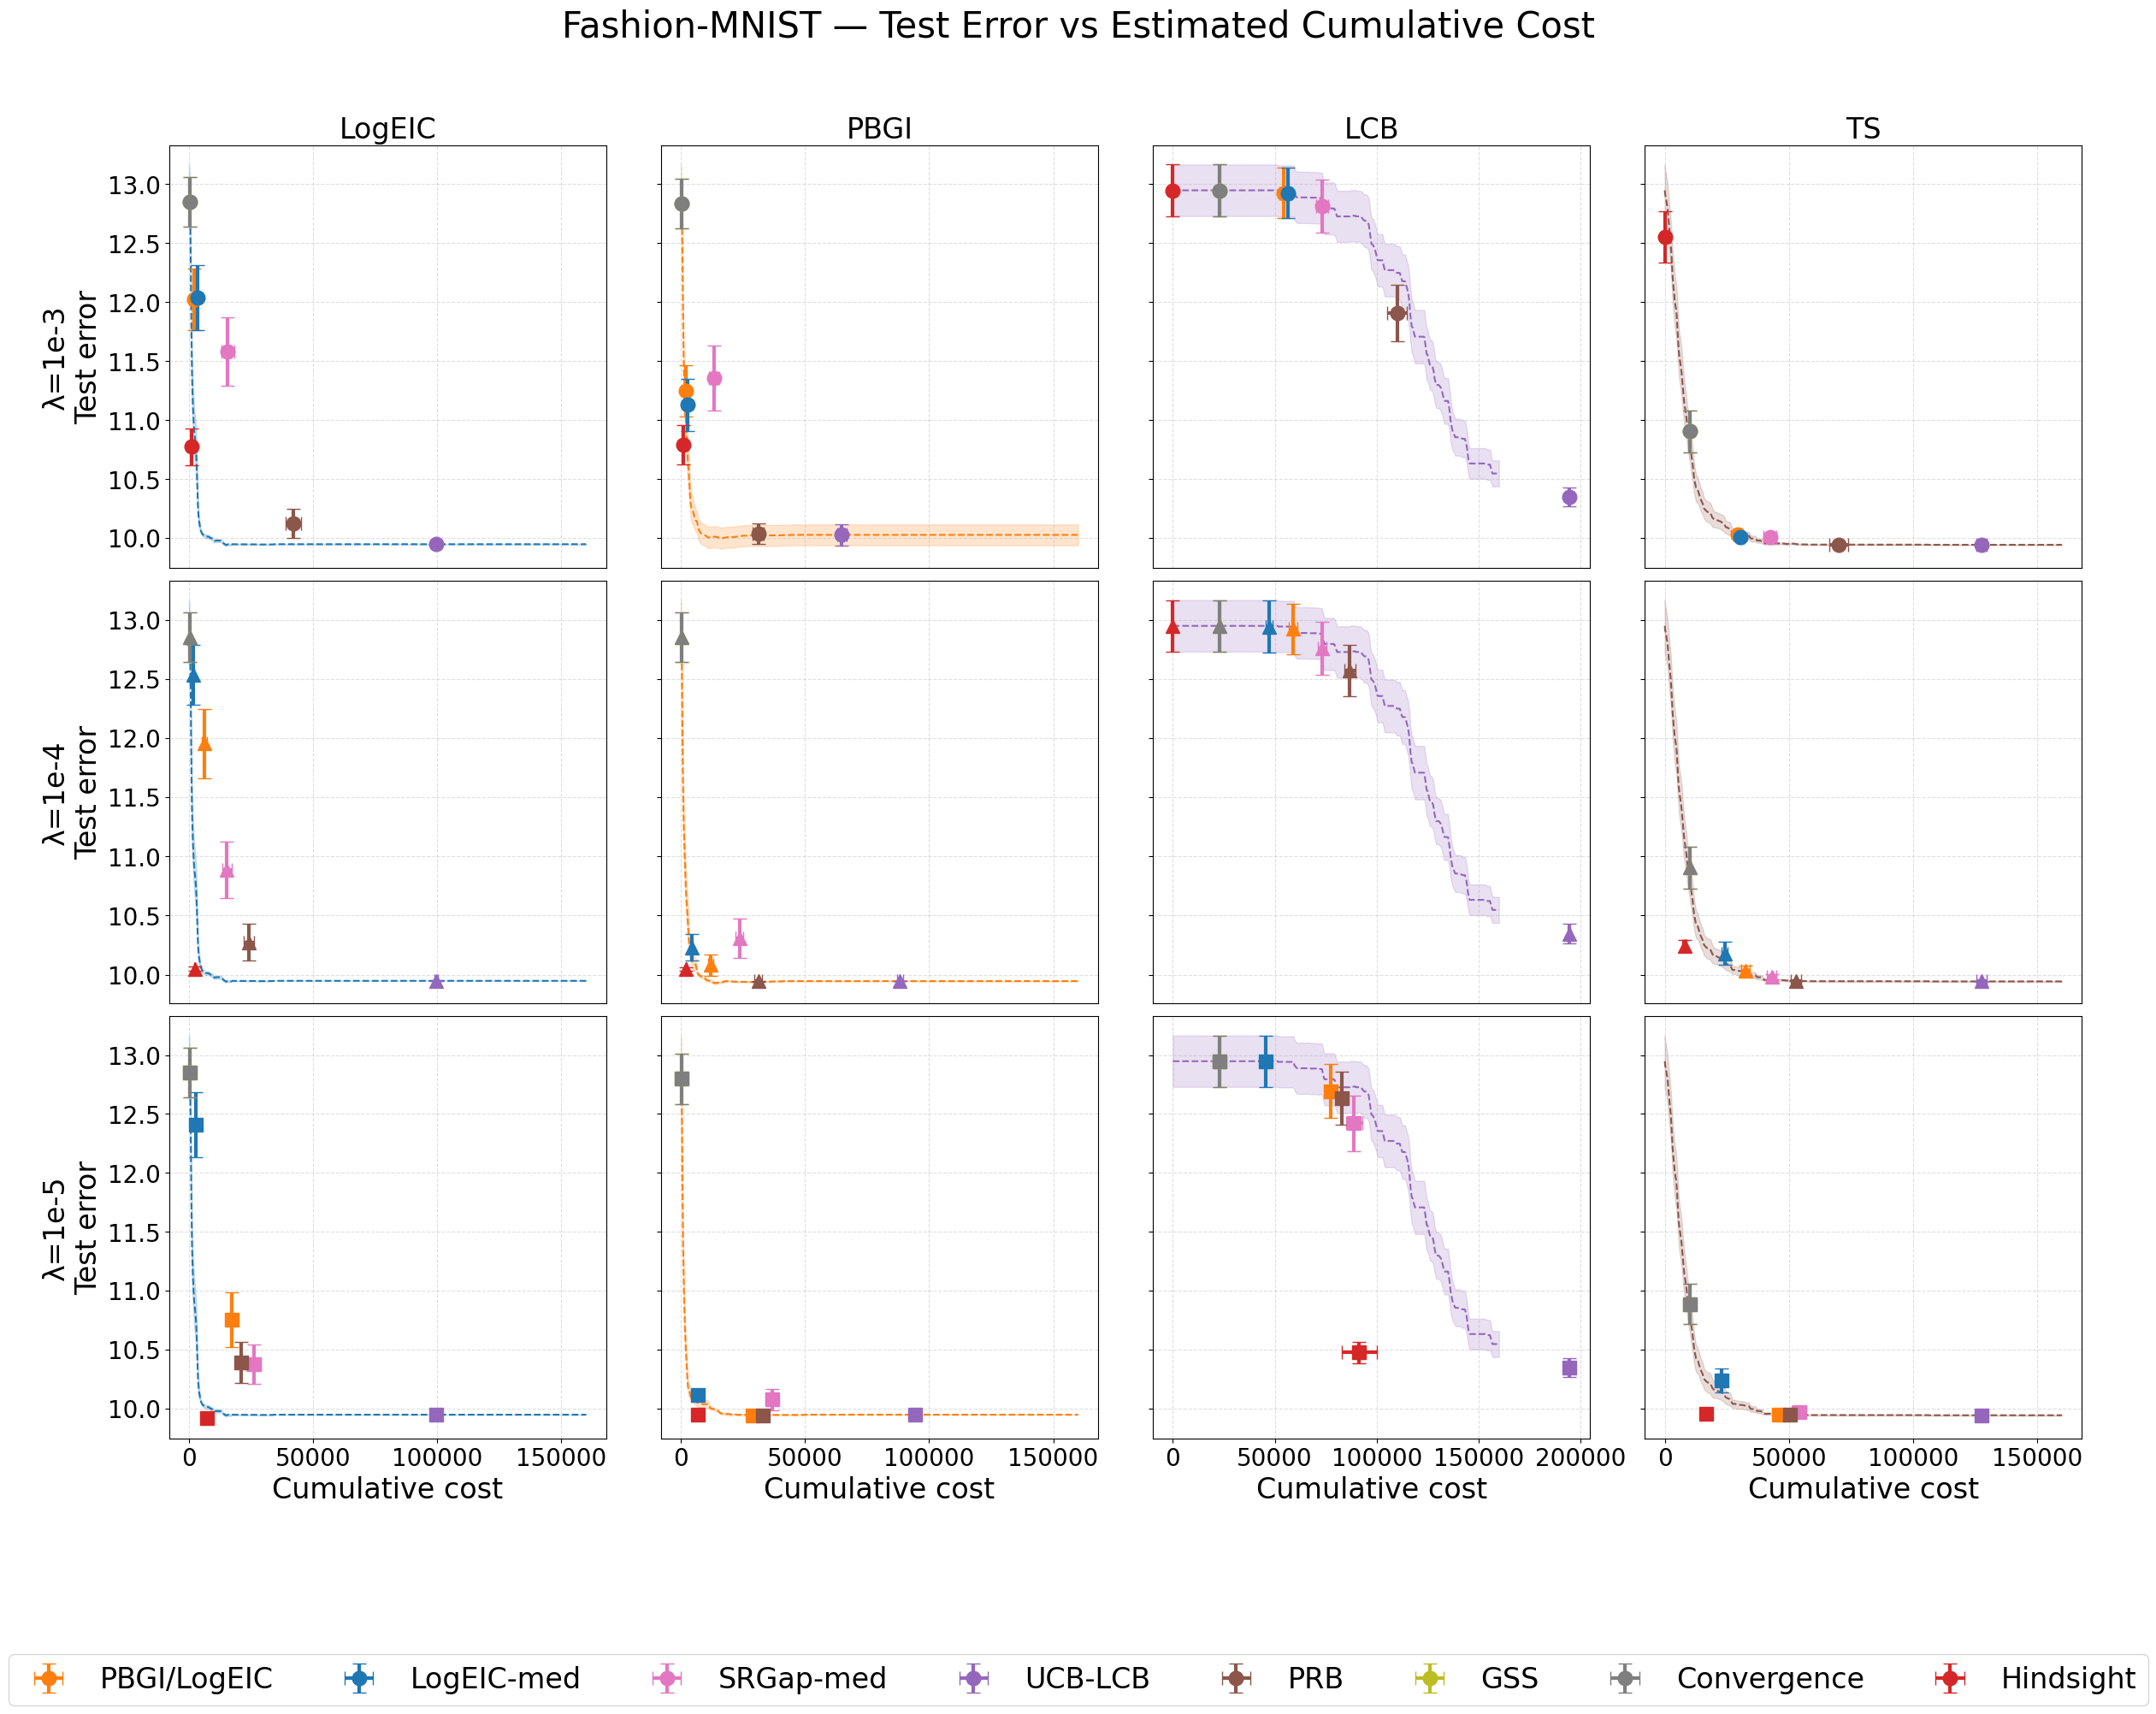

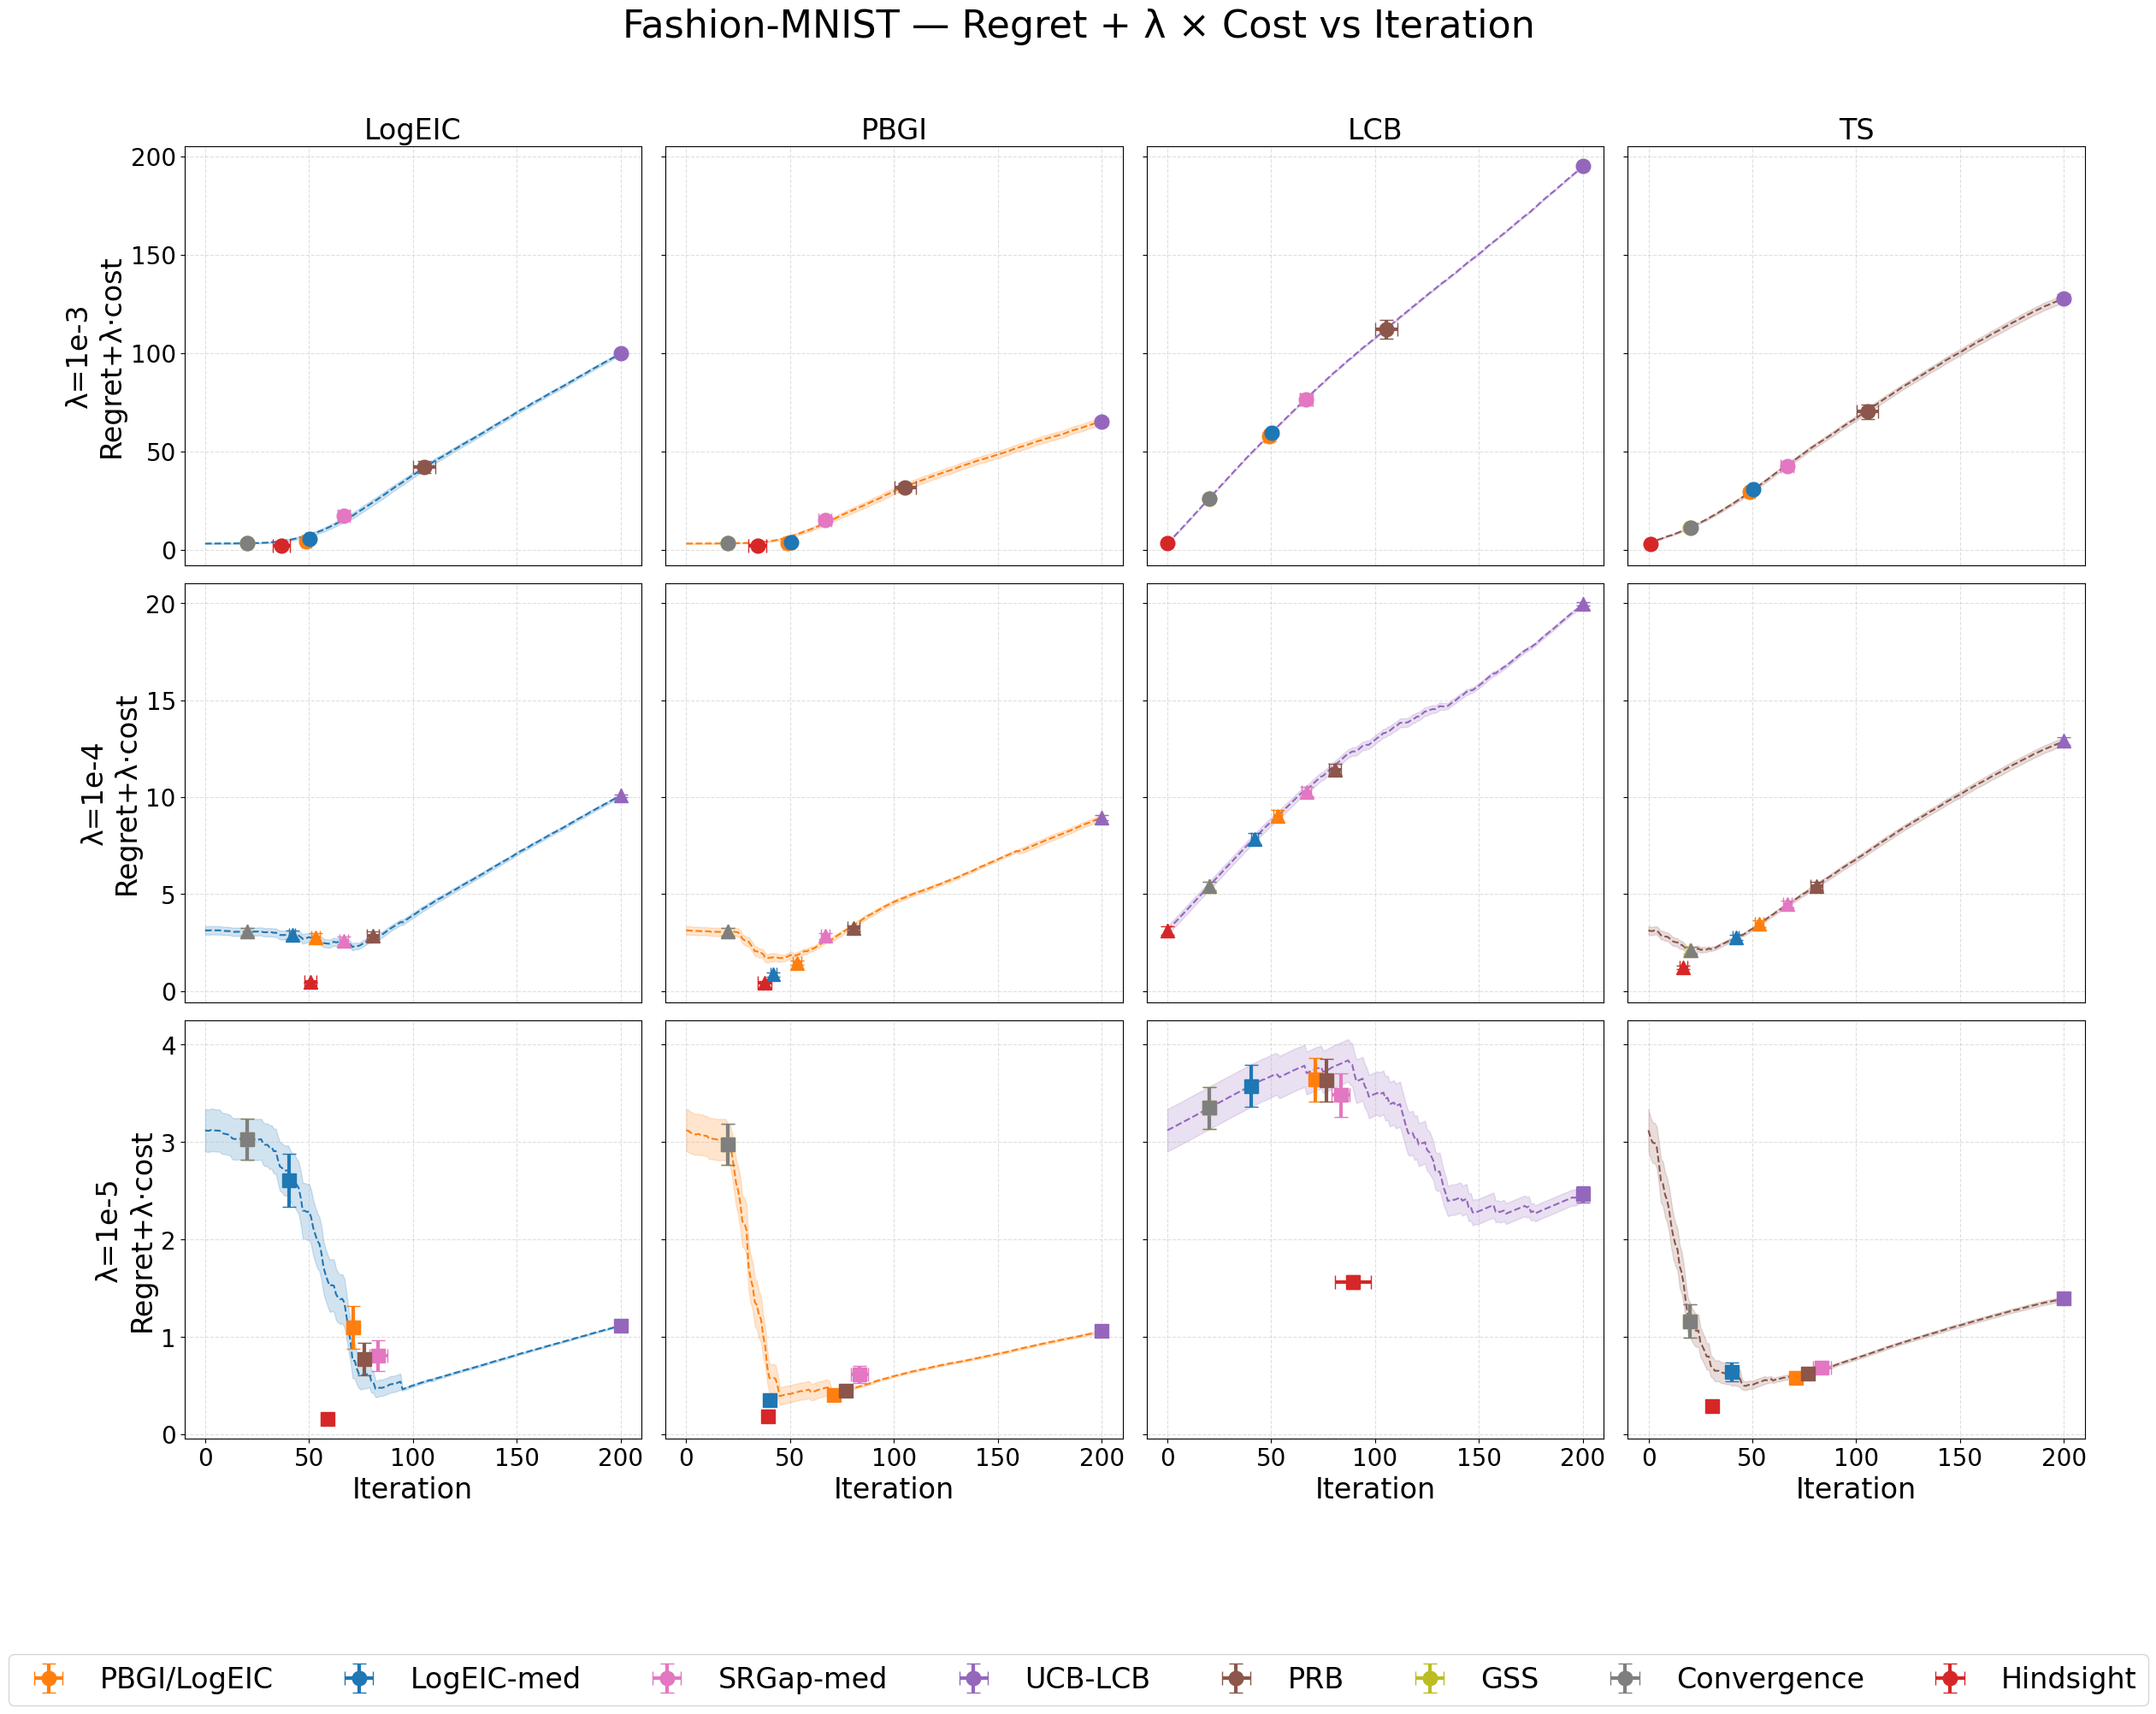

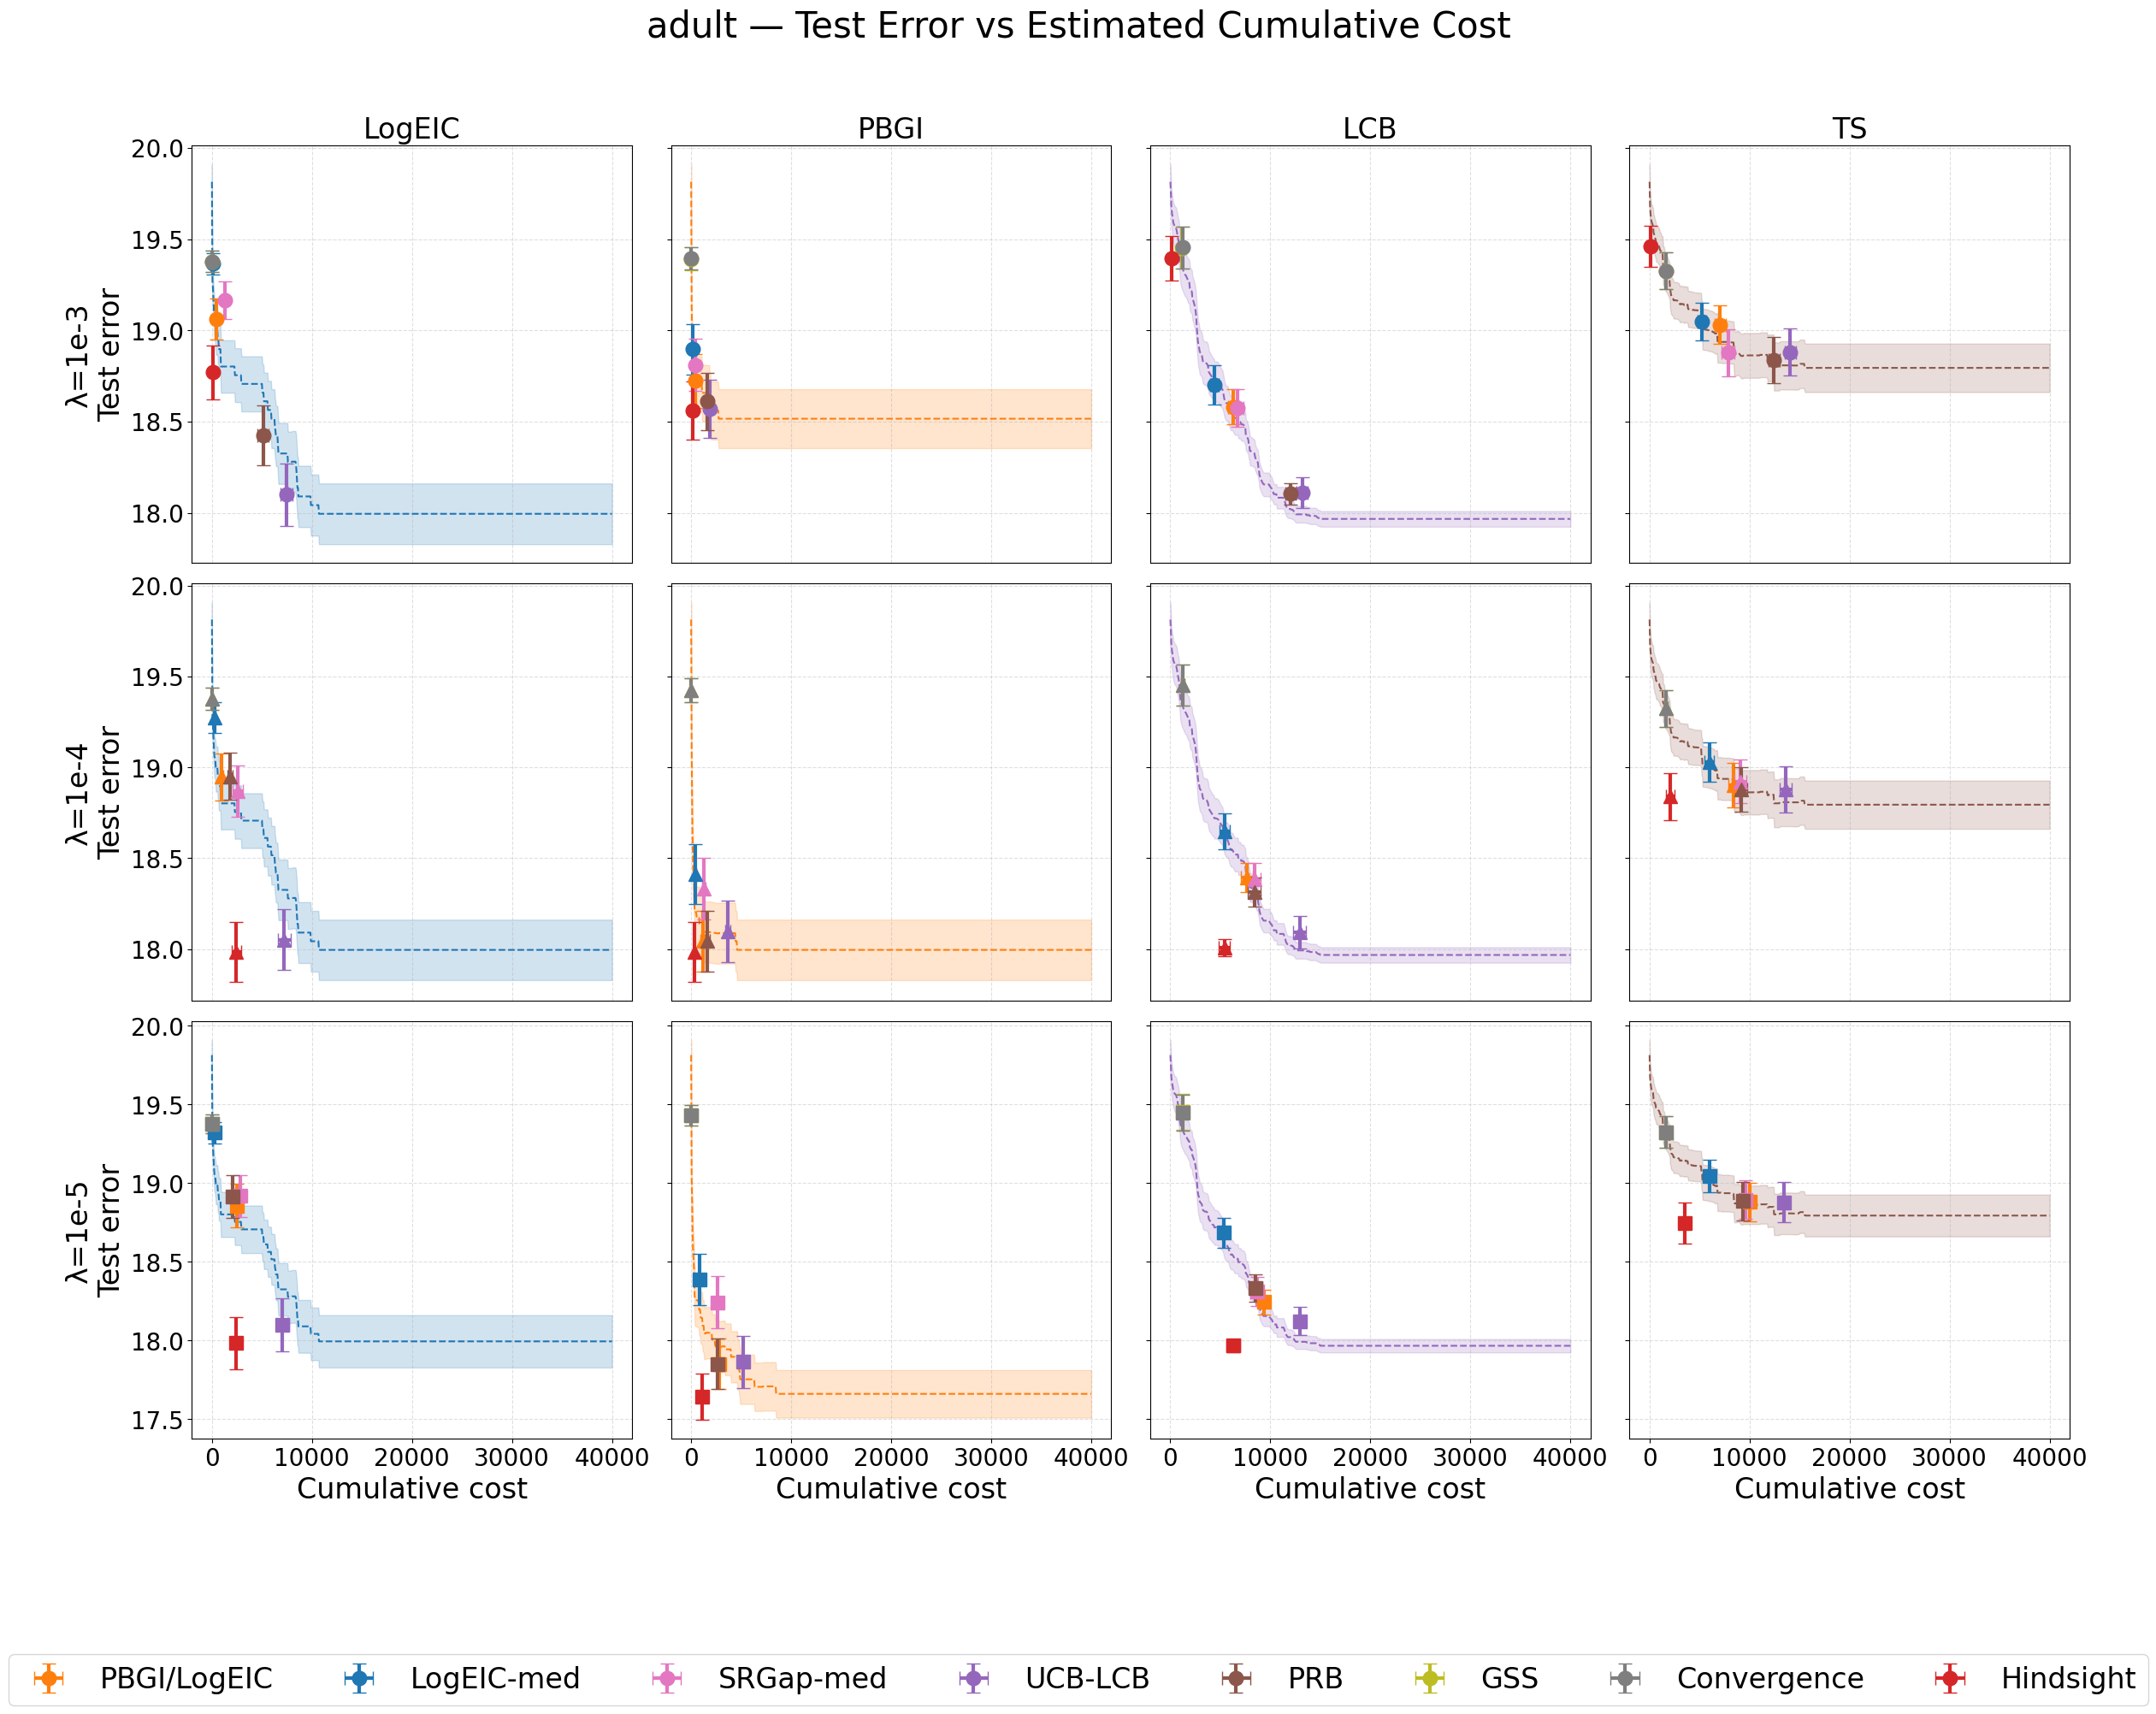

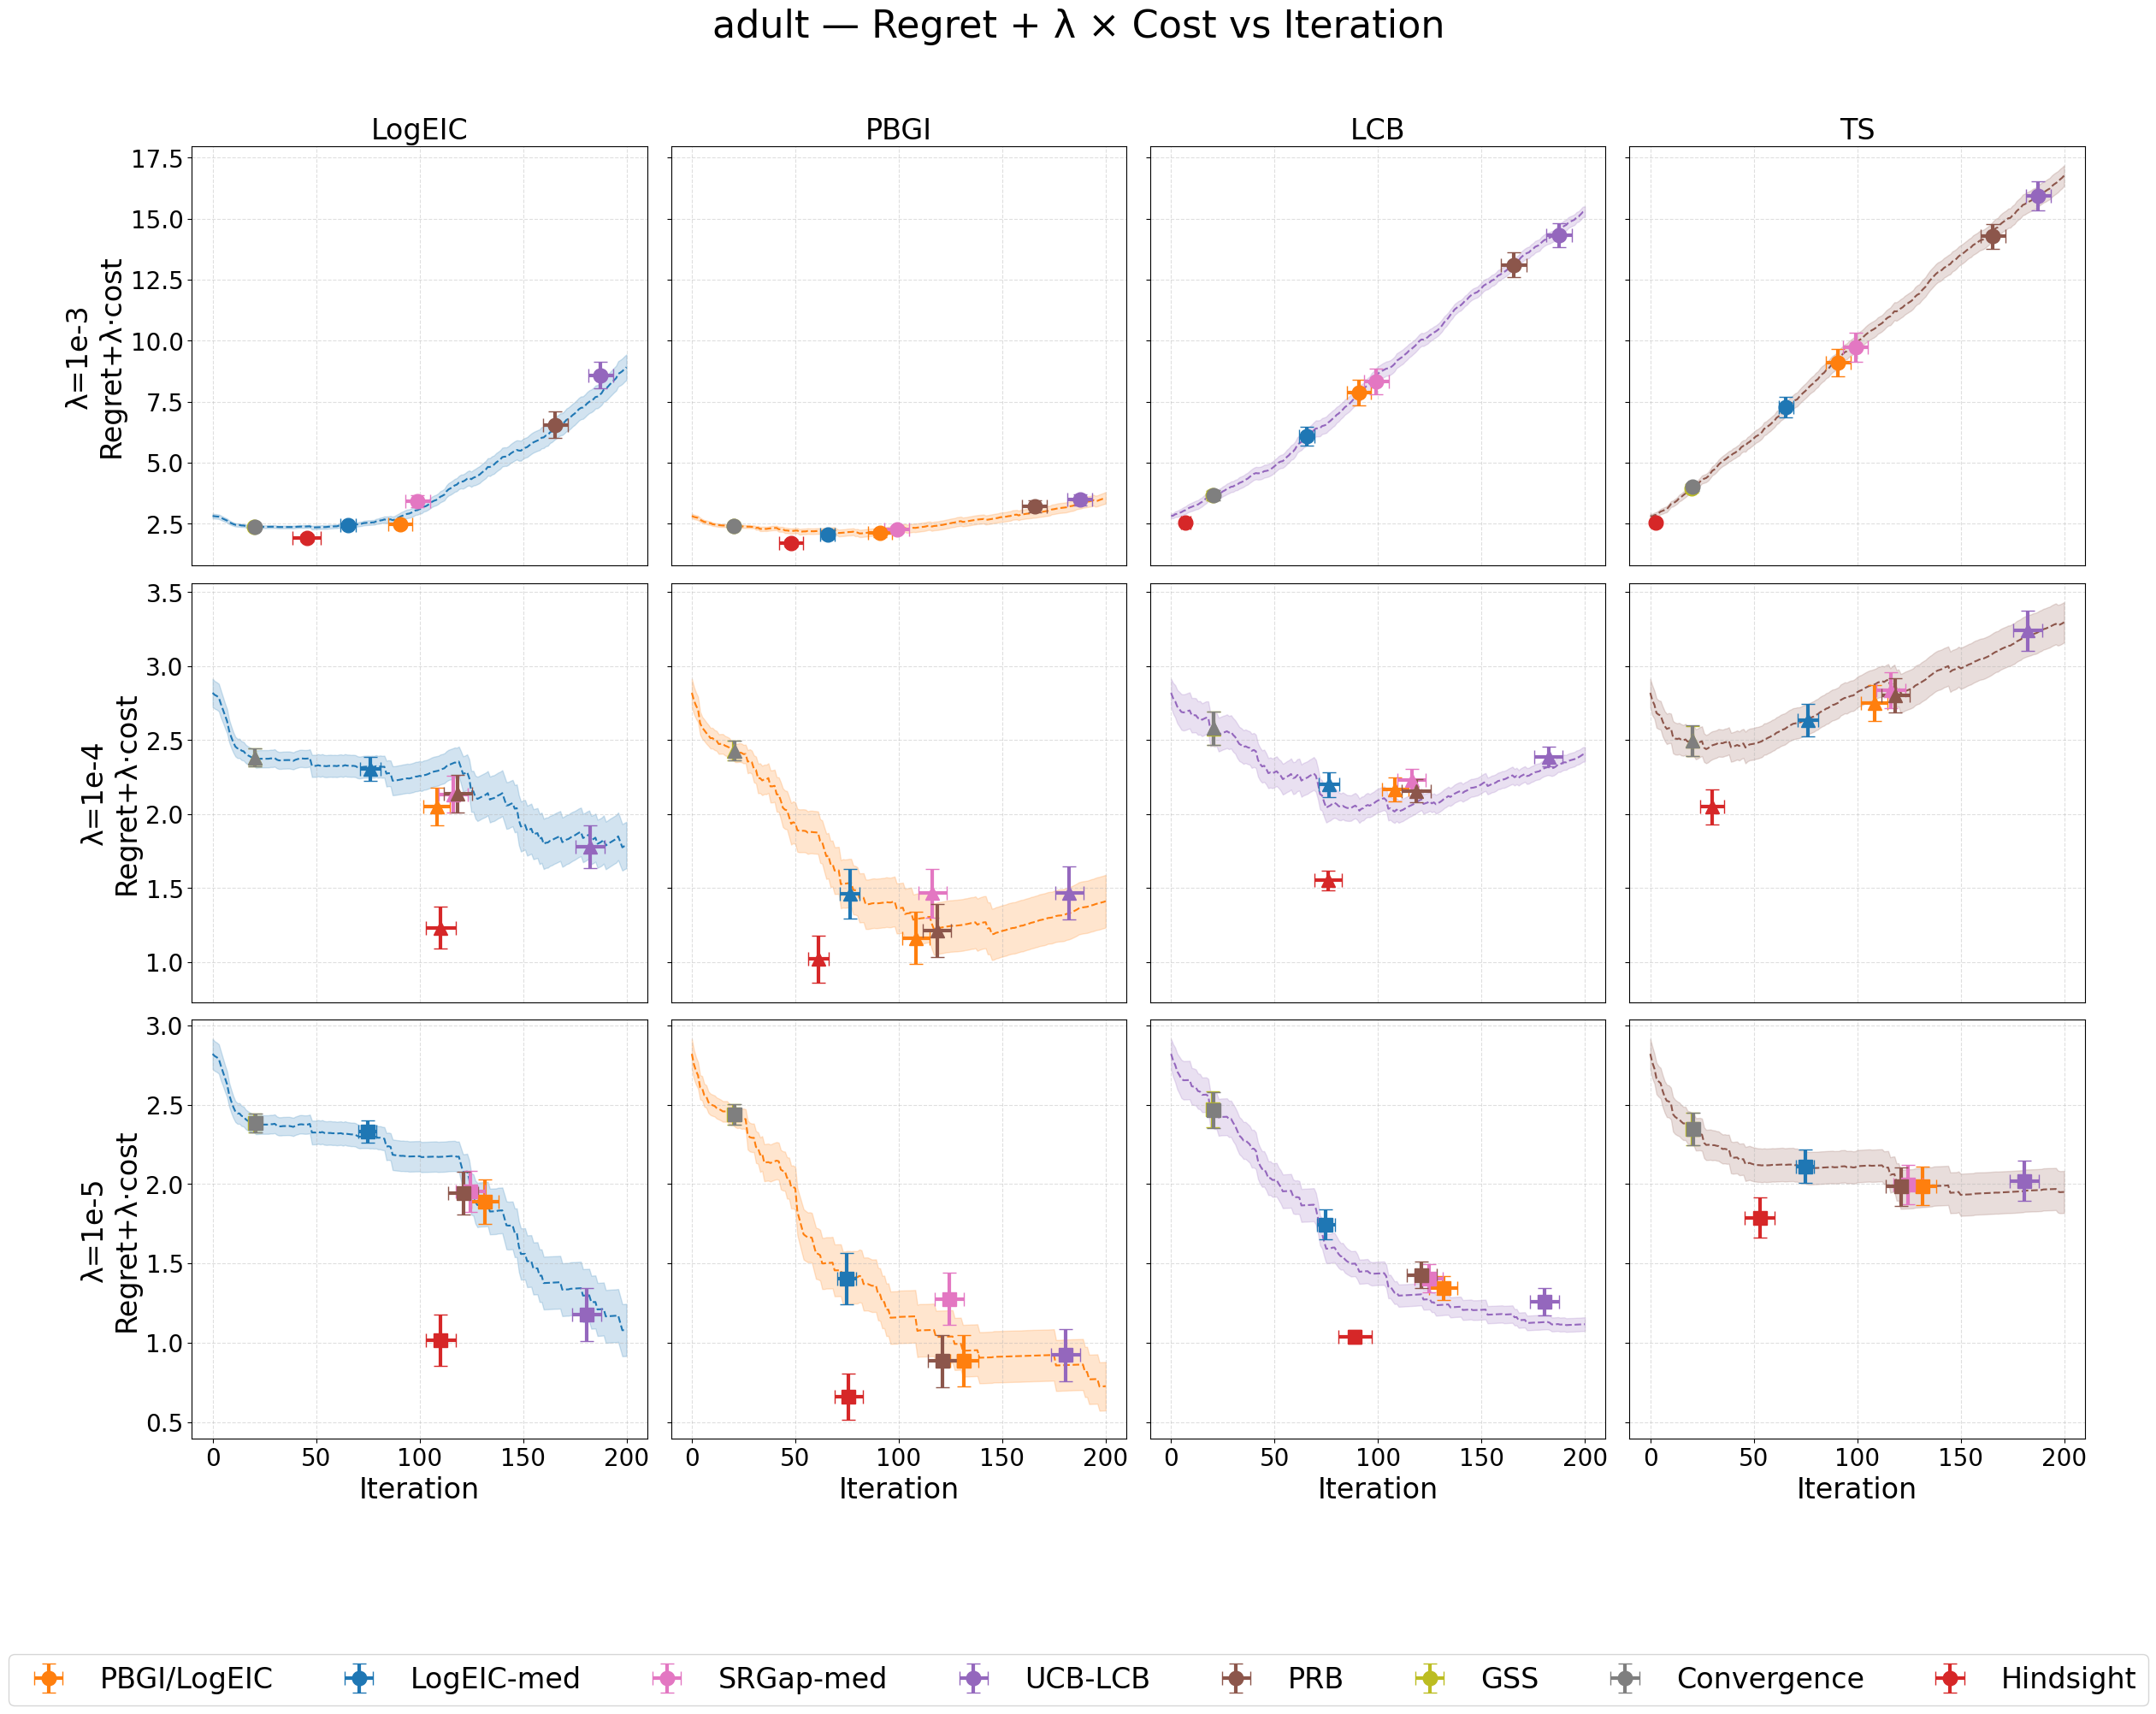

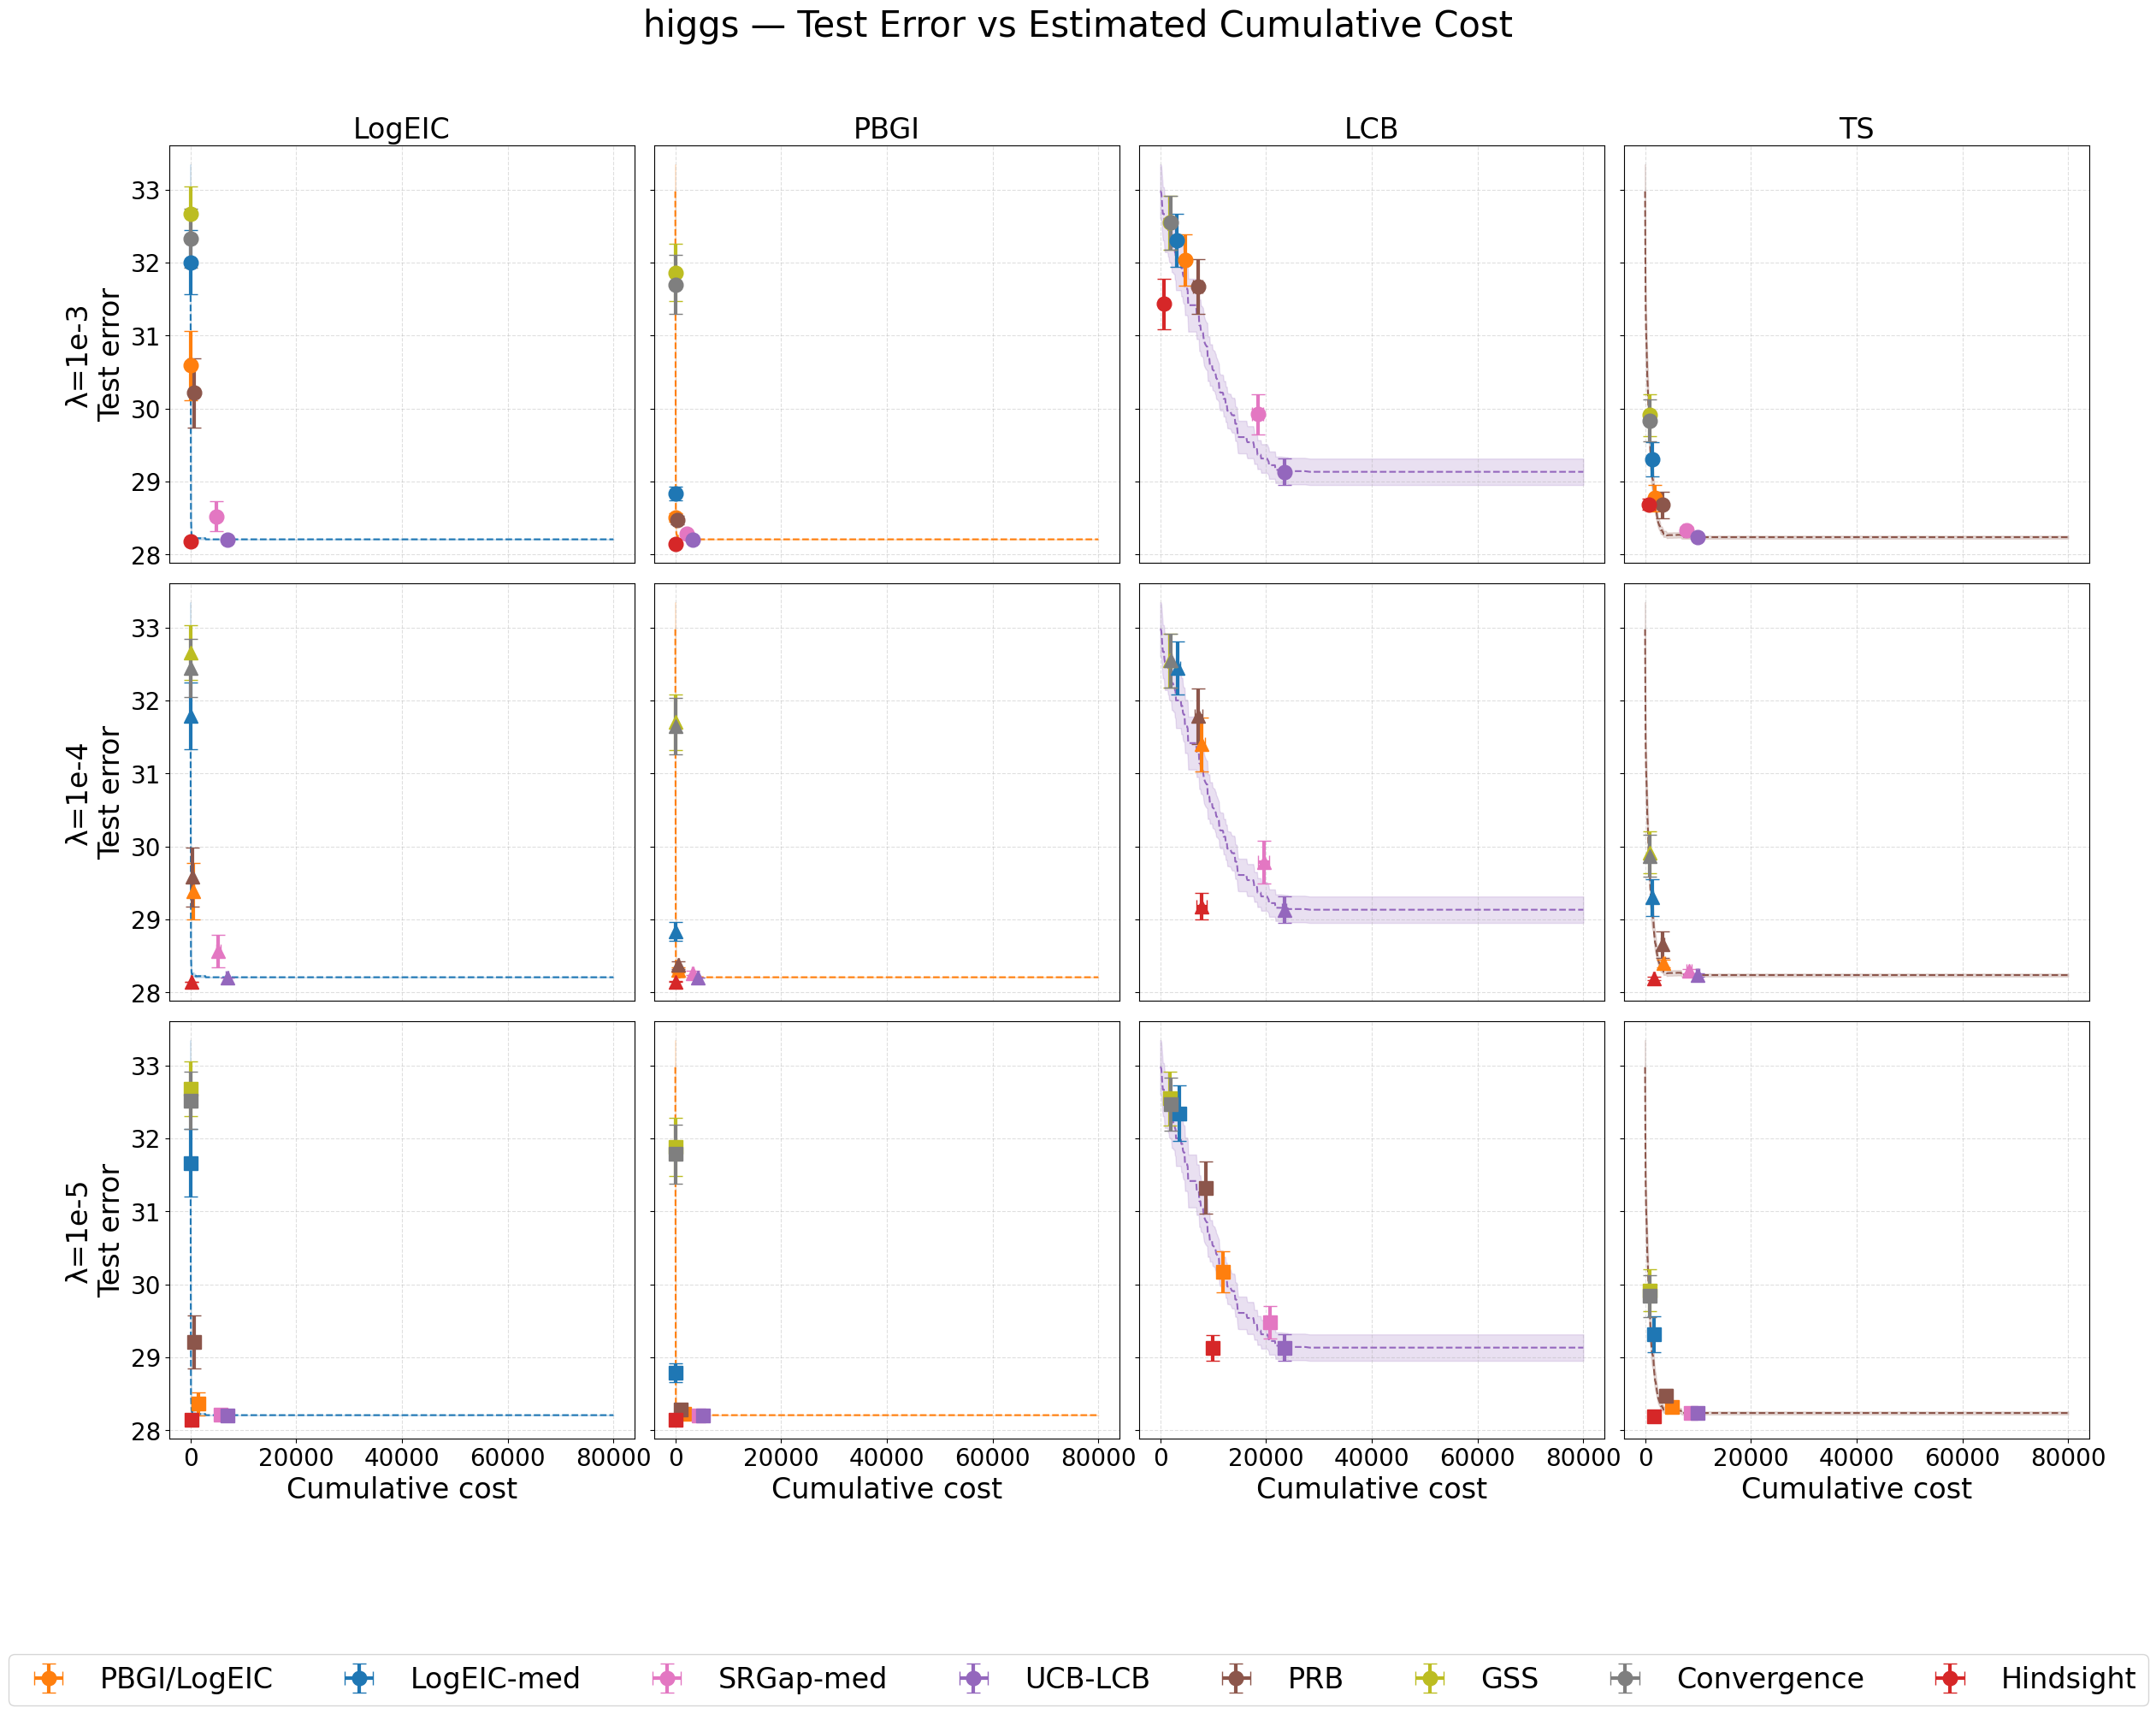

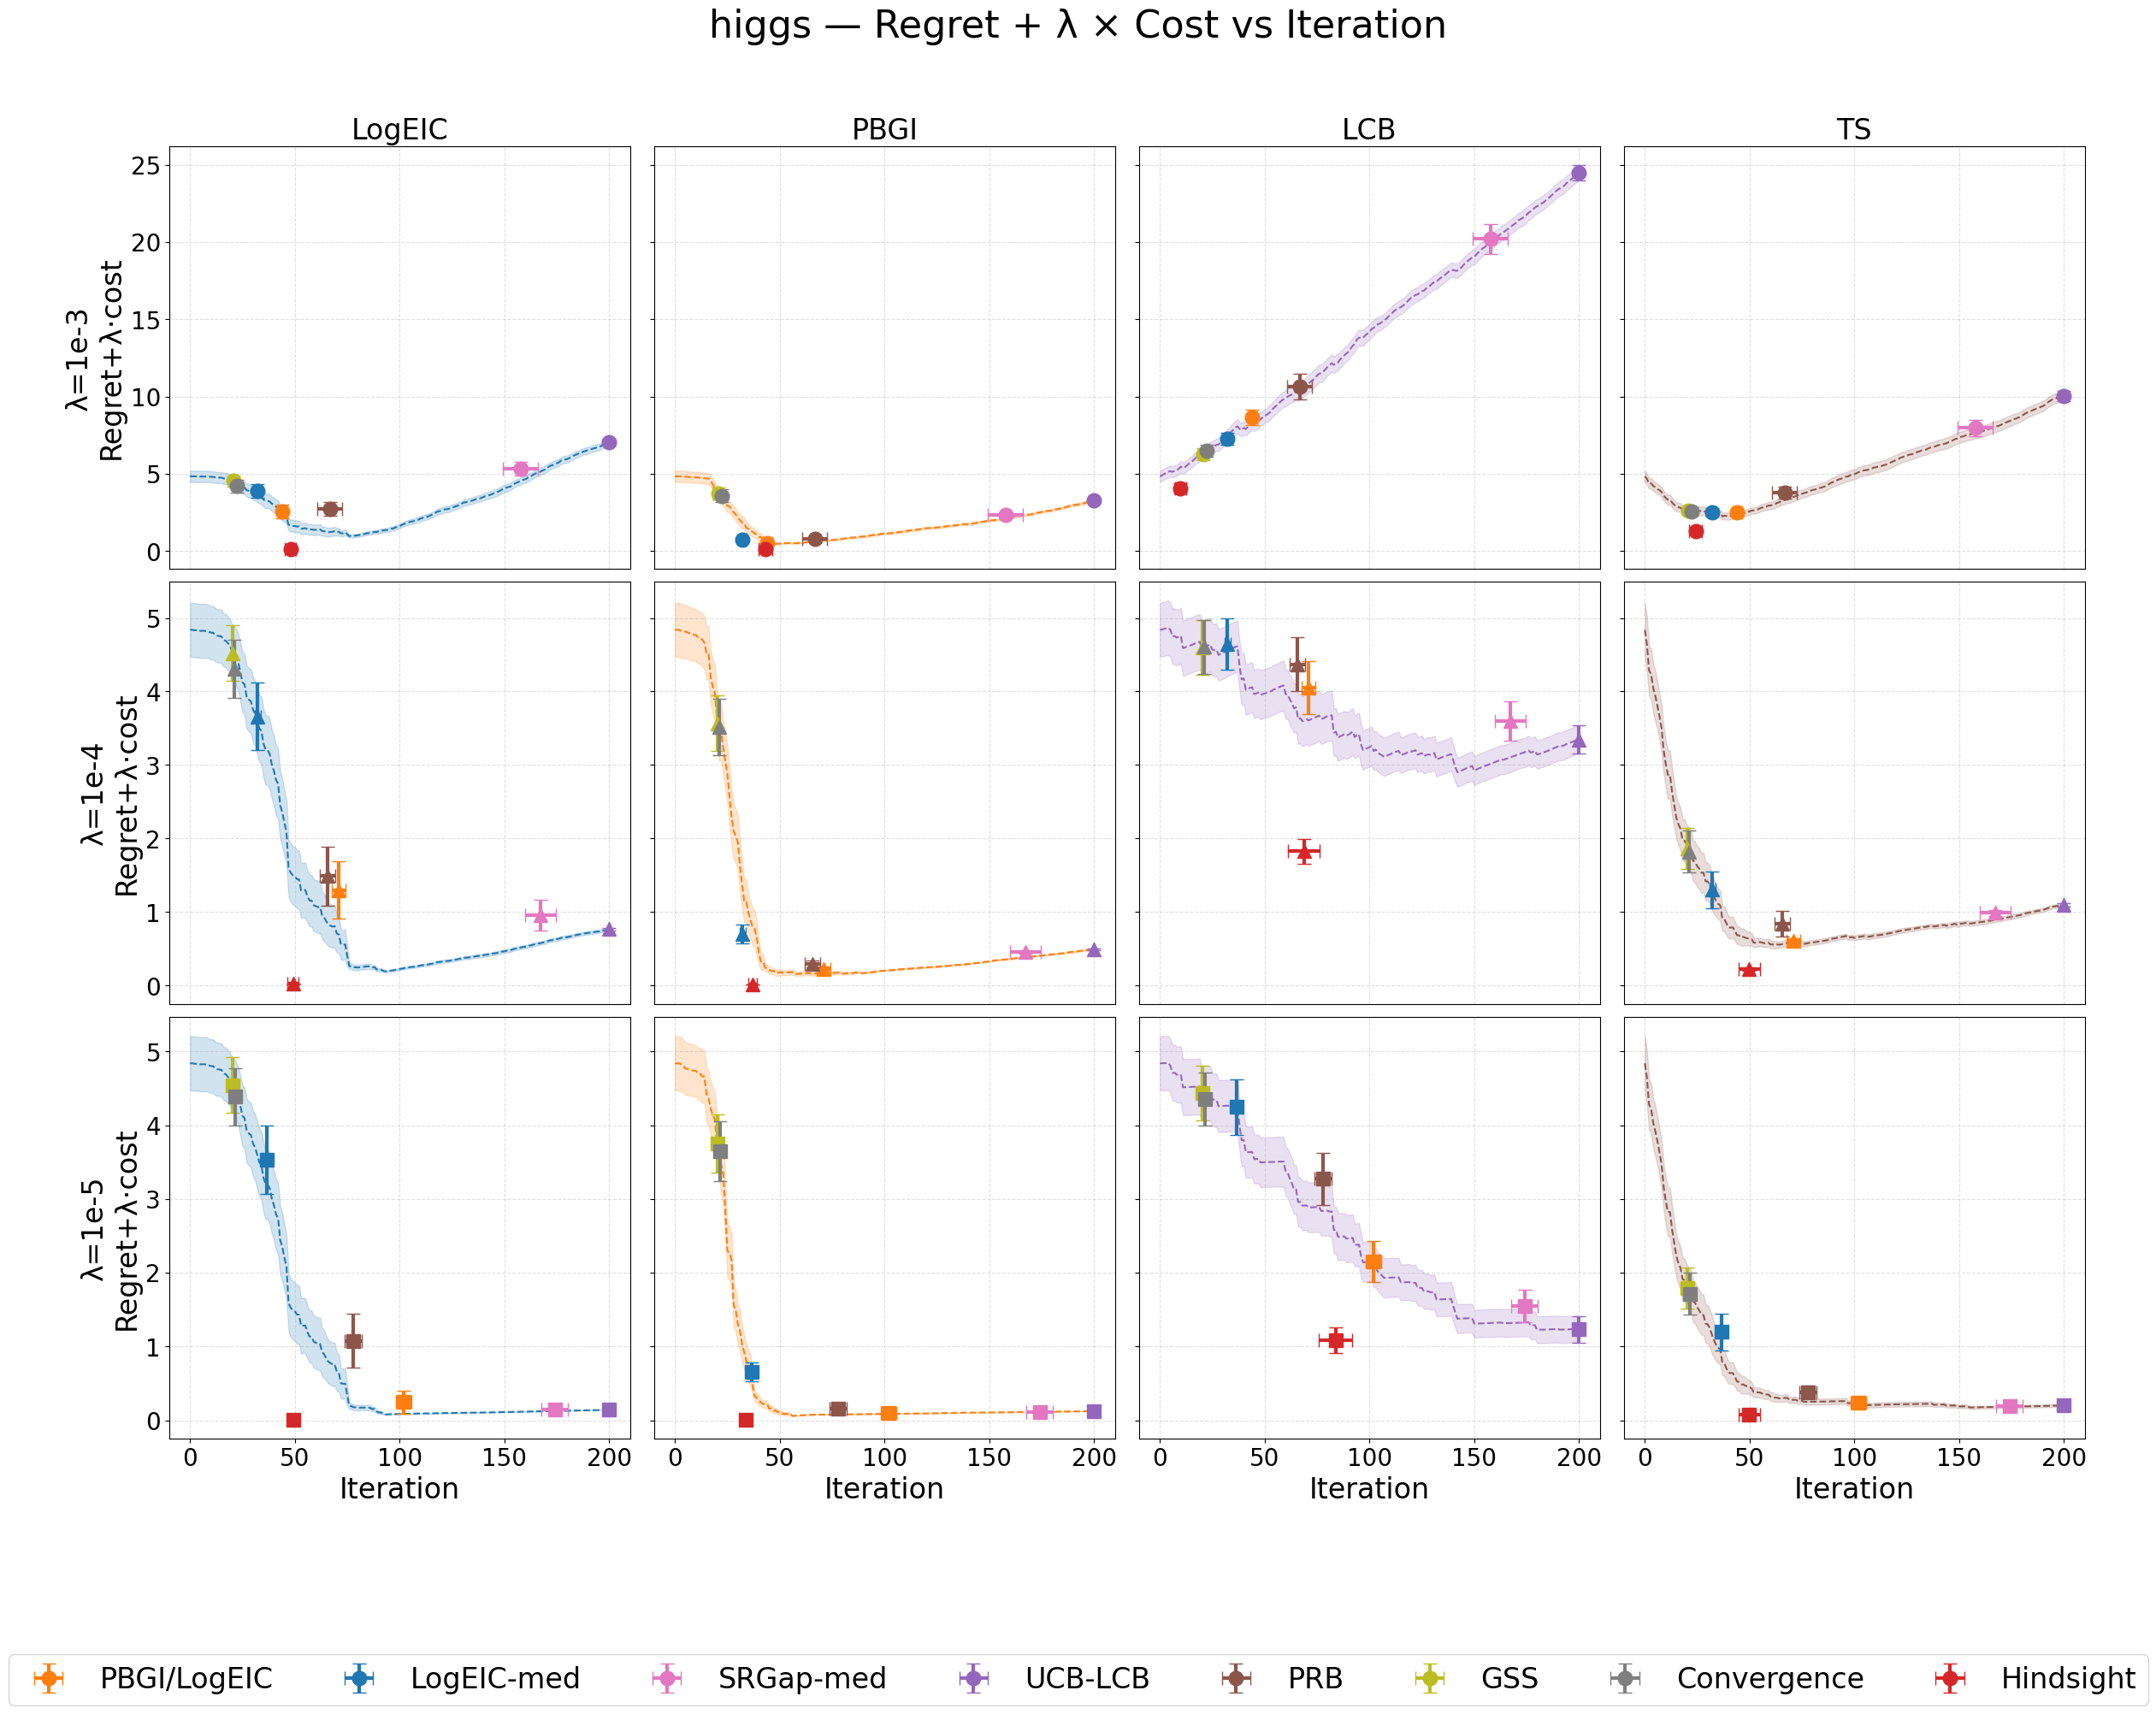

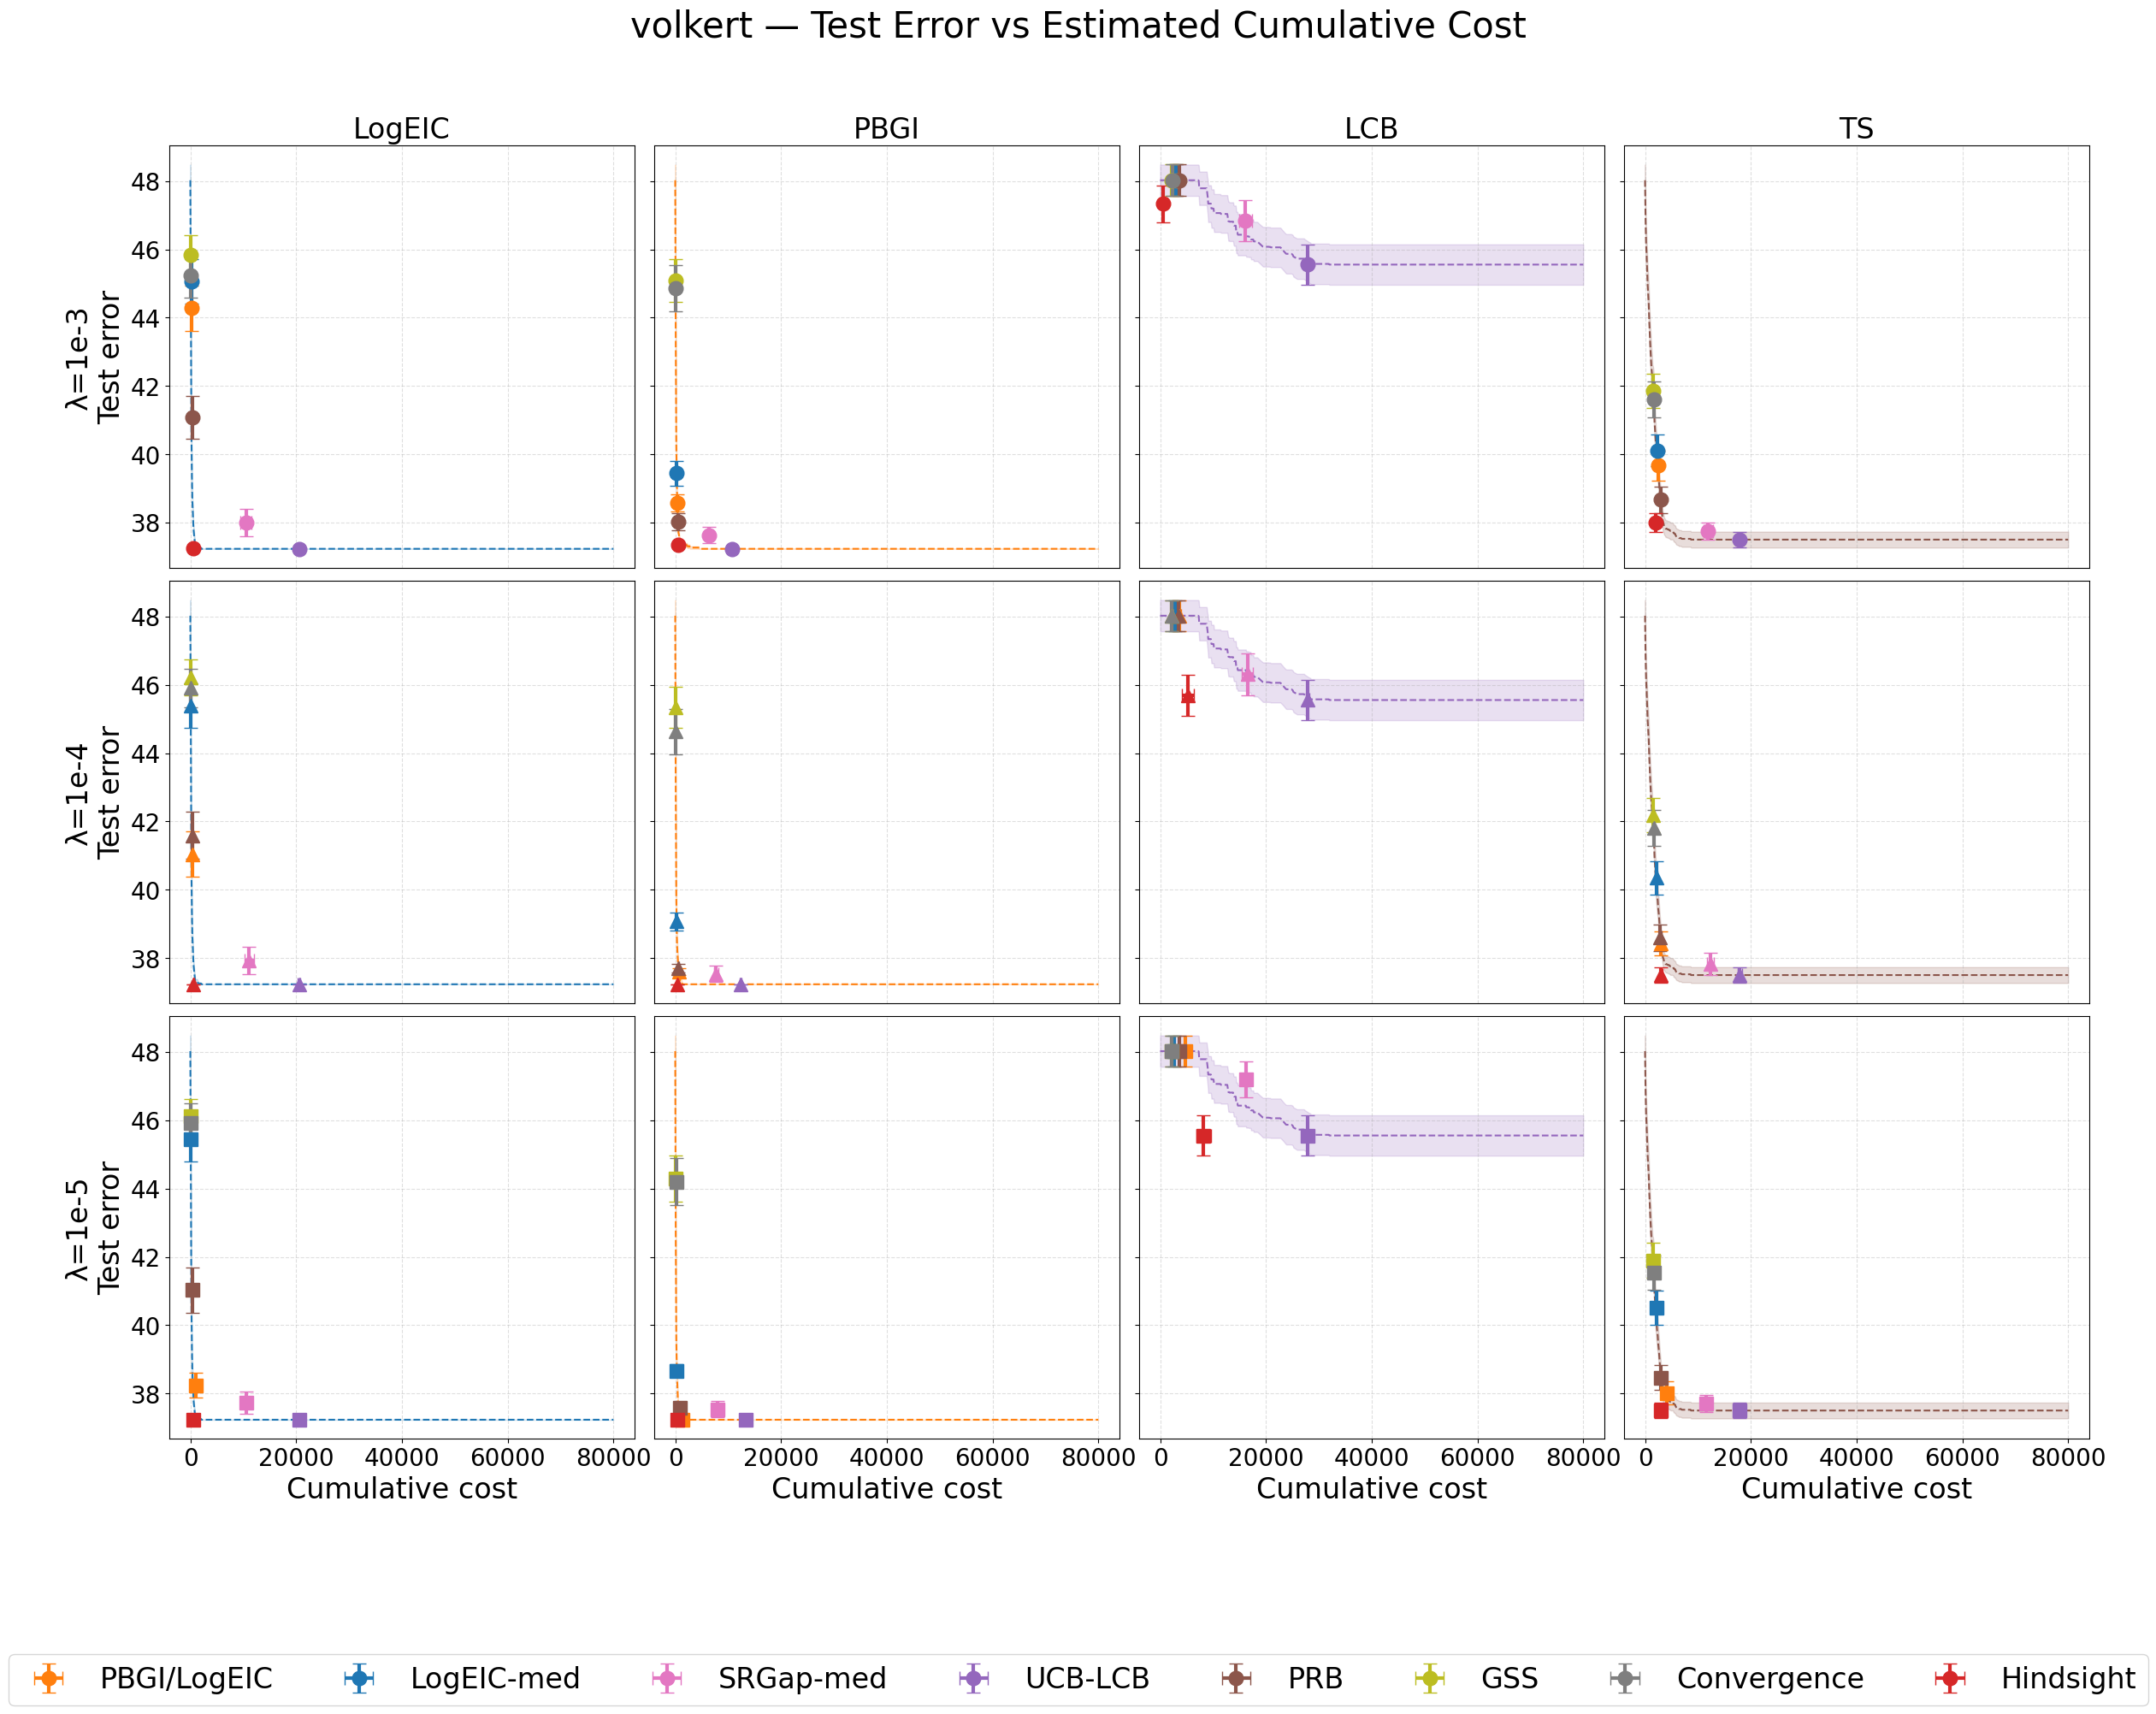

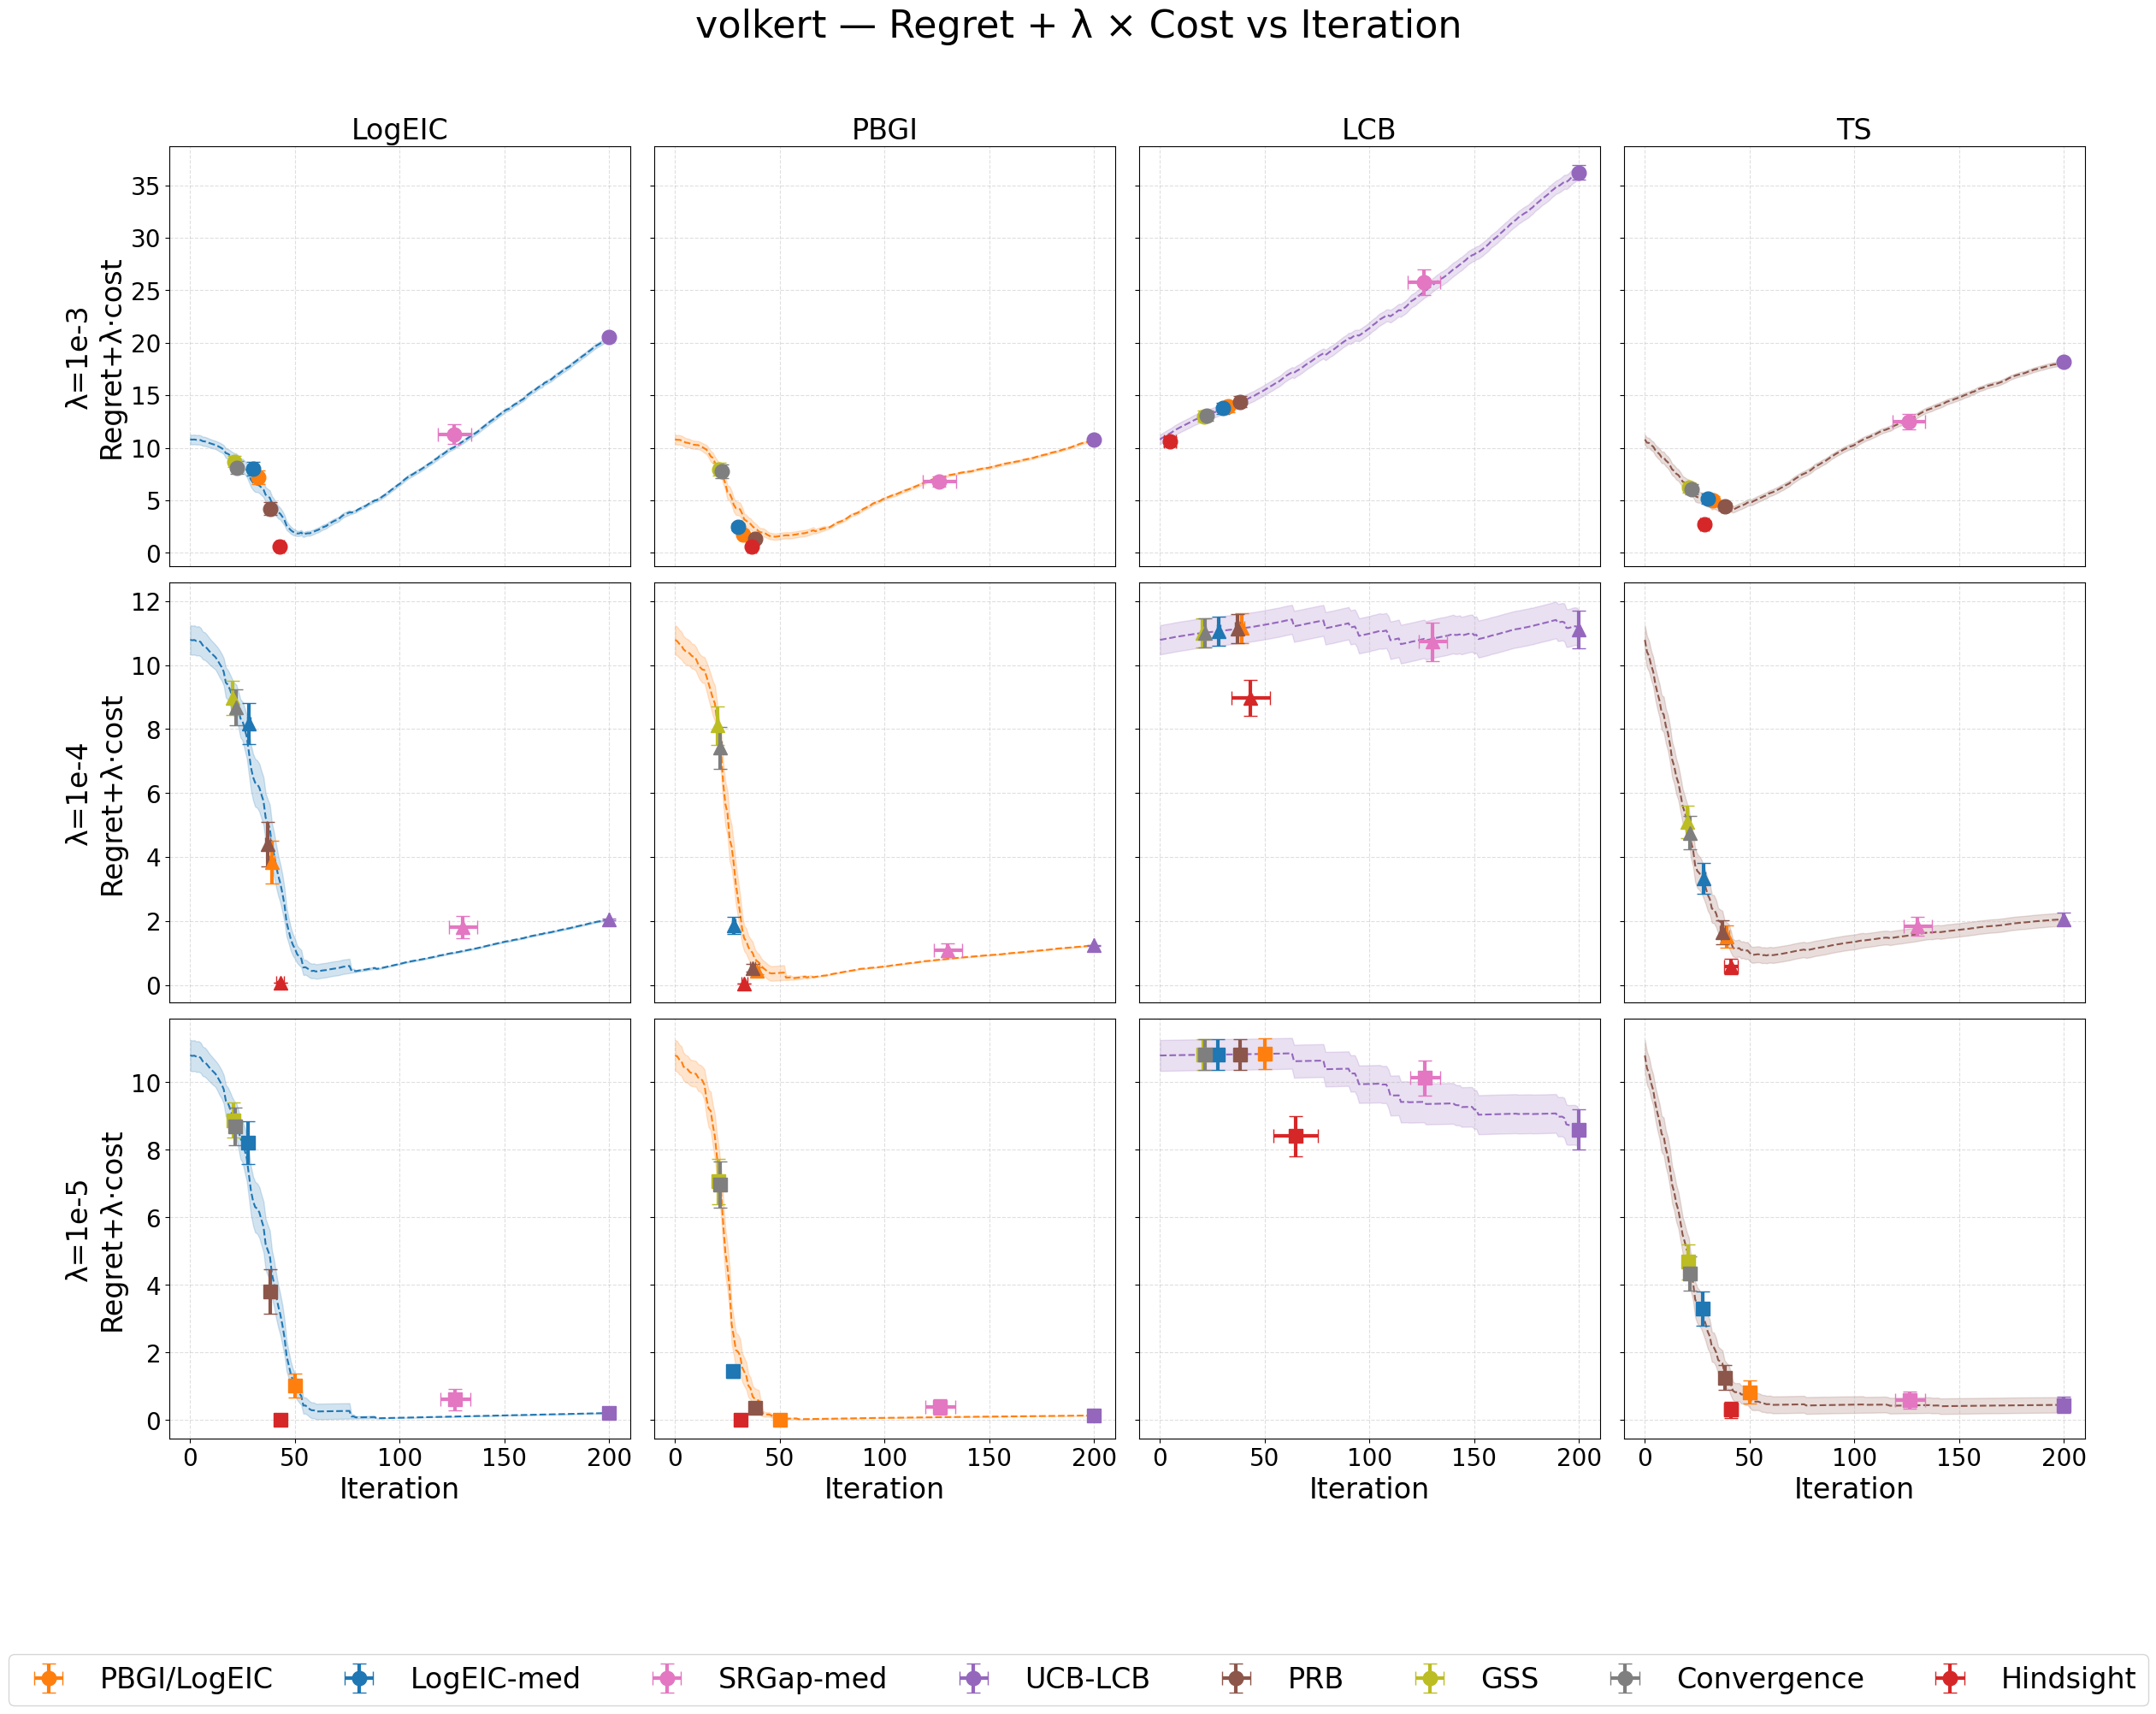

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# === User‐provided data and helper functions (assumed to exist) ===
# metrics_per_acq[d][acq_key]["estimated cumulative cost"]
# test_metrics_per_acq[d][acq_key]["final test error"]
# bench.query_best_final(dataset, "final_test_accuracy", "final_test_accuracy", 0)

# === Config ===
dataset_names = ['Fashion-MNIST', 'adult', 'higgs', 'volkert']
lambdas       = [1e-3, 1e-4, 1e-5]
acq_order     = ['LogEIC', 'PBGI', 'LCB', 'TS']
init          = 20

x_limit_per_dataset = {
    "Fashion-MNIST": 80000,
    "adult":         40000,
    "higgs":         40000,
    "volkert":       40000
}
cost_limit_per_dataset = {
    "Fashion-MNIST": 160000,
    "adult":         40000,
    "higgs":         80000,
    "volkert":       80000
}

# === Color and marker settings ===
color_dict = {
    'LogEIC':      'tab:blue',
    'LogEIC-med':  'tab:blue',
    'PBGI(1e-3)':  'tab:orange',
    'PBGI(1e-4)':  'tab:orange',
    'PBGI(1e-5)':  'tab:orange',
    'LCB':         'tab:purple',
    'UCB-LCB':     'tab:purple',
    'SRGap-med':   'tab:pink',
    'TS':          'tab:brown',
    'PRB':         'tab:brown',
    'GSS':         'tab:olive',
    'Convergence': 'tab:gray',
    'Hindsight':   'tab:red'
}
marker_dict = {
    '1e-3': 'o',
    '1e-4': '^',
    '1e-5': 's'
}

# === Build stopping_rules for each λ ===
stopping_rules = []
for lam in lambdas:
    lam_str   = f"1e-{int(round(-np.log10(lam)))}"  # “1e-3”, “1e-4”, “1e-5”
    fixed_acq = f"PBGI({lam_str})"
    marker    = marker_dict[lam_str]

    templates = [
        {
            'stp_key':      'PBGI',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, lam=lam, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa][f"{fa} acq"][seed][i] >=
                metrics_per_acq[d][fa]["current best observed"][seed][i - 1]
            ))
        },
        # {
        #     'stp_key':      'LogEIC',
        #     'is_hindsight': False,
        #     'condition_fn': (lambda i, seed, d, lam=lam, fa=fixed_acq: (
        #         i >= init and
        #         metrics_per_acq[d][fa]["LogEIC acq"][seed][i] <= np.log(lam)
        #     ))
        # },
        {
            'stp_key':      'LogEIC-med',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa]["LogEIC acq"][seed][i] <= (
                    np.log(0.01) +
                    np.nanmedian(metrics_per_acq[d][fa]["LogEIC acq"][seed][1:21])
                )
            ))
        },
        {
            'stp_key':      'SRGap-med',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa]["exp min regret gap"][seed][i] <=
                0.1 * np.nanmedian(
                    metrics_per_acq[d][fa]["exp min regret gap"][seed][1:21]
                )
            ))
        },
        {
            'stp_key':      'UCB-LCB',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa]["regret upper bound"][seed][i] <= 0.01
            ))
        },
        {
            'stp_key':      'PRB',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa]["PRB"][seed][i] >= 0.95
            ))
        },
        {
            'stp_key':      'GSS',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and (
                    (np.nanpercentile(
                        metrics_per_acq[d][fa]["current best observed"][seed][:i+1], 75
                     ) -
                     np.nanpercentile(
                        metrics_per_acq[d][fa]["current best observed"][seed][:i+1], 25
                     )) == 0
                ) or (
                    ((metrics_per_acq[d][fa]["current best observed"][seed][i - 5] -
                      metrics_per_acq[d][fa]["current best observed"][seed][i]) /
                     (np.nanpercentile(
                        metrics_per_acq[d][fa]["current best observed"][seed][:i+1], 75
                     ) -
                      np.nanpercentile(
                        metrics_per_acq[d][fa]["current best observed"][seed][:i+1], 25
                     ))
                    ) <= 0.01
                )
            ))
        },
        {
            'stp_key':      'Convergence',
            'is_hindsight': False,
            'condition_fn': (lambda i, seed, d, fa=fixed_acq: (
                i >= init and
                metrics_per_acq[d][fa]["current best observed"][seed][i] ==
                metrics_per_acq[d][fa]["current best observed"][seed][i - 5]
            ))
        },
        {
            'stp_key':      'Hindsight',
            'is_hindsight': True,
            'condition_fn': None
        }
    ]

    for temp in templates:
        rule = {
            'acq_key':      fixed_acq,
            'stp_key':      temp['stp_key'],
            'is_hindsight': temp['is_hindsight'],
            'marker':       marker,
            'color':        color_dict.get(temp['stp_key'], color_dict[fixed_acq]),
            'label':        'PBGI/LogEIC' if temp['stp_key'] == 'PBGI' else temp['stp_key']
        }
        if temp['condition_fn'] is not None:
            rule['condition_fn'] = temp['condition_fn']
        stopping_rules.append(rule)

# === Plotting ===
for d in dataset_names:
    best_acc   = bench.query_best_final(d, "final_test_accuracy", "final_test_accuracy", 0)
    best_error = 100. - best_acc

    # === 1) Test error vs estimated cumulative cost ===
    fig, axes = plt.subplots(3, 4, figsize=(24, 18), sharey="row")
    fig.suptitle(f"{d} — Test Error vs Estimated Cumulative Cost", fontsize=30)
    for i, lam in enumerate(lambdas):
        lam_str = f"1e-{int(round(-np.log10(lam)))}"

        for j in range(4):
            acq = acq_order[j]
            fixed_acq = f"PBGI({lam_str})" if acq == 'PBGI' else acq
            ax = axes[i, j]

            # === Mean test error curve ===
            cost_grid = np.linspace(0, cost_limit_per_dataset[d], 801)
            curves = []
            for seed in range(len(metrics_per_acq[d][fixed_acq]["estimated cumulative cost"])):
                c = np.array(metrics_per_acq[d][fixed_acq]["estimated cumulative cost"][seed])
                e = np.array(test_metrics_per_acq[d][fixed_acq]["final test error"][seed])
                idx = np.argsort(c)
                curves.append(np.interp(cost_grid, c[idx], e[idx]))
            curves = np.vstack(curves)
            mean_c = curves.mean(axis=0)
            sem_c  = curves.std(axis=0) / np.sqrt(curves.shape[0])

            ax.plot(cost_grid, mean_c, linestyle='--', color=color_dict[fixed_acq])
            ax.fill_between(cost_grid, mean_c - sem_c, mean_c + sem_c, color=color_dict[fixed_acq], alpha=0.2)

            # === Stopping rule overlays ===
            for rule in stopping_rules:
                # Only use rules from the correct lambda
                if rule['acq_key'] != f"PBGI({lam_str})":
                    continue

                stop_vals = []
                stop_costs = []
                for seed in range(curves.shape[0]):
                    errs = test_metrics_per_acq[d][fixed_acq]["final test error"][seed]
                    costs = metrics_per_acq[d][fixed_acq]["estimated cumulative cost"][seed]
                    if rule['is_hindsight']:
                        regs = np.array(errs) - best_error + lam * np.array(costs)
                        idx = np.argmin(regs)
                    else:
                        idx = next((k for k in range(init, len(errs)) if rule['condition_fn'](k, seed, d)), len(errs) - 1)
                    stop_vals.append(errs[idx])
                    stop_costs.append(costs[idx])

                mx = np.mean(stop_costs)
                my = np.mean(stop_vals)
                sx = np.std(stop_costs) / np.sqrt(len(stop_costs))
                sy = np.std(stop_vals) / np.sqrt(len(stop_vals))

                ax.errorbar(mx, my, xerr=sx, yerr=sy,
                            fmt=rule['marker'],
                            markersize=12,
                            linewidth=3,
                            color=rule['color'],
                            capsize=6,
                            label=rule['label'])

            if i == 0:
                ax.set_title(acq, fontsize=24)  # only first row

            if j == 0:
                ax.set_ylabel(f"λ={lam_str}\nTest error", fontsize=24)
            if i == 2:
                ax.set_xlabel("Cumulative cost", fontsize=24)
            ax.tick_params(axis='both', which='major', labelsize=20)
            if i != 2:
                ax.set_xticklabels([])
                ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
            ax.grid(True, linestyle='--', alpha=0.4)

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels,
               loc='upper center',
               bbox_to_anchor=(0.5, -0.08),
               ncol=len(stopping_rules) // 3,
               fontsize=24)
    fig.tight_layout(rect=[0, 0.0, 1, 0.95])
    plt.show()

    # === 2) Regret + λ·cost vs iteration ===
    fig, axes = plt.subplots(3, 4, figsize=(24, 18), sharey='row')
    fig.suptitle(f"{d} — Regret + λ × Cost vs Iteration", fontsize=32)
    for i, lam in enumerate(lambdas):
        lam_str = f"1e-{int(round(-np.log10(lam)))}"

        for j in range(4):
            acq = acq_order[j]
            fixed_acq = f"PBGI({lam_str})" if acq == 'PBGI' else acq
            ax = axes[i, j]

            regs_all = []
            for seed in range(len(metrics_per_acq[d][fixed_acq]["estimated cumulative cost"])):
                errs = np.array(test_metrics_per_acq[d][fixed_acq]["final test error"][seed])
                costs = np.array(metrics_per_acq[d][fixed_acq]["estimated cumulative cost"][seed])
                regs_all.append((errs - best_error) + lam * costs)
            regs_all = np.vstack(regs_all)
            mean_r = regs_all.mean(axis=0)
            sem_r  = regs_all.std(axis=0) / np.sqrt(regs_all.shape[0])
            iters  = np.arange(mean_r.shape[0])

            ax.plot(iters, mean_r, linestyle='--', color=color_dict[fixed_acq])
            ax.fill_between(iters, mean_r - sem_r, mean_r + sem_r, color=color_dict[fixed_acq], alpha=0.2)

            # === Stopping rule overlays ===
            for rule in stopping_rules:
                # Only use rules from the correct lambda
                if rule['acq_key'] != f"PBGI({lam_str})":
                    continue

                stop_vals = []
                stop_iters = []
                for seed in range(regs_all.shape[0]):
                    seq = regs_all[seed]
                    if rule['is_hindsight']:
                        idx = np.argmin(seq)
                    else:
                        idx = next((k for k in range(init, len(seq)) if rule['condition_fn'](k, seed, d)), len(seq) - 1)
                    stop_vals.append(seq[idx])
                    stop_iters.append(idx)

                mx = np.mean(stop_iters)
                my = np.mean(stop_vals)
                sx = np.std(stop_iters) / np.sqrt(len(stop_iters))
                sy = np.std(stop_vals) / np.sqrt(len(stop_vals))

                ax.errorbar(mx, my, xerr=sx, yerr=sy,
                            fmt=rule['marker'],
                            markersize=12,
                            linewidth=3,
                            color=rule['color'],
                            capsize=6,
                            label=rule['label'])

            if i == 0:
                ax.set_title(acq, fontsize=24)
            if j == 0:
                ax.set_ylabel(f"λ={lam_str}\nRegret+λ·cost", fontsize=24)
            if i == 2:
                ax.set_xlabel("Iteration", fontsize=24)
            ax.tick_params(axis='both', which='major', labelsize=20)
            if i != 2:
                ax.set_xticklabels([])
                ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
            ax.grid(True, linestyle='--', alpha=0.4)

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels,
               loc='upper center',
               bbox_to_anchor=(0.5, -0.08),
               ncol=len(stopping_rules) // 3,
               fontsize=24)
    fig.tight_layout(rect=[0, 0.0, 1, 0.95])
    plt.show()

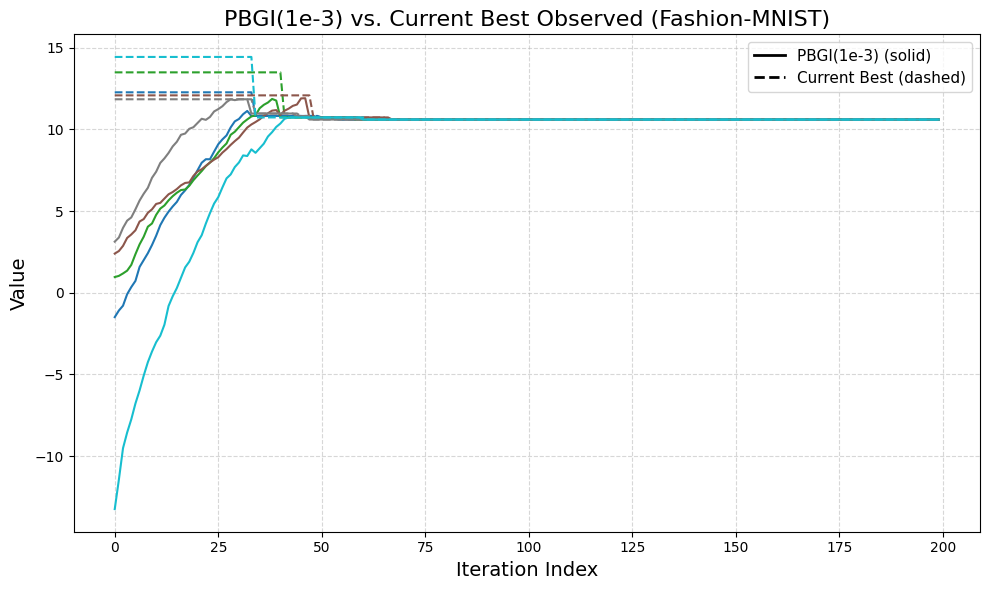

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Use same fixed acquisition and dataset
acq_key = "PBGI(1e-3)"
d = "Fashion-MNIST"

colors = plt.cm.tab10(np.linspace(0, 1, len(sampled_seed_ids)))
plt.figure(figsize=(10, 6))

for seed_id, color in zip(sampled_seed_ids, colors):
    arr1 = metrics_per_acq[d][acq_key]["PBGI(1e-3) acq"][seed_id][1:]
    arr2 = metrics_per_acq[d][acq_key]["current best observed"][seed_id][:-1]

    iterations = np.arange(len(arr1))

    plt.plot(iterations, arr1, color=color, label=f'{acq_key} seed {seed_id}' if seed_id == sampled_seed_ids[0] else "")
    plt.plot(iterations, arr2, color=color, linestyle='--', 
             label=f'Current Best seed {seed_id}' if seed_id == sampled_seed_ids[0] else "")

plt.xlabel("Iteration Index", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.title(f"{acq_key} vs. Current Best Observed ({d})", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)

custom_lines = [
    Line2D([0], [0], color='black', lw=2, label=f'{acq_key} (solid)'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='Current Best (dashed)')
]
plt.legend(handles=custom_lines, fontsize=11, loc="best")

plt.tight_layout()
plt.show()